In [16]:
import sys
import os
import nltk
from torchtext import data, datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm

# Loading data
List of common object words taken from: http://www.manythings.org/vocabulary/lists/l/words.php?f=ogden-picturable

Expansion: http://www.talkenglish.com/vocabulary/top-1500-nouns.aspx

In [5]:
def word_tokenizer(x):
    return nltk.word_tokenize(x)

def char_tokenizer(x):
    return list(x)

def make_data(filename, train_ratio):
    #Make train/val split
    raw_data = pd.read_csv(filename, delimiter="\t", header=None)
    
    filename = filename.strip(".tsv")
    
    train = raw_data.sample(n=int(train_ratio*len(raw_data)),random_state=1111)
    val = raw_data[~raw_data.isin(train)].dropna()
    train.to_csv(f'{filename}_train.tsv', sep="\t", index=False,header=False)
    val.to_csv(f'{filename}_val.tsv', sep="\t", index=False,header=False)
    
    #Word tokenization
    word_field = data.Field(tokenize=word_tokenizer, fix_length=4)

    train_word = data.TabularDataset(path=f"{filename}_train.tsv",
                                  format='tsv',
                                  fields=[('prompt', word_field),
                                          ('answer', word_field)])
    val_word = data.TabularDataset(path=f"{filename}_val.tsv",
                                  format='tsv',
                                  fields=[('prompt', word_field),
                                          ('answer', word_field)])
    test_word = data.TabularDataset(path="test.tsv",
                                  format='tsv',
                                  fields=[('prompt', word_field),
                                          ('answer', word_field)])
    word_field.build_vocab(train_word,val_word,test_word)
    
    print(train_word.examples[0].prompt, train_word.examples[0].answer)
    print(val_word.examples[0].prompt, val_word.examples[0].answer)
    print(test_word.examples[0].prompt, test_word.examples[0].answer)
    
    print(f"Word field vocab size: {len(word_field.vocab)}")
    
    #Character level tokenization
    char_field = data.Field(tokenize=char_tokenizer, eos_token='<eos>', fix_length=30)

    train_char = data.TabularDataset(path=f"{filename}_train.tsv",
                                  format='tsv',
                                  fields=[('prompt', char_field),
                                          ('answer', char_field)])
    val_char = data.TabularDataset(path=f"{filename}_val.tsv",
                                  format='tsv',
                                  fields=[('prompt', char_field),
                                          ('answer', char_field)])
    test_char = data.TabularDataset(path="test.tsv",
                                  format='tsv',
                                  fields=[('prompt', char_field),
                                          ('answer', char_field)])
    char_field.build_vocab(train_char,val_char,test_char)
    
    print(train_char.examples[0].prompt, train_char.examples[0].answer)
    print(val_char.examples[0].prompt, val_char.examples[0].answer)
    print(test_char.examples[0].prompt, test_char.examples[0].answer)
        
    print(f"Character field vocab size: {len(char_field.vocab)}")
    
    return train, val, word_field, train_word, val_word, test_word, char_field, train_char, val_char, test_char

In [6]:
train, val, word_field, train_word, val_word, test_word, char_field, train_char, val_char, test_char = make_data('pokemon.tsv',0.7)

['a', 'tangela', 'is', 'a'] ['tangela']
['a', 'band', 'is', 'a'] ['band']
['a', 'blicket', 'is', 'a'] ['blicket']
Word field vocab size: 450
['a', ' ', 't', 'a', 'n', 'g', 'e', 'l', 'a', ' ', 'i', 's', ' ', 'a'] ['t', 'a', 'n', 'g', 'e', 'l', 'a']
['a', ' ', 'b', 'a', 'n', 'd', ' ', 'i', 's', ' ', 'a'] ['b', 'a', 'n', 'd']
['a', ' ', 'b', 'l', 'i', 'c', 'k', 'e', 't', ' ', 'i', 's', ' ', 'a'] ['b', 'l', 'i', 'c', 'k', 'e', 't']
Character field vocab size: 30


In [7]:
def sort_key(ex):
    return len(ex.prompt)

In [8]:
def early_stop(val_acc_history, t=3, required_progress=0.01):
    """
    Stop the training if there is no non-trivial progress in k steps
    @param val_acc_history: a list contains all the historical validation acc
    @param required_progress: the next acc should be higher than the previous by
        at least required_progress amount to be non-trivial
    @param t: number of training steps
    @return: a boolean indicates if the model should early stop
    """

    if len(val_acc_history) < t + 1:
        return False
    else:
        first = np.array(val_acc_history[-t - 1:-1])
        second = np.array(val_acc_history[-t:])

        if np.all((second - first) < required_progress):
            return True
        else:
            return False

## Baseline LSTM with word level

In [7]:
class baseline(nn.Module):
    def __init__(self, n_embed, d_embed, hidden_size, n_layers, dropout, prompt_length):
        super(baseline, self).__init__()
        self.n_embed = n_embed
        self.d_embed = d_embed
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.embed = nn.Embedding(self.n_embed, self.d_embed)
        self.prompt_length = prompt_length
        self.encoder = nn.LSTM(input_size = self.d_embed,
                               hidden_size = self.hidden_size,
                               num_layers = self.n_layers,
                               batch_first = False,
                               dropout = self.dropout)
        self.mlp_1 = nn.Linear(self.hidden_size*self.n_layers, self.n_embed)
        self.mlp_2 = nn.Linear(self.n_embed, self.n_embed)
        
    def forward(self, x):
        
        x = self.embed(x.prompt)
        state_hist, states = self.encoder(x)
        x = states[0].transpose(0,1).contiguous()
        x = x.view(-1, self.hidden_size*self.n_layers)
        x = self.mlp_1(x)
        x = F.relu(x)
        x = self.mlp_2(x)
        output = F.log_softmax(x,dim=1)
        return output

## Training parameters

In [8]:
n_embed=len(word_field.vocab)
d_embed = 200
hidden_size = 10
n_layers = 2
dropout = 0.2

batch_size = 32
n_epochs = 10000
lr = 0.0001
criterion = nn.NLLLoss()
early_stopping = False

In [9]:
model = baseline(n_embed, d_embed, hidden_size, n_layers, dropout, 4)

In [10]:
train_iter, val_iter, test_iter = data.Iterator.splits((train_word,val_word,test_word),
                                                       batch_size=batch_size,
                                                       sort_key=sort_key,
                                                       device=-1)
train_iter.repeat = False
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

## Train model

In [11]:
def evaluate_word(iterator, model, criterion):
    model.eval()
    n_correct, eval_losses = 0, []
    iterator.init_epoch()
    for batch in iterator:
        out = model(batch)
        n_correct += (torch.max(out, 1)[1].data == batch.answer[0].data).sum()
        eval_losses.append(criterion(out, batch.answer[0]))
    eval_loss = sum(eval_losses) / len(eval_losses)
    return n_correct, eval_loss

In [12]:
def train_word_model():
    best_val_acc = 0.0
    
    for epoch in range(1, n_epochs + 1):
        train_iter.init_epoch()

        for batch in train_iter:
            model.train()
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.answer[0])
            loss.backward()
            clip_grad_norm(filter(lambda p: p.requires_grad, model.parameters()), 10)
            optimizer.step()

            val_correct, val_loss = evaluate_word(val_iter, model, criterion)
            val_accuracy = 100 * val_correct / len(val)

        train_correct, train_loss = evaluate_word(train_iter, model, criterion)
        val_correct, val_loss = evaluate_word(val_iter, model, criterion)
        val_accuracy = 100 * val_correct / len(val)
        val_acc_history.append(val_accuracy)

        stop_training = early_stop(val_acc_history)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model, 'best_word_model.pt')

        print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}, Train Acc: {:.2f}, Val Acc: {:.2f}, Best Val Acc: {:.2f}'.\
                format(epoch,
                       train_loss.data.numpy()[0],
                       val_loss.data.numpy()[0],
                       100 * train_correct / len(train),
                       val_accuracy,
                       best_val_acc))

        if epoch % 100 == 0 or (epoch % 10 == 0 and epoch < 100):
            for batch in test_iter:
                test_predictions.append([epoch,model(batch).data.numpy()[0]])

        if early_stopping and stop_training or (train_correct == len(train)):
            print('Early stop triggered.')
            break

In [13]:
test_predictions = []
val_acc_history = []

train_word_model()

Epoch: 1, Train Loss: 5.3196, Val Loss: 5.3398, Train Acc: 0.72, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 2, Train Loss: 5.3063, Val Loss: 5.3463, Train Acc: 0.72, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 3, Train Loss: 5.3083, Val Loss: 5.3529, Train Acc: 0.72, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 4, Train Loss: 5.3029, Val Loss: 5.3595, Train Acc: 0.72, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 5, Train Loss: 5.3003, Val Loss: 5.3662, Train Acc: 0.72, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 6, Train Loss: 5.2931, Val Loss: 5.3729, Train Acc: 0.72, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 7, Train Loss: 5.2968, Val Loss: 5.3796, Train Acc: 0.72, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 8, Train Loss: 5.2924, Val Loss: 5.3865, Train Acc: 0.72, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 9, Train Loss: 5.2934, Val Loss: 5.3934, Train Acc: 0.72, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 10, Train Loss: 5.2783, Val Loss: 5.4006, Train Acc: 0.72, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 11

Epoch: 86, Train Loss: 4.5671, Val Loss: 7.0964, Train Acc: 6.52, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 87, Train Loss: 4.5601, Val Loss: 7.1279, Train Acc: 6.52, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 88, Train Loss: 4.5422, Val Loss: 7.1586, Train Acc: 6.52, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 89, Train Loss: 4.5304, Val Loss: 7.1882, Train Acc: 6.52, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 90, Train Loss: 4.5218, Val Loss: 7.2172, Train Acc: 6.52, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 91, Train Loss: 4.4972, Val Loss: 7.2455, Train Acc: 7.25, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 92, Train Loss: 4.5165, Val Loss: 7.2740, Train Acc: 7.25, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 93, Train Loss: 4.5005, Val Loss: 7.3024, Train Acc: 7.97, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 94, Train Loss: 4.4863, Val Loss: 7.3305, Train Acc: 8.70, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 95, Train Loss: 4.4797, Val Loss: 7.3601, Train Acc: 8.70, Val Acc: 0.00, Best Val Acc: 0.00


Epoch: 168, Train Loss: 3.7910, Val Loss: 9.2012, Train Acc: 18.84, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 169, Train Loss: 3.7736, Val Loss: 9.2120, Train Acc: 18.12, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 170, Train Loss: 3.7788, Val Loss: 9.2224, Train Acc: 18.12, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 171, Train Loss: 3.7605, Val Loss: 9.2285, Train Acc: 19.57, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 172, Train Loss: 3.6939, Val Loss: 9.2465, Train Acc: 20.29, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 173, Train Loss: 3.7023, Val Loss: 9.2790, Train Acc: 21.01, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 174, Train Loss: 3.6929, Val Loss: 9.2932, Train Acc: 21.01, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 175, Train Loss: 3.6795, Val Loss: 9.3131, Train Acc: 23.91, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 176, Train Loss: 3.6530, Val Loss: 9.3442, Train Acc: 24.64, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 177, Train Loss: 3.7020, Val Loss: 9.3742, Train Acc: 23.19, Val Acc: 0.00,

Epoch: 250, Train Loss: 2.9897, Val Loss: 10.8287, Train Acc: 56.52, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 251, Train Loss: 2.9974, Val Loss: 10.8366, Train Acc: 56.52, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 252, Train Loss: 2.9908, Val Loss: 10.8710, Train Acc: 57.25, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 253, Train Loss: 2.9344, Val Loss: 10.9016, Train Acc: 57.97, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 254, Train Loss: 2.9653, Val Loss: 10.9242, Train Acc: 59.42, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 255, Train Loss: 2.9260, Val Loss: 10.9582, Train Acc: 59.42, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 256, Train Loss: 2.9320, Val Loss: 11.0024, Train Acc: 60.14, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 257, Train Loss: 2.9260, Val Loss: 11.0276, Train Acc: 60.87, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 258, Train Loss: 2.9208, Val Loss: 11.0356, Train Acc: 61.59, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 259, Train Loss: 2.9134, Val Loss: 11.0285, Train Acc: 63.04, Val 

Epoch: 330, Train Loss: 2.3210, Val Loss: 12.2328, Train Acc: 85.51, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 331, Train Loss: 2.2590, Val Loss: 12.2393, Train Acc: 83.33, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 332, Train Loss: 2.2597, Val Loss: 12.2589, Train Acc: 83.33, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 333, Train Loss: 2.2437, Val Loss: 12.2678, Train Acc: 83.33, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 334, Train Loss: 2.2475, Val Loss: 12.2845, Train Acc: 82.61, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 335, Train Loss: 2.2505, Val Loss: 12.3119, Train Acc: 81.88, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 336, Train Loss: 2.2122, Val Loss: 12.3307, Train Acc: 81.88, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 337, Train Loss: 2.2493, Val Loss: 12.3406, Train Acc: 81.88, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 338, Train Loss: 2.2279, Val Loss: 12.3285, Train Acc: 81.16, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 339, Train Loss: 2.1755, Val Loss: 12.3354, Train Acc: 81.16, Val 

Epoch: 413, Train Loss: 1.6540, Val Loss: 13.4455, Train Acc: 94.93, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 414, Train Loss: 1.6489, Val Loss: 13.4549, Train Acc: 94.93, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 415, Train Loss: 1.6450, Val Loss: 13.4541, Train Acc: 94.93, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 416, Train Loss: 1.6160, Val Loss: 13.4480, Train Acc: 94.93, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 417, Train Loss: 1.6454, Val Loss: 13.4823, Train Acc: 95.65, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 418, Train Loss: 1.6263, Val Loss: 13.5096, Train Acc: 95.65, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 419, Train Loss: 1.6201, Val Loss: 13.5212, Train Acc: 95.65, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 420, Train Loss: 1.6035, Val Loss: 13.5423, Train Acc: 95.65, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 421, Train Loss: 1.5696, Val Loss: 13.5718, Train Acc: 94.93, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 422, Train Loss: 1.5846, Val Loss: 13.5830, Train Acc: 94.93, Val 

Epoch: 497, Train Loss: 1.1452, Val Loss: 14.4608, Train Acc: 99.28, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 498, Train Loss: 1.1075, Val Loss: 14.4542, Train Acc: 100.00, Val Acc: 0.00, Best Val Acc: 0.00
Early stop triggered.


## Evaluation

In [14]:
for batch in train_iter:
    out = model(batch)
    
    for row, answer in zip(batch.prompt.data.numpy().transpose(),torch.max(out,1)[1].data.numpy()):
        print([word_field.vocab.itos[i] for i in row])
        print(word_field.vocab.itos[answer])
    break

['a', 'boy', 'is', 'a']
boy
['an', 'office', 'is', 'an']
office
['a', 'house', 'is', 'a']
house
['a', 'button', 'is', 'a']
button
['a', 'shirt', 'is', 'a']
shirt
['a', 'match', 'is', 'a']
match
['a', 'lock', 'is', 'a']
lock
['a', 'brush', 'is', 'a']
brush
['an', 'arm', 'is', 'an']
arm
['a', 'brick', 'is', 'a']
brick
['a', 'watch', 'is', 'a']
watch
['a', 'line', 'is', 'a']
line
['a', 'mouth', 'is', 'a']
mouth
['a', 'skirt', 'is', 'a']
skirt
['a', 'pen', 'is', 'a']
pen
['a', 'heart', 'is', 'a']
heart
['a', 'receipt', 'is', 'a']
receipt
['a', 'worm', 'is', 'a']
worm
['a', 'plow', 'is', 'a']
plow
['a', 'sheep', 'is', 'a']
sheep
['a', 'fly', 'is', 'a']
fly
['a', 'tooth', 'is', 'a']
tooth
['a', 'knee', 'is', 'a']
knee
['a', 'gun', 'is', 'a']
gun
['a', 'curtain', 'is', 'a']
curtain
['a', 'nut', 'is', 'a']
nut
['a', 'knot', 'is', 'a']
knot
['a', 'pig', 'is', 'a']
pig
['a', 'goat', 'is', 'a']
goat
['a', 'shoe', 'is', 'a']
shoe
['a', 'bed', 'is', 'a']
bed
['a', 'plate', 'is', 'a']
plate


In [15]:
for batch in val_iter:
    out = model(batch)
    
    for row, answer in zip(batch.prompt.data.numpy().transpose(),torch.max(out,1)[1].data.numpy()):
        print([word_field.vocab.itos[i] for i in row])
        print(word_field.vocab.itos[answer])
    break

['a', 'library', 'is', 'a']
pin
['a', 'key', 'is', 'a']
nerve
['a', 'horse', 'is', 'a']
stomach
['a', 'hook', 'is', 'a']
cake
['a', 'hat', 'is', 'a']
train
['a', 'hammer', 'is', 'a']
baby
['a', 'girl', 'is', 'a']
frame
['a', 'fork', 'is', 'a']
store
['a', 'foot', 'is', 'a']
root
['a', 'flag', 'is', 'a']
door
['a', 'farm', 'is', 'a']
hand
['a', 'drawer', 'is', 'a']
prison
['a', 'cup', 'is', 'a']
sheep
['a', 'comb', 'is', 'a']
cheese
['a', 'circle', 'is', 'a']
nail
['a', 'chin', 'is', 'a']
store
['a', 'chest', 'is', 'a']
mouth
['a', 'chain', 'is', 'a']
bag
['a', 'cart', 'is', 'a']
store
['a', 'branch', 'is', 'a']
cord
['a', 'box', 'is', 'a']
plow
['a', 'boot', 'is', 'a']
pen
['a', 'book', 'is', 'a']
town
['a', 'bone', 'is', 'a']
cord
['a', 'boat', 'is', 'a']
prison
['a', 'blade', 'is', 'a']
bulb
['a', 'bee', 'is', 'a']
match
['a', 'basket', 'is', 'a']
curtain
['a', 'band', 'is', 'a']
fly
['a', 'ball', 'is', 'a']
drain
['an', 'apple', 'is', 'an']
arm
['an', 'angle', 'is', 'an']
egg


In [16]:
train_words = []

for batch in train_iter:
    train_words.extend(batch.answer[0].data.numpy())
    
train_words = np.sort(train_words)

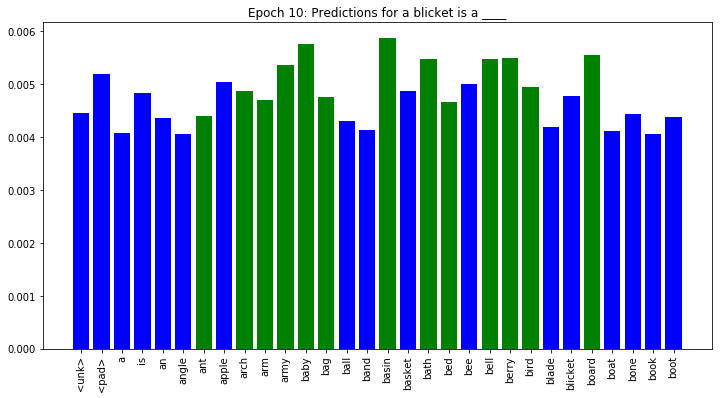

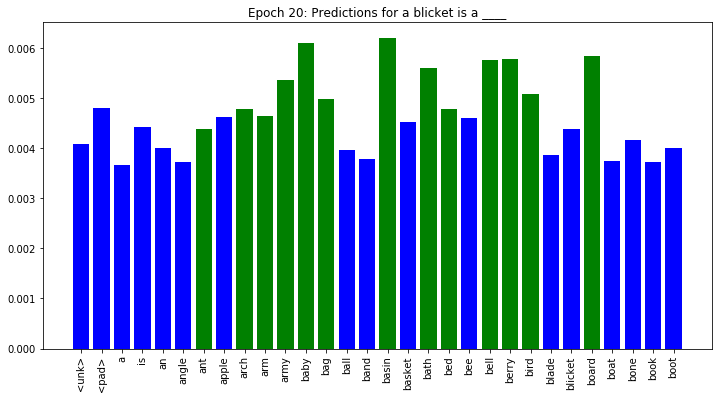

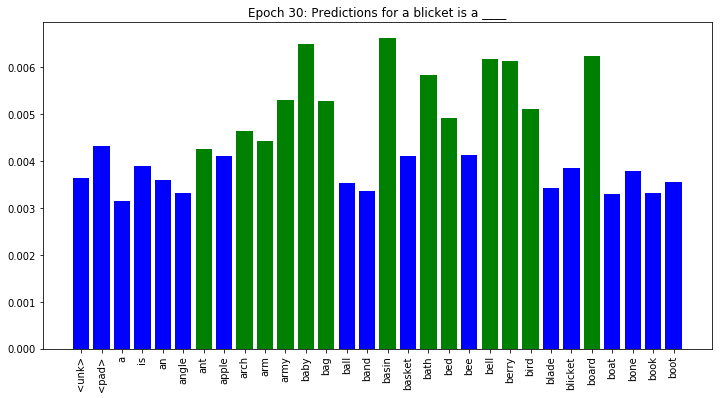

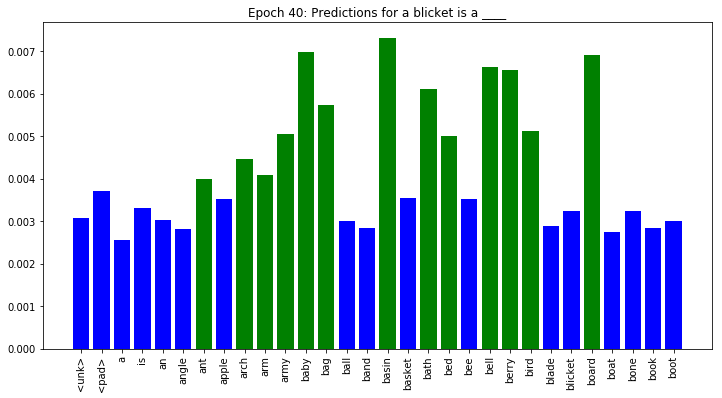

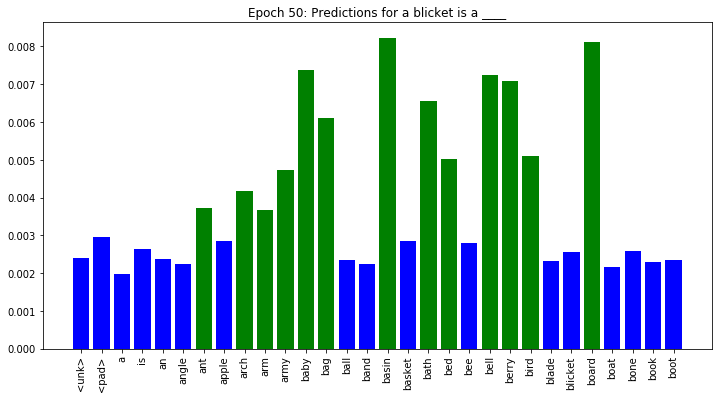

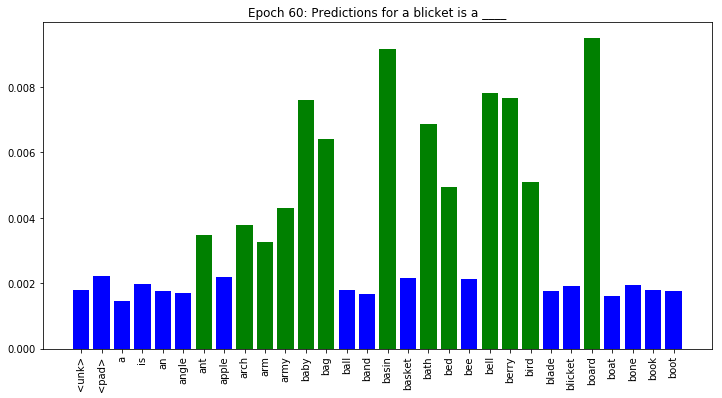

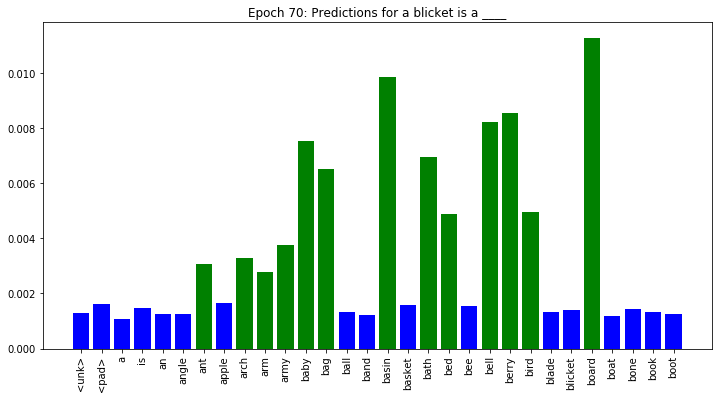

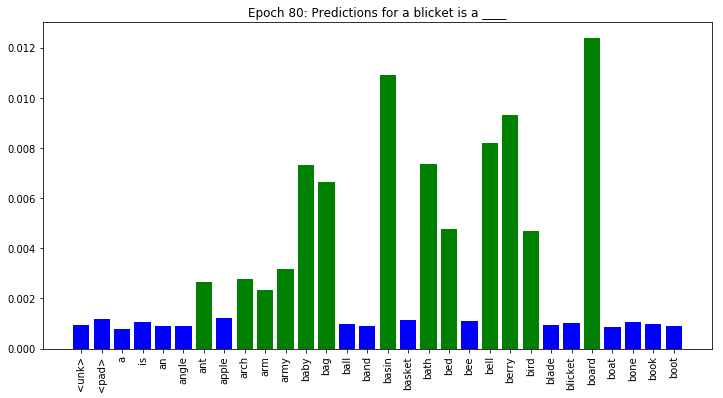

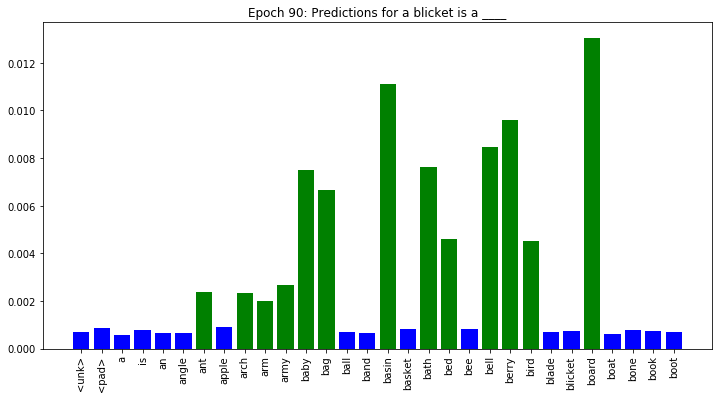

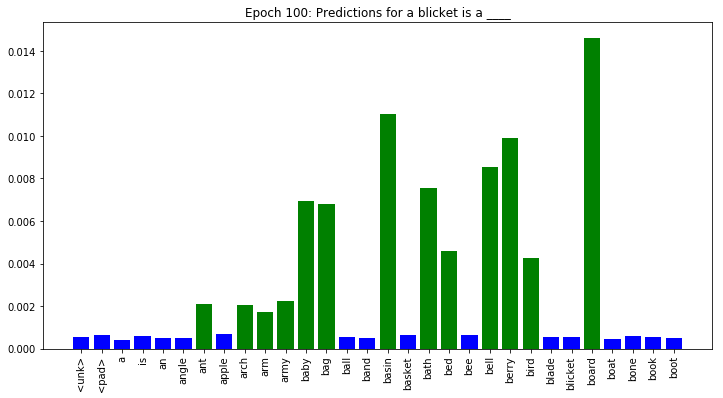

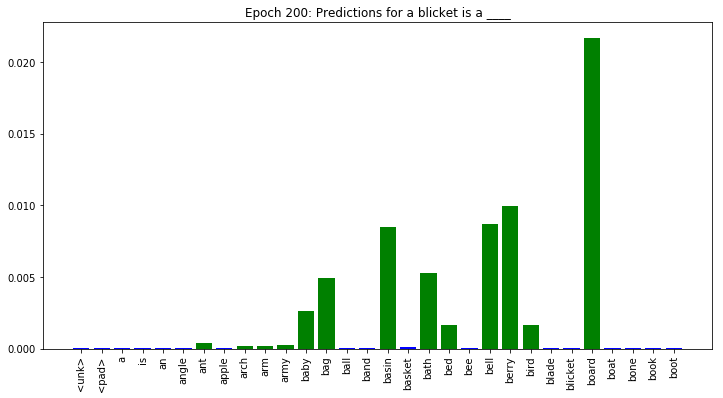

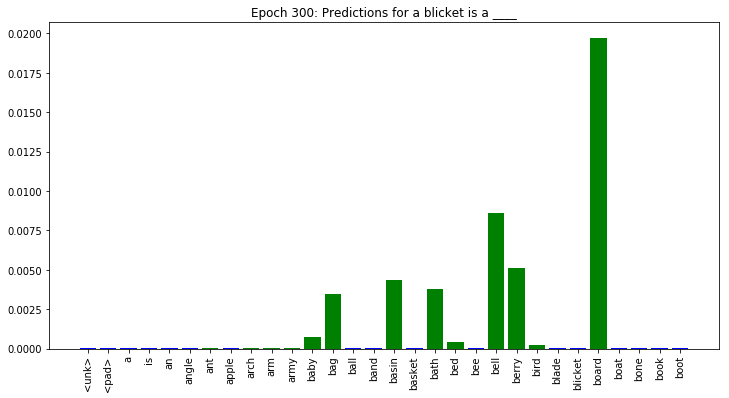

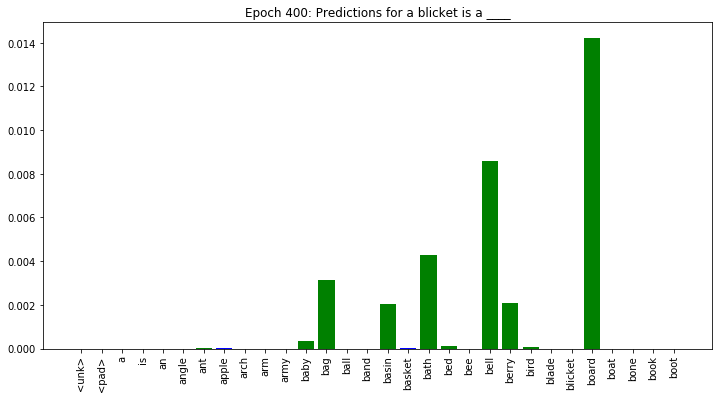

In [17]:
for row in test_predictions:
    plt.figure(figsize=(12,6))
    plt.title(f"Epoch {str(row[0])}: Predictions for a blicket is a ____")
    probs = [np.e**i for i in (row[1])][:30]
    plt.bar(range(30),probs,color=['g' if i in train_words else 'b' for i in range(30)])
    plt.xticks(range(30),[word_field.vocab.itos[i] for i in range(30)],rotation=90)

In [18]:
for p in model.embed.parameters():
    weights = p.data.numpy()

([<matplotlib.axis.XTick at 0x1a21b08860>,
 <a list of 30 Text xticklabel objects>)

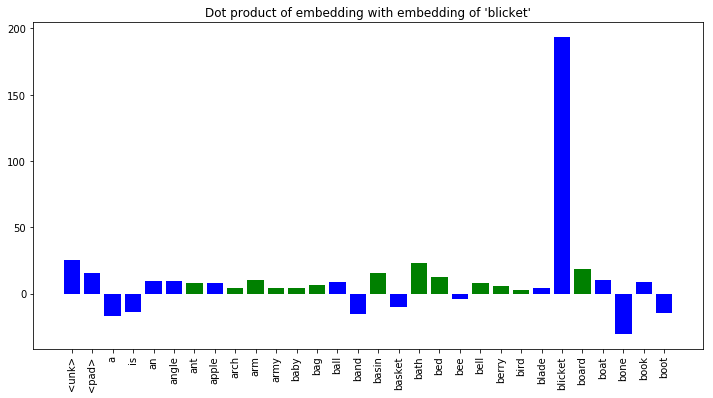

In [19]:
plt.figure(figsize=(12,6))
plt.title("Dot product of embedding with embedding of 'blicket'")
dot = [weights[24].dot(i) for i in weights[:30]]
plt.bar(range(30),dot,color=['g' if i in train_words else 'b' for i in range(30)])
plt.xticks(range(30),[word_field.vocab.itos[i] for i in range(30)],rotation=90)

# Character level LSTM

In [20]:
class charLSTM(nn.Module):
    def __init__(self, n_embed, d_embed, hidden_size, n_layers, dropout, bidirectional, prompt_length):
        super(charLSTM, self).__init__()
        self.n_embed = n_embed
        self.d_embed = d_embed
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.embed = nn.Embedding(self.n_embed, self.d_embed)
        self.prompt_length = prompt_length
        self.bidirectional = bidirectional
        self.encoder = nn.LSTM(input_size = self.d_embed,
                               hidden_size = self.hidden_size,
                               num_layers = self.n_layers,
                               batch_first = False,
                               dropout = self.dropout,
                               bidirectional = self.bidirectional)
        self.decoder = nn.LSTM(input_size = self.hidden_size,
                       hidden_size = self.hidden_size,
                       num_layers = self.n_layers,
                       batch_first = False,
                       dropout = self.dropout)
        self.mlp_1 = nn.Linear(self.hidden_size*self.n_layers, self.hidden_size)
        self.mlp_2 = nn.Linear(self.hidden_size, self.n_embed)
        
    def forward(self, x):
        x = self.embed(x.prompt)
        state_hist, states = self.encoder(x)
        x = states[0]
        
        decoded = Variable(torch.FloatTensor(x.shape[1], self.n_embed, self.prompt_length).zero_())

        for dim in range(self.prompt_length):
            state_hist, states = self.decoder(x)
            x = states[0]
            output = x.transpose(0,1).contiguous().view(-1, self.hidden_size*self.n_layers)
            output = self.mlp_1(output)
            output = F.relu(output)
            output = self.mlp_2(output)
            
            decoded[:,:,dim] = output
            
        decoded = F.log_softmax(decoded, dim=1)
            
        return decoded

## Training parameters

In [11]:
n_embed=len(char_field.vocab)
d_embed = 50
hidden_size = 50
n_layers = 2
dropout = 0
seq_length = 30
bidirectional = False

batch_size = 32
n_epochs = 50000
lr = 0.0001
criterion = nn.NLLLoss()
early_stopping = False

In [ ]:
model = charLSTM(n_embed, d_embed, hidden_size, n_layers, dropout, bidirectional, seq_length)

In [ ]:
train_iter, val_iter, test_iter = data.Iterator.splits((train_char,val_char,test_char),
                                                       batch_size=batch_size,
                                                       sort_key=sort_key,
                                                       device=-1)
train_iter.repeat = False
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [12]:
def evaluate_char(iterator, model, criterion, attention=False):
    model.eval()
    n_correct, n_pad, eval_losses = 0, 0, []
    iterator.init_epoch()
    for batch in iterator:
        if attention:
            out, attentions = model(batch)
        else:
            out = model(batch)
            
        n_correct += (torch.max(out,1)[1].data == batch.answer.transpose(0,1).data).sum()
        n_pad += (batch.answer.transpose(0,1).data == 1).sum()
        
        loss = 0          
        for i in range(30):
            loss = criterion(out[:,:,i], batch.answer[i,:])
        eval_losses.append(loss)
    eval_loss = sum(eval_losses) / len(eval_losses)
    
    return n_correct, n_pad, eval_loss

In [13]:
def train_char_model(save_pt, attention=False):
    best_val_acc = 0.0
    
    for epoch in range(1, n_epochs + 1):
        train_iter.init_epoch()

        for batch in train_iter:
            model.train()
            optimizer.zero_grad()
            
            if attention:
                out, attentions = model(batch)
            else:
                out = model(batch)
            
            loss = 0
            
            for i in range(seq_length):
                loss += criterion(out[:,:,i], batch.answer[i,:])
                
            loss.backward()
            clip_grad_norm(filter(lambda p: p.requires_grad, model.parameters()), 10)
            optimizer.step()



        train_correct, train_pad, train_loss = evaluate_char(train_iter, model, criterion, attention)
        train_accuracy = 100 * (train_correct - train_pad) / (len(train)*30 - train_pad)
        val_correct, val_pad, val_loss = evaluate_char(val_iter, model, criterion, attention)
        val_accuracy = 100 * (val_correct - val_pad) / (len(val)*30 - val_pad)
        val_acc_history.append(val_accuracy)

        stop_training = early_stop(val_acc_history)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model, save_pt)

        print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}, Train Acc: {:.2f}, Val Acc: {:.2f}, Best Val Acc: {:.2f}'.\
                format(epoch,
                       train_loss.data.numpy()[0],
                       val_loss.data.numpy()[0],
                       train_accuracy,
                       val_accuracy,
                       best_val_acc))

        if epoch % 100 == 0 or (epoch % 10 == 0 and epoch < 100):
            for batch in test_iter:
                if attention:
                    out, attentions = model(batch)
                else:
                    out = model(batch)
                    
                test_predictions.append([epoch,out.data.numpy()[0]])

        if early_stopping and stop_training or (train_correct == len(train)*30):
            print('Early stop triggered.')
            break

In [26]:
test_predictions = []
val_acc_history = []

train_char_model('best_char_model.pt')

Epoch: 1, Train Loss: 3.3322, Val Loss: 3.3322, Train Acc: 0.00, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 2, Train Loss: 3.3253, Val Loss: 3.3253, Train Acc: 0.00, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 3, Train Loss: 3.3184, Val Loss: 3.3184, Train Acc: 0.00, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 4, Train Loss: 3.3115, Val Loss: 3.3115, Train Acc: 0.00, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 5, Train Loss: 3.3045, Val Loss: 3.3045, Train Acc: 0.00, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 6, Train Loss: 3.2976, Val Loss: 3.2976, Train Acc: 0.00, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 7, Train Loss: 3.2908, Val Loss: 3.2908, Train Acc: 0.00, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 8, Train Loss: 3.2840, Val Loss: 3.2840, Train Acc: 0.00, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 9, Train Loss: 3.2770, Val Loss: 3.2770, Train Acc: 0.00, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 10, Train Loss: 3.2696, Val Loss: 3.2696, Train Acc: 0.00, Val Acc: 0.00, Best Val Acc: 0.00
Epoch: 11

/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type charLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 22, Train Loss: 3.1582, Val Loss: 3.1582, Train Acc: 80.92, Val Acc: 81.44, Best Val Acc: 81.44
Epoch: 23, Train Loss: 3.1462, Val Loss: 3.1462, Train Acc: 80.92, Val Acc: 81.44, Best Val Acc: 81.44
Epoch: 24, Train Loss: 3.1334, Val Loss: 3.1334, Train Acc: 80.92, Val Acc: 81.44, Best Val Acc: 81.44
Epoch: 25, Train Loss: 3.1196, Val Loss: 3.1196, Train Acc: 80.92, Val Acc: 81.44, Best Val Acc: 81.44
Epoch: 26, Train Loss: 3.1053, Val Loss: 3.1053, Train Acc: 80.92, Val Acc: 81.44, Best Val Acc: 81.44
Epoch: 27, Train Loss: 3.0902, Val Loss: 3.0902, Train Acc: 80.92, Val Acc: 81.44, Best Val Acc: 81.44
Epoch: 28, Train Loss: 3.0738, Val Loss: 3.0738, Train Acc: 80.92, Val Acc: 81.44, Best Val Acc: 81.44
Epoch: 29, Train Loss: 3.0558, Val Loss: 3.0558, Train Acc: 80.92, Val Acc: 81.44, Best Val Acc: 81.44
Epoch: 30, Train Loss: 3.0362, Val Loss: 3.0362, Train Acc: 80.92, Val Acc: 81.44, Best Val Acc: 81.44
Epoch: 31, Train Loss: 3.0145, Val Loss: 3.0145, Train Acc: 80.92, Val Ac

Epoch: 102, Train Loss: 0.0091, Val Loss: 0.0091, Train Acc: 81.67, Val Acc: 82.06, Best Val Acc: 82.06
Epoch: 103, Train Loss: 0.0089, Val Loss: 0.0089, Train Acc: 81.67, Val Acc: 82.06, Best Val Acc: 82.06
Epoch: 104, Train Loss: 0.0088, Val Loss: 0.0088, Train Acc: 81.67, Val Acc: 82.06, Best Val Acc: 82.06
Epoch: 105, Train Loss: 0.0088, Val Loss: 0.0088, Train Acc: 81.67, Val Acc: 82.06, Best Val Acc: 82.06
Epoch: 106, Train Loss: 0.0088, Val Loss: 0.0088, Train Acc: 81.67, Val Acc: 82.06, Best Val Acc: 82.06
Epoch: 107, Train Loss: 0.0088, Val Loss: 0.0088, Train Acc: 81.67, Val Acc: 82.06, Best Val Acc: 82.06
Epoch: 108, Train Loss: 0.0088, Val Loss: 0.0088, Train Acc: 81.67, Val Acc: 82.06, Best Val Acc: 82.06
Epoch: 109, Train Loss: 0.0088, Val Loss: 0.0088, Train Acc: 81.67, Val Acc: 82.06, Best Val Acc: 82.06
Epoch: 110, Train Loss: 0.0087, Val Loss: 0.0087, Train Acc: 81.67, Val Acc: 82.06, Best Val Acc: 82.06
Epoch: 111, Train Loss: 0.0087, Val Loss: 0.0087, Train Acc: 81.

Epoch: 181, Train Loss: 0.0045, Val Loss: 0.0045, Train Acc: 81.35, Val Acc: 82.00, Best Val Acc: 82.06
Epoch: 182, Train Loss: 0.0044, Val Loss: 0.0044, Train Acc: 81.86, Val Acc: 82.61, Best Val Acc: 82.61
Epoch: 183, Train Loss: 0.0044, Val Loss: 0.0044, Train Acc: 81.86, Val Acc: 82.61, Best Val Acc: 82.61
Epoch: 184, Train Loss: 0.0043, Val Loss: 0.0043, Train Acc: 81.86, Val Acc: 82.61, Best Val Acc: 82.61
Epoch: 185, Train Loss: 0.0041, Val Loss: 0.0041, Train Acc: 81.86, Val Acc: 82.61, Best Val Acc: 82.61
Epoch: 186, Train Loss: 0.0040, Val Loss: 0.0040, Train Acc: 82.10, Val Acc: 82.89, Best Val Acc: 82.89
Epoch: 187, Train Loss: 0.0041, Val Loss: 0.0041, Train Acc: 82.10, Val Acc: 82.89, Best Val Acc: 82.89
Epoch: 188, Train Loss: 0.0042, Val Loss: 0.0042, Train Acc: 82.10, Val Acc: 82.89, Best Val Acc: 82.89
Epoch: 189, Train Loss: 0.0043, Val Loss: 0.0043, Train Acc: 82.10, Val Acc: 82.89, Best Val Acc: 82.89
Epoch: 190, Train Loss: 0.0042, Val Loss: 0.0042, Train Acc: 82.

Epoch: 260, Train Loss: 0.0015, Val Loss: 0.0015, Train Acc: 83.16, Val Acc: 84.44, Best Val Acc: 84.44
Epoch: 261, Train Loss: 0.0015, Val Loss: 0.0015, Train Acc: 83.16, Val Acc: 84.44, Best Val Acc: 84.44
Epoch: 262, Train Loss: 0.0016, Val Loss: 0.0016, Train Acc: 83.16, Val Acc: 84.44, Best Val Acc: 84.44
Epoch: 263, Train Loss: 0.0016, Val Loss: 0.0016, Train Acc: 83.16, Val Acc: 84.44, Best Val Acc: 84.44
Epoch: 264, Train Loss: 0.0016, Val Loss: 0.0016, Train Acc: 83.16, Val Acc: 84.44, Best Val Acc: 84.44
Epoch: 265, Train Loss: 0.0015, Val Loss: 0.0015, Train Acc: 83.16, Val Acc: 84.44, Best Val Acc: 84.44
Epoch: 266, Train Loss: 0.0014, Val Loss: 0.0014, Train Acc: 83.29, Val Acc: 84.67, Best Val Acc: 84.67
Epoch: 267, Train Loss: 0.0014, Val Loss: 0.0014, Train Acc: 83.29, Val Acc: 84.67, Best Val Acc: 84.67
Epoch: 268, Train Loss: 0.0014, Val Loss: 0.0014, Train Acc: 83.29, Val Acc: 84.67, Best Val Acc: 84.67
Epoch: 269, Train Loss: 0.0014, Val Loss: 0.0014, Train Acc: 83.

Epoch: 339, Train Loss: 0.0009, Val Loss: 0.0009, Train Acc: 84.03, Val Acc: 84.78, Best Val Acc: 85.22
Epoch: 340, Train Loss: 0.0009, Val Loss: 0.0009, Train Acc: 82.83, Val Acc: 83.44, Best Val Acc: 85.22
Epoch: 341, Train Loss: 0.0009, Val Loss: 0.0009, Train Acc: 84.40, Val Acc: 85.00, Best Val Acc: 85.22
Epoch: 342, Train Loss: 0.0009, Val Loss: 0.0009, Train Acc: 83.86, Val Acc: 84.44, Best Val Acc: 85.22
Epoch: 343, Train Loss: 0.0010, Val Loss: 0.0010, Train Acc: 84.32, Val Acc: 85.06, Best Val Acc: 85.22
Epoch: 344, Train Loss: 0.0010, Val Loss: 0.0010, Train Acc: 84.40, Val Acc: 85.17, Best Val Acc: 85.22
Epoch: 345, Train Loss: 0.0010, Val Loss: 0.0010, Train Acc: 84.83, Val Acc: 85.44, Best Val Acc: 85.44
Epoch: 346, Train Loss: 0.0010, Val Loss: 0.0010, Train Acc: 83.86, Val Acc: 84.33, Best Val Acc: 85.44
Epoch: 347, Train Loss: 0.0011, Val Loss: 0.0011, Train Acc: 82.95, Val Acc: 83.67, Best Val Acc: 85.44
Epoch: 348, Train Loss: 0.0011, Val Loss: 0.0011, Train Acc: 83.

Epoch: 418, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 85.29, Val Acc: 86.00, Best Val Acc: 87.33
Epoch: 419, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 86.43, Val Acc: 87.17, Best Val Acc: 87.33
Epoch: 420, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 85.17, Val Acc: 85.78, Best Val Acc: 87.33
Epoch: 421, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 86.45, Val Acc: 87.22, Best Val Acc: 87.33
Epoch: 422, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 85.02, Val Acc: 85.89, Best Val Acc: 87.33
Epoch: 423, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 86.35, Val Acc: 87.06, Best Val Acc: 87.33
Epoch: 424, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 85.17, Val Acc: 85.72, Best Val Acc: 87.33
Epoch: 425, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 86.47, Val Acc: 87.33, Best Val Acc: 87.33
Epoch: 426, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 85.51, Val Acc: 86.22, Best Val Acc: 87.33
Epoch: 427, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 86.

Epoch: 497, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 86.67, Val Acc: 87.39, Best Val Acc: 87.44
Epoch: 498, Train Loss: 0.0018, Val Loss: 0.0018, Train Acc: 86.35, Val Acc: 87.33, Best Val Acc: 87.44
Epoch: 499, Train Loss: 0.0017, Val Loss: 0.0017, Train Acc: 85.60, Val Acc: 86.50, Best Val Acc: 87.44
Epoch: 500, Train Loss: 0.0017, Val Loss: 0.0017, Train Acc: 86.67, Val Acc: 87.39, Best Val Acc: 87.44
Epoch: 501, Train Loss: 0.0017, Val Loss: 0.0017, Train Acc: 85.82, Val Acc: 86.61, Best Val Acc: 87.44
Epoch: 502, Train Loss: 0.0017, Val Loss: 0.0017, Train Acc: 86.64, Val Acc: 87.39, Best Val Acc: 87.44
Epoch: 503, Train Loss: 0.0017, Val Loss: 0.0017, Train Acc: 84.49, Val Acc: 85.22, Best Val Acc: 87.44
Epoch: 504, Train Loss: 0.0017, Val Loss: 0.0017, Train Acc: 86.57, Val Acc: 87.39, Best Val Acc: 87.44
Epoch: 505, Train Loss: 0.0017, Val Loss: 0.0017, Train Acc: 86.62, Val Acc: 87.39, Best Val Acc: 87.44
Epoch: 506, Train Loss: 0.0017, Val Loss: 0.0017, Train Acc: 86.

Epoch: 576, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.55, Val Acc: 87.39, Best Val Acc: 87.50
Epoch: 577, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.52, Val Acc: 87.22, Best Val Acc: 87.50
Epoch: 578, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.59, Val Acc: 87.33, Best Val Acc: 87.50
Epoch: 579, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.59, Val Acc: 87.28, Best Val Acc: 87.50
Epoch: 580, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.50, Val Acc: 87.39, Best Val Acc: 87.50
Epoch: 581, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.45, Val Acc: 87.17, Best Val Acc: 87.50
Epoch: 582, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.52, Val Acc: 87.33, Best Val Acc: 87.50
Epoch: 583, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.57, Val Acc: 87.28, Best Val Acc: 87.50
Epoch: 584, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.55, Val Acc: 87.33, Best Val Acc: 87.50
Epoch: 585, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.

Epoch: 655, Train Loss: 0.0010, Val Loss: 0.0010, Train Acc: 86.59, Val Acc: 87.22, Best Val Acc: 87.50
Epoch: 656, Train Loss: 0.0009, Val Loss: 0.0009, Train Acc: 86.69, Val Acc: 87.22, Best Val Acc: 87.50
Epoch: 657, Train Loss: 0.0009, Val Loss: 0.0009, Train Acc: 86.64, Val Acc: 87.33, Best Val Acc: 87.50
Epoch: 658, Train Loss: 0.0009, Val Loss: 0.0009, Train Acc: 86.55, Val Acc: 87.33, Best Val Acc: 87.50
Epoch: 659, Train Loss: 0.0010, Val Loss: 0.0010, Train Acc: 86.64, Val Acc: 87.33, Best Val Acc: 87.50
Epoch: 660, Train Loss: 0.0009, Val Loss: 0.0009, Train Acc: 85.29, Val Acc: 86.33, Best Val Acc: 87.50
Epoch: 661, Train Loss: 0.0010, Val Loss: 0.0010, Train Acc: 86.40, Val Acc: 86.39, Best Val Acc: 87.50
Epoch: 662, Train Loss: 0.0009, Val Loss: 0.0009, Train Acc: 85.82, Val Acc: 86.39, Best Val Acc: 87.50
Epoch: 663, Train Loss: 0.0010, Val Loss: 0.0010, Train Acc: 86.62, Val Acc: 87.28, Best Val Acc: 87.50
Epoch: 664, Train Loss: 0.0010, Val Loss: 0.0010, Train Acc: 86.

Epoch: 734, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.57, Val Acc: 87.33, Best Val Acc: 87.61
Epoch: 735, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.69, Val Acc: 87.44, Best Val Acc: 87.61
Epoch: 736, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.64, Val Acc: 87.39, Best Val Acc: 87.61
Epoch: 737, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.55, Val Acc: 87.50, Best Val Acc: 87.61
Epoch: 738, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.64, Val Acc: 87.33, Best Val Acc: 87.61
Epoch: 739, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.64, Val Acc: 87.39, Best Val Acc: 87.61
Epoch: 740, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.67, Val Acc: 87.44, Best Val Acc: 87.61
Epoch: 741, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.64, Val Acc: 87.33, Best Val Acc: 87.61
Epoch: 742, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.55, Val Acc: 87.33, Best Val Acc: 87.61
Epoch: 743, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.

Epoch: 813, Train Loss: 0.0005, Val Loss: 0.0005, Train Acc: 86.86, Val Acc: 87.44, Best Val Acc: 87.61
Epoch: 814, Train Loss: 0.0005, Val Loss: 0.0005, Train Acc: 85.53, Val Acc: 86.72, Best Val Acc: 87.61
Epoch: 815, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.79, Val Acc: 87.44, Best Val Acc: 87.61
Epoch: 816, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.21, Val Acc: 86.94, Best Val Acc: 87.61
Epoch: 817, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.88, Val Acc: 87.39, Best Val Acc: 87.61
Epoch: 818, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.26, Val Acc: 87.00, Best Val Acc: 87.61
Epoch: 819, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.81, Val Acc: 87.56, Best Val Acc: 87.61
Epoch: 820, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.45, Val Acc: 87.00, Best Val Acc: 87.61
Epoch: 821, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.81, Val Acc: 87.61, Best Val Acc: 87.61
Epoch: 822, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.

Epoch: 892, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.69, Val Acc: 87.50, Best Val Acc: 87.78
Epoch: 893, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.64, Val Acc: 87.44, Best Val Acc: 87.78
Epoch: 894, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.57, Val Acc: 87.39, Best Val Acc: 87.78
Epoch: 895, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.79, Val Acc: 87.61, Best Val Acc: 87.78
Epoch: 896, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.84, Val Acc: 87.67, Best Val Acc: 87.78
Epoch: 897, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.79, Val Acc: 87.61, Best Val Acc: 87.78
Epoch: 898, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.62, Val Acc: 87.44, Best Val Acc: 87.78
Epoch: 899, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.64, Val Acc: 87.33, Best Val Acc: 87.78
Epoch: 900, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.64, Val Acc: 87.39, Best Val Acc: 87.78
Epoch: 901, Train Loss: 0.0005, Val Loss: 0.0005, Train Acc: 86.

Epoch: 971, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.88, Val Acc: 87.22, Best Val Acc: 87.78
Epoch: 972, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.88, Val Acc: 87.67, Best Val Acc: 87.78
Epoch: 973, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.86, Val Acc: 87.61, Best Val Acc: 87.78
Epoch: 974, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.86, Val Acc: 87.61, Best Val Acc: 87.78
Epoch: 975, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.88, Val Acc: 87.56, Best Val Acc: 87.78
Epoch: 976, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.88, Val Acc: 87.33, Best Val Acc: 87.78
Epoch: 977, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.88, Val Acc: 87.44, Best Val Acc: 87.78
Epoch: 978, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.79, Val Acc: 87.39, Best Val Acc: 87.78
Epoch: 979, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.81, Val Acc: 87.61, Best Val Acc: 87.78
Epoch: 980, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.

Epoch: 1050, Train Loss: 0.0003, Val Loss: 0.0003, Train Acc: 86.50, Val Acc: 87.28, Best Val Acc: 87.78
Epoch: 1051, Train Loss: 0.0003, Val Loss: 0.0003, Train Acc: 86.91, Val Acc: 87.44, Best Val Acc: 87.78
Epoch: 1052, Train Loss: 0.0003, Val Loss: 0.0003, Train Acc: 86.88, Val Acc: 87.39, Best Val Acc: 87.78
Epoch: 1053, Train Loss: 0.0003, Val Loss: 0.0003, Train Acc: 86.88, Val Acc: 87.22, Best Val Acc: 87.78
Epoch: 1054, Train Loss: 0.0003, Val Loss: 0.0003, Train Acc: 86.81, Val Acc: 87.44, Best Val Acc: 87.78
Epoch: 1055, Train Loss: 0.0003, Val Loss: 0.0003, Train Acc: 86.76, Val Acc: 87.33, Best Val Acc: 87.78
Epoch: 1056, Train Loss: 0.0003, Val Loss: 0.0003, Train Acc: 86.86, Val Acc: 87.28, Best Val Acc: 87.78
Epoch: 1057, Train Loss: 0.0003, Val Loss: 0.0003, Train Acc: 86.81, Val Acc: 87.06, Best Val Acc: 87.78
Epoch: 1058, Train Loss: 0.0003, Val Loss: 0.0003, Train Acc: 86.86, Val Acc: 87.44, Best Val Acc: 87.78
Epoch: 1059, Train Loss: 0.0003, Val Loss: 0.0003, Trai

Epoch: 1129, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.84, Val Acc: 87.11, Best Val Acc: 87.78
Epoch: 1130, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.86, Val Acc: 87.67, Best Val Acc: 87.78
Epoch: 1131, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.76, Val Acc: 87.67, Best Val Acc: 87.78
Epoch: 1132, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.86, Val Acc: 87.22, Best Val Acc: 87.78
Epoch: 1133, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.88, Val Acc: 87.22, Best Val Acc: 87.78
Epoch: 1134, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.98, Val Acc: 87.50, Best Val Acc: 87.78
Epoch: 1135, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.88, Val Acc: 87.33, Best Val Acc: 87.78
Epoch: 1136, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.93, Val Acc: 87.50, Best Val Acc: 87.78
Epoch: 1137, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.88, Val Acc: 87.06, Best Val Acc: 87.78
Epoch: 1138, Train Loss: 0.0002, Val Loss: 0.0002, Trai

Epoch: 1208, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.33, Val Acc: 87.11, Best Val Acc: 87.78
Epoch: 1209, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.69, Val Acc: 87.06, Best Val Acc: 87.78
Epoch: 1210, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.98, Val Acc: 87.33, Best Val Acc: 87.78
Epoch: 1211, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.93, Val Acc: 87.56, Best Val Acc: 87.78
Epoch: 1212, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.98, Val Acc: 87.39, Best Val Acc: 87.78
Epoch: 1213, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.91, Val Acc: 87.67, Best Val Acc: 87.78
Epoch: 1214, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.74, Val Acc: 87.22, Best Val Acc: 87.78
Epoch: 1215, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.91, Val Acc: 87.39, Best Val Acc: 87.78
Epoch: 1216, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 86.76, Val Acc: 87.00, Best Val Acc: 87.78
Epoch: 1217, Train Loss: 0.0002, Val Loss: 0.0002, Trai

Epoch: 1287, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.86, Val Acc: 87.28, Best Val Acc: 87.78
Epoch: 1288, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.79, Val Acc: 87.28, Best Val Acc: 87.78
Epoch: 1289, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.91, Val Acc: 87.11, Best Val Acc: 87.78
Epoch: 1290, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.93, Val Acc: 87.39, Best Val Acc: 87.78
Epoch: 1291, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.91, Val Acc: 87.17, Best Val Acc: 87.78
Epoch: 1292, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.91, Val Acc: 87.39, Best Val Acc: 87.78
Epoch: 1293, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.98, Val Acc: 87.22, Best Val Acc: 87.78
Epoch: 1294, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.86, Val Acc: 87.28, Best Val Acc: 87.78
Epoch: 1295, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.98, Val Acc: 87.50, Best Val Acc: 87.78
Epoch: 1296, Train Loss: 0.0001, Val Loss: 0.0001, Trai

Epoch: 1366, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.05, Val Acc: 87.17, Best Val Acc: 87.78
Epoch: 1367, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.64, Val Acc: 87.17, Best Val Acc: 87.78
Epoch: 1368, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.50, Val Acc: 86.89, Best Val Acc: 87.78
Epoch: 1369, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.93, Val Acc: 87.11, Best Val Acc: 87.78
Epoch: 1370, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.93, Val Acc: 87.50, Best Val Acc: 87.78
Epoch: 1371, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.93, Val Acc: 87.33, Best Val Acc: 87.78
Epoch: 1372, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.98, Val Acc: 87.22, Best Val Acc: 87.78
Epoch: 1373, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.03, Val Acc: 87.56, Best Val Acc: 87.78
Epoch: 1374, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.91, Val Acc: 87.11, Best Val Acc: 87.78
Epoch: 1375, Train Loss: 0.0001, Val Loss: 0.0001, Trai

Epoch: 1445, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.47, Val Acc: 87.22, Best Val Acc: 87.78
Epoch: 1446, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.62, Val Acc: 86.72, Best Val Acc: 87.78
Epoch: 1447, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.93, Val Acc: 87.11, Best Val Acc: 87.78
Epoch: 1448, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.81, Val Acc: 87.33, Best Val Acc: 87.78
Epoch: 1449, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.21, Val Acc: 86.56, Best Val Acc: 87.78
Epoch: 1450, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.50, Val Acc: 87.00, Best Val Acc: 87.78
Epoch: 1451, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.05, Val Acc: 87.61, Best Val Acc: 87.78
Epoch: 1452, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.93, Val Acc: 87.28, Best Val Acc: 87.78
Epoch: 1453, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.91, Val Acc: 87.22, Best Val Acc: 87.78
Epoch: 1454, Train Loss: 0.0001, Val Loss: 0.0001, Trai

Epoch: 1524, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.00, Val Acc: 86.94, Best Val Acc: 87.83
Epoch: 1525, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.86, Val Acc: 87.33, Best Val Acc: 87.83
Epoch: 1526, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.00, Val Acc: 87.11, Best Val Acc: 87.83
Epoch: 1527, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.96, Val Acc: 86.94, Best Val Acc: 87.83
Epoch: 1528, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.81, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 1529, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.91, Val Acc: 87.06, Best Val Acc: 87.83
Epoch: 1530, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.88, Val Acc: 87.06, Best Val Acc: 87.83
Epoch: 1531, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.00, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 1532, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.79, Val Acc: 87.28, Best Val Acc: 87.83
Epoch: 1533, Train Loss: 0.0001, Val Loss: 0.0001, Trai

Epoch: 1603, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.74, Val Acc: 87.00, Best Val Acc: 87.83
Epoch: 1604, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.74, Val Acc: 87.00, Best Val Acc: 87.83
Epoch: 1605, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.43, Val Acc: 87.06, Best Val Acc: 87.83
Epoch: 1606, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.09, Val Acc: 86.17, Best Val Acc: 87.83
Epoch: 1607, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.28, Val Acc: 87.33, Best Val Acc: 87.83
Epoch: 1608, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.16, Val Acc: 86.17, Best Val Acc: 87.83
Epoch: 1609, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.30, Val Acc: 87.06, Best Val Acc: 87.83
Epoch: 1610, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.88, Val Acc: 87.22, Best Val Acc: 87.83
Epoch: 1611, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.10, Val Acc: 87.56, Best Val Acc: 87.83
Epoch: 1612, Train Loss: 0.0001, Val Loss: 0.0001, Trai

Epoch: 1682, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.45, Val Acc: 87.22, Best Val Acc: 87.83
Epoch: 1683, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.18, Val Acc: 86.22, Best Val Acc: 87.83
Epoch: 1684, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.91, Val Acc: 86.94, Best Val Acc: 87.83
Epoch: 1685, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.84, Val Acc: 87.11, Best Val Acc: 87.83
Epoch: 1686, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.91, Val Acc: 87.00, Best Val Acc: 87.83
Epoch: 1687, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.84, Val Acc: 86.94, Best Val Acc: 87.83
Epoch: 1688, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.69, Val Acc: 86.72, Best Val Acc: 87.83
Epoch: 1689, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.93, Val Acc: 87.00, Best Val Acc: 87.83
Epoch: 1690, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.76, Val Acc: 86.94, Best Val Acc: 87.83
Epoch: 1691, Train Loss: 0.0001, Val Loss: 0.0001, Trai

Epoch: 1761, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.71, Val Acc: 86.78, Best Val Acc: 87.83
Epoch: 1762, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 85.80, Val Acc: 86.78, Best Val Acc: 87.83
Epoch: 1763, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.84, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 1764, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.59, Val Acc: 86.94, Best Val Acc: 87.83
Epoch: 1765, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.84, Val Acc: 87.06, Best Val Acc: 87.83
Epoch: 1766, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.81, Val Acc: 87.22, Best Val Acc: 87.83
Epoch: 1767, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.47, Val Acc: 87.00, Best Val Acc: 87.83
Epoch: 1768, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.84, Val Acc: 87.39, Best Val Acc: 87.83
Epoch: 1769, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.79, Val Acc: 87.22, Best Val Acc: 87.83
Epoch: 1770, Train Loss: 0.0001, Val Loss: 0.0001, Trai

Epoch: 1840, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.98, Val Acc: 87.28, Best Val Acc: 87.83
Epoch: 1841, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.74, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 1842, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.71, Val Acc: 86.89, Best Val Acc: 87.83
Epoch: 1843, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.05, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 1844, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.93, Val Acc: 87.33, Best Val Acc: 87.83
Epoch: 1845, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.91, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 1846, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.84, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 1847, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.79, Val Acc: 87.00, Best Val Acc: 87.83
Epoch: 1848, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.84, Val Acc: 86.94, Best Val Acc: 87.83
Epoch: 1849, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1919, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.57, Val Acc: 86.89, Best Val Acc: 87.83
Epoch: 1920, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.84, Val Acc: 87.39, Best Val Acc: 87.83
Epoch: 1921, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.84, Val Acc: 87.44, Best Val Acc: 87.83
Epoch: 1922, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.81, Val Acc: 87.06, Best Val Acc: 87.83
Epoch: 1923, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.79, Val Acc: 87.11, Best Val Acc: 87.83
Epoch: 1924, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.67, Val Acc: 86.94, Best Val Acc: 87.83
Epoch: 1925, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.74, Val Acc: 87.28, Best Val Acc: 87.83
Epoch: 1926, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.76, Val Acc: 86.94, Best Val Acc: 87.83
Epoch: 1927, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.86, Val Acc: 87.33, Best Val Acc: 87.83
Epoch: 1928, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1998, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.86, Val Acc: 87.22, Best Val Acc: 87.83
Epoch: 1999, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.13, Val Acc: 87.50, Best Val Acc: 87.83
Epoch: 2000, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.98, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 2001, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.86, Val Acc: 87.11, Best Val Acc: 87.83
Epoch: 2002, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.00, Val Acc: 87.50, Best Val Acc: 87.83
Epoch: 2003, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.05, Val Acc: 87.22, Best Val Acc: 87.83
Epoch: 2004, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.05, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 2005, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.05, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 2006, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.20, Val Acc: 87.72, Best Val Acc: 87.83
Epoch: 2007, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2077, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.86, Val Acc: 87.39, Best Val Acc: 87.83
Epoch: 2078, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.17, Val Acc: 87.61, Best Val Acc: 87.83
Epoch: 2079, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.20, Val Acc: 87.44, Best Val Acc: 87.83
Epoch: 2080, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.84, Val Acc: 87.22, Best Val Acc: 87.83
Epoch: 2081, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.27, Val Acc: 87.44, Best Val Acc: 87.83
Epoch: 2082, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.00, Val Acc: 87.61, Best Val Acc: 87.83
Epoch: 2083, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.03, Val Acc: 87.50, Best Val Acc: 87.83
Epoch: 2084, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.03, Val Acc: 87.33, Best Val Acc: 87.83
Epoch: 2085, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.10, Val Acc: 87.56, Best Val Acc: 87.83
Epoch: 2086, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2156, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.39, Val Acc: 87.44, Best Val Acc: 87.83
Epoch: 2157, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.11, Val Acc: 86.89, Best Val Acc: 87.83
Epoch: 2158, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.27, Val Acc: 87.44, Best Val Acc: 87.83
Epoch: 2159, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.32, Val Acc: 87.61, Best Val Acc: 87.83
Epoch: 2160, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.64, Val Acc: 87.11, Best Val Acc: 87.83
Epoch: 2161, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.25, Val Acc: 87.56, Best Val Acc: 87.83
Epoch: 2162, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.27, Val Acc: 87.56, Best Val Acc: 87.83
Epoch: 2163, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.15, Val Acc: 87.44, Best Val Acc: 87.83
Epoch: 2164, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.69, Val Acc: 87.28, Best Val Acc: 87.83
Epoch: 2165, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2235, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.27, Val Acc: 87.78, Best Val Acc: 87.83
Epoch: 2236, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.05, Val Acc: 87.39, Best Val Acc: 87.83
Epoch: 2237, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.08, Val Acc: 87.44, Best Val Acc: 87.83
Epoch: 2238, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.10, Val Acc: 87.17, Best Val Acc: 87.83
Epoch: 2239, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.08, Val Acc: 87.22, Best Val Acc: 87.83
Epoch: 2240, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.03, Val Acc: 87.56, Best Val Acc: 87.83
Epoch: 2241, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.15, Val Acc: 87.39, Best Val Acc: 87.83
Epoch: 2242, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.10, Val Acc: 87.28, Best Val Acc: 87.83
Epoch: 2243, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.08, Val Acc: 87.39, Best Val Acc: 87.83
Epoch: 2244, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2314, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.20, Val Acc: 87.06, Best Val Acc: 88.00
Epoch: 2315, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.25, Val Acc: 87.33, Best Val Acc: 88.00
Epoch: 2316, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.20, Val Acc: 87.11, Best Val Acc: 88.00
Epoch: 2317, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.27, Val Acc: 87.33, Best Val Acc: 88.00
Epoch: 2318, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.42, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 2319, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.03, Val Acc: 87.28, Best Val Acc: 88.00
Epoch: 2320, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.46, Val Acc: 87.22, Best Val Acc: 88.00
Epoch: 2321, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.46, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 2322, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.34, Val Acc: 87.44, Best Val Acc: 88.00
Epoch: 2323, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2393, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.91, Val Acc: 87.11, Best Val Acc: 88.00
Epoch: 2394, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.34, Val Acc: 87.33, Best Val Acc: 88.00
Epoch: 2395, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.32, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 2396, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.27, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 2397, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.81, Val Acc: 87.17, Best Val Acc: 88.00
Epoch: 2398, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.29, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 2399, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.25, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 2400, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.29, Val Acc: 87.39, Best Val Acc: 88.00
Epoch: 2401, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.32, Val Acc: 87.44, Best Val Acc: 88.00
Epoch: 2402, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2472, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.49, Val Acc: 87.61, Best Val Acc: 88.00
Epoch: 2473, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.64, Val Acc: 87.06, Best Val Acc: 88.00
Epoch: 2474, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.46, Val Acc: 87.83, Best Val Acc: 88.00
Epoch: 2475, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.49, Val Acc: 87.61, Best Val Acc: 88.00
Epoch: 2476, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.29, Val Acc: 87.72, Best Val Acc: 88.00
Epoch: 2477, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.34, Val Acc: 87.06, Best Val Acc: 88.00
Epoch: 2478, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.34, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 2479, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.42, Val Acc: 87.89, Best Val Acc: 88.00
Epoch: 2480, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.32, Val Acc: 87.61, Best Val Acc: 88.00
Epoch: 2481, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2551, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.22, Val Acc: 87.11, Best Val Acc: 88.00
Epoch: 2552, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.13, Val Acc: 87.22, Best Val Acc: 88.00
Epoch: 2553, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.27, Val Acc: 87.17, Best Val Acc: 88.00
Epoch: 2554, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.37, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 2555, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.00, Val Acc: 87.22, Best Val Acc: 88.00
Epoch: 2556, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.03, Val Acc: 87.11, Best Val Acc: 88.00
Epoch: 2557, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.17, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 2558, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.20, Val Acc: 87.44, Best Val Acc: 88.00
Epoch: 2559, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.10, Val Acc: 87.06, Best Val Acc: 88.00
Epoch: 2560, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2630, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.39, Val Acc: 87.67, Best Val Acc: 88.00
Epoch: 2631, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.44, Val Acc: 87.61, Best Val Acc: 88.00
Epoch: 2632, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.39, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 2633, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.44, Val Acc: 87.61, Best Val Acc: 88.00
Epoch: 2634, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.51, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 2635, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.54, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 2636, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.27, Val Acc: 87.44, Best Val Acc: 88.00
Epoch: 2637, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.42, Val Acc: 87.39, Best Val Acc: 88.00
Epoch: 2638, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.71, Val Acc: 87.33, Best Val Acc: 88.00
Epoch: 2639, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2709, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.37, Val Acc: 87.67, Best Val Acc: 88.00
Epoch: 2710, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.32, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 2711, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.32, Val Acc: 87.72, Best Val Acc: 88.00
Epoch: 2712, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.44, Val Acc: 87.72, Best Val Acc: 88.00
Epoch: 2713, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.42, Val Acc: 87.72, Best Val Acc: 88.00
Epoch: 2714, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.27, Val Acc: 87.44, Best Val Acc: 88.00
Epoch: 2715, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.58, Val Acc: 87.44, Best Val Acc: 88.00
Epoch: 2716, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.49, Val Acc: 87.67, Best Val Acc: 88.00
Epoch: 2717, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.54, Val Acc: 87.61, Best Val Acc: 88.00
Epoch: 2718, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2788, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.71, Val Acc: 87.89, Best Val Acc: 88.00
Epoch: 2789, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.66, Val Acc: 87.78, Best Val Acc: 88.00
Epoch: 2790, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.75, Val Acc: 87.72, Best Val Acc: 88.00
Epoch: 2791, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.80, Val Acc: 87.61, Best Val Acc: 88.00
Epoch: 2792, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.68, Val Acc: 87.44, Best Val Acc: 88.00
Epoch: 2793, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.90, Val Acc: 87.83, Best Val Acc: 88.00
Epoch: 2794, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.83, Val Acc: 87.72, Best Val Acc: 88.00
Epoch: 2795, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.42, Val Acc: 87.89, Best Val Acc: 88.00
Epoch: 2796, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.66, Val Acc: 87.67, Best Val Acc: 88.00
Epoch: 2797, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2867, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.90, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 2868, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.56, Val Acc: 87.72, Best Val Acc: 88.17
Epoch: 2869, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.00, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 2870, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.88, Val Acc: 86.94, Best Val Acc: 88.17
Epoch: 2871, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.85, Val Acc: 87.94, Best Val Acc: 88.17
Epoch: 2872, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.85, Val Acc: 87.89, Best Val Acc: 88.17
Epoch: 2873, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.49, Val Acc: 87.50, Best Val Acc: 88.17
Epoch: 2874, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.05, Val Acc: 87.67, Best Val Acc: 88.17
Epoch: 2875, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.58, Val Acc: 87.72, Best Val Acc: 88.17
Epoch: 2876, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2946, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.73, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 2947, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.07, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 2948, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.92, Val Acc: 88.00, Best Val Acc: 88.17
Epoch: 2949, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.04, Val Acc: 88.06, Best Val Acc: 88.17
Epoch: 2950, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.07, Val Acc: 87.89, Best Val Acc: 88.17
Epoch: 2951, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.97, Val Acc: 87.78, Best Val Acc: 88.17
Epoch: 2952, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.87, Val Acc: 88.00, Best Val Acc: 88.17
Epoch: 2953, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.00, Val Acc: 87.72, Best Val Acc: 88.17
Epoch: 2954, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.07, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 2955, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3025, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.51, Val Acc: 87.61, Best Val Acc: 88.33
Epoch: 3026, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.37, Val Acc: 87.28, Best Val Acc: 88.33
Epoch: 3027, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.46, Val Acc: 87.89, Best Val Acc: 88.33
Epoch: 3028, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.95, Val Acc: 87.94, Best Val Acc: 88.33
Epoch: 3029, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.02, Val Acc: 87.94, Best Val Acc: 88.33
Epoch: 3030, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.00, Val Acc: 88.06, Best Val Acc: 88.33
Epoch: 3031, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.66, Val Acc: 88.06, Best Val Acc: 88.33
Epoch: 3032, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.44, Val Acc: 87.61, Best Val Acc: 88.33
Epoch: 3033, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.66, Val Acc: 88.06, Best Val Acc: 88.33
Epoch: 3034, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3104, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.61, Val Acc: 87.94, Best Val Acc: 88.39
Epoch: 3105, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.95, Val Acc: 88.39, Best Val Acc: 88.39
Epoch: 3106, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.46, Val Acc: 87.44, Best Val Acc: 88.39
Epoch: 3107, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.34, Val Acc: 87.78, Best Val Acc: 88.39
Epoch: 3108, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.05, Val Acc: 87.22, Best Val Acc: 88.39
Epoch: 3109, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.83, Val Acc: 87.83, Best Val Acc: 88.39
Epoch: 3110, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.02, Val Acc: 88.22, Best Val Acc: 88.39
Epoch: 3111, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.00, Val Acc: 88.00, Best Val Acc: 88.39
Epoch: 3112, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.97, Val Acc: 88.33, Best Val Acc: 88.39
Epoch: 3113, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3183, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.68, Val Acc: 87.67, Best Val Acc: 88.44
Epoch: 3184, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.24, Val Acc: 88.06, Best Val Acc: 88.44
Epoch: 3185, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.36, Val Acc: 88.39, Best Val Acc: 88.44
Epoch: 3186, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.21, Val Acc: 87.83, Best Val Acc: 88.44
Epoch: 3187, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.87, Val Acc: 87.50, Best Val Acc: 88.44
Epoch: 3188, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.02, Val Acc: 87.50, Best Val Acc: 88.44
Epoch: 3189, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.00, Val Acc: 87.56, Best Val Acc: 88.44
Epoch: 3190, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.00, Val Acc: 87.56, Best Val Acc: 88.44
Epoch: 3191, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.46, Val Acc: 87.28, Best Val Acc: 88.44
Epoch: 3192, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3262, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.00, Val Acc: 87.94, Best Val Acc: 88.44
Epoch: 3263, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.26, Val Acc: 88.11, Best Val Acc: 88.44
Epoch: 3264, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.12, Val Acc: 88.17, Best Val Acc: 88.44
Epoch: 3265, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.09, Val Acc: 88.22, Best Val Acc: 88.44
Epoch: 3266, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.12, Val Acc: 88.06, Best Val Acc: 88.44
Epoch: 3267, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.12, Val Acc: 88.06, Best Val Acc: 88.44
Epoch: 3268, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.58, Val Acc: 87.78, Best Val Acc: 88.44
Epoch: 3269, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.16, Val Acc: 88.06, Best Val Acc: 88.44
Epoch: 3270, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.19, Val Acc: 88.06, Best Val Acc: 88.44
Epoch: 3271, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3341, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.97, Val Acc: 87.89, Best Val Acc: 88.50
Epoch: 3342, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.24, Val Acc: 87.94, Best Val Acc: 88.50
Epoch: 3343, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.92, Val Acc: 87.50, Best Val Acc: 88.50
Epoch: 3344, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.07, Val Acc: 88.06, Best Val Acc: 88.50
Epoch: 3345, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.83, Val Acc: 87.72, Best Val Acc: 88.50
Epoch: 3346, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.87, Val Acc: 87.94, Best Val Acc: 88.50
Epoch: 3347, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.02, Val Acc: 87.83, Best Val Acc: 88.50
Epoch: 3348, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.87, Val Acc: 88.11, Best Val Acc: 88.50
Epoch: 3349, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.21, Val Acc: 88.22, Best Val Acc: 88.50
Epoch: 3350, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3420, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.16, Val Acc: 88.06, Best Val Acc: 88.61
Epoch: 3421, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.56, Val Acc: 87.67, Best Val Acc: 88.61
Epoch: 3422, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.33, Val Acc: 88.39, Best Val Acc: 88.61
Epoch: 3423, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.19, Val Acc: 88.17, Best Val Acc: 88.61
Epoch: 3424, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.29, Val Acc: 87.61, Best Val Acc: 88.61
Epoch: 3425, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.51, Val Acc: 87.67, Best Val Acc: 88.61
Epoch: 3426, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.41, Val Acc: 88.50, Best Val Acc: 88.61
Epoch: 3427, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.16, Val Acc: 88.06, Best Val Acc: 88.61
Epoch: 3428, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.71, Val Acc: 87.83, Best Val Acc: 88.61
Epoch: 3429, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3499, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.43, Val Acc: 88.22, Best Val Acc: 88.72
Epoch: 3500, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.55, Val Acc: 88.44, Best Val Acc: 88.72
Epoch: 3501, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.96, Val Acc: 87.28, Best Val Acc: 88.72
Epoch: 3502, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.95, Val Acc: 87.72, Best Val Acc: 88.72
Epoch: 3503, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.45, Val Acc: 88.17, Best Val Acc: 88.72
Epoch: 3504, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.09, Val Acc: 88.06, Best Val Acc: 88.72
Epoch: 3505, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.09, Val Acc: 87.94, Best Val Acc: 88.72
Epoch: 3506, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.33, Val Acc: 88.17, Best Val Acc: 88.72
Epoch: 3507, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.45, Val Acc: 88.44, Best Val Acc: 88.72
Epoch: 3508, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3578, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.45, Val Acc: 88.22, Best Val Acc: 88.72
Epoch: 3579, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.42, Val Acc: 87.72, Best Val Acc: 88.72
Epoch: 3580, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.53, Val Acc: 88.39, Best Val Acc: 88.72
Epoch: 3581, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.45, Val Acc: 88.44, Best Val Acc: 88.72
Epoch: 3582, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.87, Val Acc: 87.83, Best Val Acc: 88.72
Epoch: 3583, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.38, Val Acc: 88.33, Best Val Acc: 88.72
Epoch: 3584, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.31, Val Acc: 88.00, Best Val Acc: 88.72
Epoch: 3585, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.31, Val Acc: 87.89, Best Val Acc: 88.72
Epoch: 3586, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.41, Val Acc: 88.11, Best Val Acc: 88.72
Epoch: 3587, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3657, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.21, Val Acc: 87.94, Best Val Acc: 88.72
Epoch: 3658, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.65, Val Acc: 87.89, Best Val Acc: 88.72
Epoch: 3659, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.29, Val Acc: 87.89, Best Val Acc: 88.72
Epoch: 3660, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.37, Val Acc: 87.44, Best Val Acc: 88.72
Epoch: 3661, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.74, Val Acc: 87.33, Best Val Acc: 88.72
Epoch: 3662, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.78, Val Acc: 87.56, Best Val Acc: 88.72
Epoch: 3663, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.48, Val Acc: 87.72, Best Val Acc: 88.72
Epoch: 3664, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.72, Val Acc: 88.06, Best Val Acc: 88.72
Epoch: 3665, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.57, Val Acc: 88.06, Best Val Acc: 88.72
Epoch: 3666, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3736, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.67, Val Acc: 88.11, Best Val Acc: 88.72
Epoch: 3737, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.95, Val Acc: 87.72, Best Val Acc: 88.72
Epoch: 3738, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 88.50, Best Val Acc: 88.72
Epoch: 3739, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.67, Val Acc: 88.44, Best Val Acc: 88.72
Epoch: 3740, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.41, Val Acc: 88.00, Best Val Acc: 88.72
Epoch: 3741, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.16, Val Acc: 87.78, Best Val Acc: 88.72
Epoch: 3742, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.45, Val Acc: 88.17, Best Val Acc: 88.72
Epoch: 3743, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.36, Val Acc: 88.22, Best Val Acc: 88.72
Epoch: 3744, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.16, Val Acc: 87.89, Best Val Acc: 88.72
Epoch: 3745, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3815, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.70, Val Acc: 88.06, Best Val Acc: 88.72
Epoch: 3816, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.48, Val Acc: 87.94, Best Val Acc: 88.72
Epoch: 3817, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.65, Val Acc: 87.94, Best Val Acc: 88.72
Epoch: 3818, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.45, Val Acc: 88.28, Best Val Acc: 88.72
Epoch: 3819, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.36, Val Acc: 87.89, Best Val Acc: 88.72
Epoch: 3820, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.53, Val Acc: 88.00, Best Val Acc: 88.72
Epoch: 3821, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.84, Val Acc: 88.28, Best Val Acc: 88.72
Epoch: 3822, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.60, Val Acc: 88.06, Best Val Acc: 88.72
Epoch: 3823, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.72, Val Acc: 88.39, Best Val Acc: 88.72
Epoch: 3824, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3894, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.43, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 3895, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.71, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 3896, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.08, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 3897, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.71, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 3898, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.74, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 3899, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.62, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 3900, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.46, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 3901, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.02, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 3902, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.55, Val Acc: 88.33, Best Val Acc: 88.83
Epoch: 3903, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3973, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.84, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 3974, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.67, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 3975, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.50, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 3976, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.74, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 3977, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.82, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 3978, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.65, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 3979, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.74, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 3980, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.45, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 3981, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.94, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 3982, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4052, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.50, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 4053, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.67, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 4054, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.55, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 4055, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.66, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 4056, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.02, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 4057, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.15, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 4058, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.62, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 4059, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.04, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 4060, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.41, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 4061, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4131, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.06, Val Acc: 88.39, Best Val Acc: 88.83
Epoch: 4132, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.72, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4133, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4134, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 4135, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.82, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 4136, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.82, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 4137, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.06, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 4138, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.03, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 4139, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.01, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 4140, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4210, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.65, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 4211, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.53, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 4212, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.26, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 4213, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.65, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4214, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.82, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 4215, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4216, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.96, Val Acc: 88.39, Best Val Acc: 88.83
Epoch: 4217, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.60, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 4218, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.38, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 4219, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4289, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.99, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 4290, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.96, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4291, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.56, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 4292, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.38, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 4293, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.01, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 4294, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.72, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 4295, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.26, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 4296, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.43, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4297, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4298, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4368, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.29, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 4369, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.57, Val Acc: 88.44, Best Val Acc: 88.83
Epoch: 4370, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.60, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4371, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.29, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 4372, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.79, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 4373, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.31, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 4374, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.83, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 4375, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.92, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 4376, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.06, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 4377, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4447, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.74, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 4448, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.94, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 4449, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.01, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 4450, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.79, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 4451, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.13, Val Acc: 88.33, Best Val Acc: 88.83
Epoch: 4452, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.67, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 4453, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.15, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 4454, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.79, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 4455, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.96, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4456, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4526, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.10, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 4527, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.80, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 4528, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.10, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 4529, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.44, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 4530, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.13, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 4531, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.15, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 4532, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.13, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 4533, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.78, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 4534, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.08, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 4535, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4605, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.25, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 4606, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.96, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 4607, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.01, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 4608, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.20, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 4609, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.20, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 4610, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.55, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 4611, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 4612, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.96, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 4613, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.15, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 4614, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4684, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.72, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 4685, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 4686, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.15, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 4687, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.13, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 4688, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.92, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 4689, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.24, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 4690, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.94, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 4691, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 4692, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 4693, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4763, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 86.47, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 4764, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.82, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 4765, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 4766, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.15, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 4767, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.72, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 4768, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 4769, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 4770, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.28, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 4771, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.32, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 4772, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4842, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.40, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4843, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.03, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 4844, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4845, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.50, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 4846, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.08, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 4847, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.06, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 4848, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.91, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 4849, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.94, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 4850, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 4851, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4921, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.94, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 4922, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.25, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 4923, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.47, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 4924, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.03, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 4925, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 4926, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 4927, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4928, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 4929, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.23, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 4930, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5000, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 5001, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.13, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 5002, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.32, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5003, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.15, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 5004, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.25, Val Acc: 88.39, Best Val Acc: 88.83
Epoch: 5005, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.25, Val Acc: 88.44, Best Val Acc: 88.83
Epoch: 5006, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.11, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5007, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.25, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5008, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.37, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 5009, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5079, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.15, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 5080, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.96, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5081, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.85, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 5082, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5083, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.20, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5084, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.23, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5085, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.49, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 5086, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.23, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5087, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 5088, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5158, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 5159, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5160, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.25, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5161, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.32, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5162, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.64, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5163, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.37, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 5164, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.47, Val Acc: 88.39, Best Val Acc: 88.83
Epoch: 5165, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.42, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5166, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.91, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 5167, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5237, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.70, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5238, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.92, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5239, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.82, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 5240, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.42, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5241, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.86, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 5242, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.11, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5243, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.65, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 5244, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.35, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 5245, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.35, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5246, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5316, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.37, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 5317, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.06, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 5318, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.44, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 5319, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.42, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 5320, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.47, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 5321, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.42, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 5322, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.57, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 5323, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.35, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5324, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.99, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5325, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5395, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 5396, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.25, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 5397, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.44, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 5398, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.64, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 5399, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 5400, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 5401, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.44, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 5402, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.47, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 5403, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.32, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5404, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5474, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.73, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 5475, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.59, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 5476, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5477, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.20, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5478, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.11, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 5479, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 5480, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.13, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5481, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 5482, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5483, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5553, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.06, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 5554, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.25, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 5555, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.96, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 5556, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.82, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 5557, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.86, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 5558, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5559, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.49, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 5560, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.24, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 5561, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.91, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5562, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5632, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.20, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5633, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.57, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5634, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.42, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 5635, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5636, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.20, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 5637, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 5638, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.37, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5639, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.74, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 5640, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.28, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 5641, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5711, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.35, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 5712, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.49, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5713, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.64, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5714, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 5715, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5716, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.44, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 5717, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.28, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5718, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 5719, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.49, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 5720, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5790, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 5791, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.76, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 5792, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.69, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 5793, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 5794, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.49, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 5795, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.28, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 5796, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5797, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.64, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 5798, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 5799, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5869, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 5870, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 5871, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.44, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5872, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.32, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 5873, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.45, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5874, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.72, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 5875, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.73, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 5876, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.64, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5877, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.66, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 5878, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5948, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5949, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.79, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 5950, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.77, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 5951, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.28, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5952, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.73, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 5953, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 5954, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.28, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 5955, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.24, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 5956, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.23, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 5957, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6027, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6028, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.69, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6029, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.95, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 6030, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.66, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 6031, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6032, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6033, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.88, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6034, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.88, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6035, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6036, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6106, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 6107, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.88, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 6108, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6109, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.66, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 6110, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.47, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6111, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6112, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.64, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 6113, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.59, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6114, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.64, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 6115, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6185, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6186, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6187, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.47, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 6188, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 6189, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 6190, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6191, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6192, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6193, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 6194, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6264, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 6265, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6266, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.76, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6267, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6268, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6269, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.90, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6270, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.49, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 6271, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.76, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6272, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6273, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6343, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 6344, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.90, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 6345, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.95, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6346, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.83, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 6347, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.93, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6348, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6349, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6350, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.52, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6351, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6352, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6422, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.59, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6423, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.01, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6424, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.44, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6425, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.73, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6426, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.73, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 6427, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.49, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6428, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.73, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 6429, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 6430, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6431, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6501, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.52, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6502, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6503, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.66, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 6504, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.61, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 6505, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.16, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 6506, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.47, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6507, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.57, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 6508, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 6509, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.00, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 6510, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6580, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.90, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 6581, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6582, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.69, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 6583, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.83, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 6584, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.93, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 6585, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 6586, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6587, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 6588, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.82, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6589, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6659, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 6660, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.23, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6661, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.66, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6662, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.73, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 6663, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.52, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 6664, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6665, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.83, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 6666, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.47, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6667, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6668, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6738, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 6739, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 6740, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 6741, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.70, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6742, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.94, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 6743, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.88, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6744, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.88, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6745, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 6746, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.42, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 6747, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6817, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 6818, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 6819, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6820, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6821, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6822, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6823, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6824, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.00, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6825, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.88, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6826, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6896, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6897, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.61, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6898, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6899, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 6900, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 6901, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6902, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 6903, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 6904, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.47, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6905, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6975, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.95, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 6976, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.59, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 6977, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.32, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6978, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.00, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6979, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.88, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 6980, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 6981, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 6982, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 6983, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 6984, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7054, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.90, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 7055, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7056, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 7057, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7058, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.72, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7059, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.15, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 7060, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7061, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7062, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.12, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 7063, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7133, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7134, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7135, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.37, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7136, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7137, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7138, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7139, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.17, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7140, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.42, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7141, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7142, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7212, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.59, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 7213, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7214, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7215, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 7216, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 7217, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 7218, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7219, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7220, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.00, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7221, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7291, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.64, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 7292, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.88, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7293, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 7294, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 7295, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.12, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7296, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7297, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.66, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7298, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 7299, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 7300, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7370, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.88, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7371, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.95, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 7372, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7373, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.66, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7374, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7375, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 7376, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7377, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.83, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7378, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7379, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7449, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7450, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7451, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7452, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.12, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7453, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 7454, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7455, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 7456, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7457, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7458, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7528, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 7529, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.12, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7530, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.64, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 7531, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 7532, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.90, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7533, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.22, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7534, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.17, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7535, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7536, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.00, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 7537, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7607, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.73, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 7608, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7609, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7610, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7611, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7612, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7613, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.24, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 7614, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7615, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7616, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7686, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 7687, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7688, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.17, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7689, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7690, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7691, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 7692, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 7693, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7694, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7695, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7765, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.29, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7766, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 7767, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 7768, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.32, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7769, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7770, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.00, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 7771, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7772, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.64, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7773, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.22, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 7774, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7844, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.30, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7845, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.95, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 7846, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.00, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 7847, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.24, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 7848, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 7849, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.00, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 7850, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7851, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.29, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 7852, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.76, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7853, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7923, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7924, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.31, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7925, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 7926, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 7927, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.29, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 7928, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 7929, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 7930, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 7931, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 7932, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8002, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.52, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 8003, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8004, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8005, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.76, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 8006, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 8007, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.36, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 8008, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8009, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.86, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8010, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 8011, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8081, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.42, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 8082, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.24, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8083, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8084, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8085, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8086, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 8087, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.31, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8088, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8089, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.95, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8090, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8160, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.36, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8161, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.46, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 8162, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8163, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8164, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.51, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 8165, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.36, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8166, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.29, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8167, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.39, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8168, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.29, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8169, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8239, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.41, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8240, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8241, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8242, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.73, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 8243, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.39, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8244, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.22, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8245, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 8246, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.95, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8247, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.46, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 8248, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8318, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.41, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8319, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.22, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 8320, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.24, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8321, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.59, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8322, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.46, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8323, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 8324, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.14, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8325, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8326, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.56, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 8327, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8397, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.65, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 8398, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.56, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 8399, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.78, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8400, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.54, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 8401, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.58, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 8402, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.22, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 8403, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.29, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8404, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8405, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 8406, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8476, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.56, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8477, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8478, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8479, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.58, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 8480, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.36, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8481, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.36, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8482, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8483, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.22, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 8484, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 8485, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8555, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.56, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8556, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.48, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8557, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.60, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8558, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.58, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 8559, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.60, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 8560, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.58, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8561, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.58, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8562, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8563, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.24, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 8564, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8634, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.01, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8635, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.91, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 8636, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.03, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8637, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.43, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8638, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.15, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8639, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.79, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 8640, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.79, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 8641, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.13, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 8642, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.41, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8643, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8713, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.58, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8714, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8715, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8716, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8717, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.46, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8718, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8719, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8720, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.58, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8721, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 8722, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8792, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.46, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8793, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.72, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 8794, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.51, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 8795, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.87, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8796, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.82, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 8797, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.65, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 8798, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.70, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 8799, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.75, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 8800, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.82, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8801, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8871, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.68, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8872, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.11, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 8873, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.29, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 8874, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.51, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8875, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8876, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 8877, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8878, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.60, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 8879, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.77, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 8880, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8950, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 8951, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8952, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.22, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 8953, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.19, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 8954, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.31, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 8955, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.65, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8956, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 8957, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.95, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 8958, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.11, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 8959, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9029, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.48, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9030, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 9031, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.93, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9032, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9033, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 9034, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.75, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 9035, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 9036, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.60, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9037, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.57, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 9038, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9108, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.77, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 9109, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.70, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 9110, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.70, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9111, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.80, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 9112, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9113, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.77, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9114, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.56, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 9115, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9116, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.75, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9117, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9187, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9188, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 9189, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.92, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9190, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.77, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 9191, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.94, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 9192, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.75, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9193, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.36, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9194, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9195, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9196, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9266, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.80, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 9267, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 9268, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.60, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 9269, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.82, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 9270, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.58, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9271, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.31, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 9272, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 9273, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.31, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 9274, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.68, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 9275, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9345, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9346, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.99, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9347, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.31, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9348, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.76, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9349, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.72, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 9350, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.48, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9351, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.46, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 9352, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.80, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 9353, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.80, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 9354, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9424, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 9425, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.94, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9426, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.99, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9427, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.99, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9428, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.80, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9429, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.75, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 9430, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.16, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 9431, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.58, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 9432, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.97, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 9433, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9503, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.04, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 9504, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 9505, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.04, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 9506, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.16, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 9507, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.94, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 9508, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.23, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9509, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.11, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9510, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9511, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.04, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 9512, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9582, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.92, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9583, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.11, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9584, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 9585, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.87, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 9586, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.97, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 9587, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.97, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 9588, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.06, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9589, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.09, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9590, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.68, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 9591, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9661, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.99, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 9662, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9663, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.77, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9664, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.18, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9665, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 9666, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.99, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9667, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.18, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 9668, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.70, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 9669, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.92, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9670, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9740, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 9741, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.80, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9742, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9743, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 9744, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 9745, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9746, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.39, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 9747, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.11, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 9748, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.06, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 9749, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9819, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 9820, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.04, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 9821, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.68, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9822, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.04, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 9823, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9824, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9825, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 9826, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 9827, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 9828, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9898, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.94, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 9899, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 9900, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 9901, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.23, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 9902, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 9903, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.22, Val Acc: 88.33, Best Val Acc: 88.83
Epoch: 9904, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 9905, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 9906, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 9907, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9977, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.04, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 9978, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.82, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 9979, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.70, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 9980, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.39, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 9981, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.06, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 9982, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.09, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 9983, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.02, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 9984, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.97, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 9985, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.04, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 9986, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 10055, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.80, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10056, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.11, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 10057, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.94, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10058, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.70, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 10059, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 10060, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.92, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10061, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 10062, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.94, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 10063, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 10064, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10133, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.70, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10134, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10135, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.30, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 10136, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 10137, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.33, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 10138, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 10139, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 10140, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.94, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 10141, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.88, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 10142, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10211, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.57, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 10212, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.28, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 10213, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.40, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 10214, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10215, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.11, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10216, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.35, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 10217, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.23, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 10218, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10219, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.56, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 10220, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10289, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 10290, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.74, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 10291, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 10292, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.28, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10293, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.38, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 10294, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.43, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 10295, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 10296, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10297, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.33, Val Acc: 88.39, Best Val Acc: 88.83
Epoch: 10298, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10367, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.57, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 10368, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.23, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10369, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.06, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 10370, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.43, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 10371, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.55, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 10372, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.52, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10373, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 10374, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.99, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10375, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.33, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 10376, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10445, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10446, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.50, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 10447, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.40, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10448, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10449, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.40, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 10450, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.40, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10451, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.30, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 10452, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10453, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.30, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 10454, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10523, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.72, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 10524, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.16, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 10525, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.38, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 10526, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.43, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 10527, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 10528, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 10529, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.30, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 10530, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.55, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10531, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.30, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 10532, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10601, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.26, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 10602, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.43, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10603, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10604, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.40, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 10605, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.87, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 10606, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.40, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 10607, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.72, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 10608, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.52, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10609, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.82, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 10610, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10679, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.97, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 10680, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.23, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 10681, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.57, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 10682, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.21, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 10683, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 10684, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.16, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10685, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.87, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 10686, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.16, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 10687, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.48, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 10688, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10757, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.57, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 10758, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.55, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10759, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.99, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10760, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.79, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10761, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.57, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 10762, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.62, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10763, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.76, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10764, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.67, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 10765, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.64, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 10766, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10835, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.18, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 10836, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.82, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 10837, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 10838, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.58, Val Acc: 88.28, Best Val Acc: 88.83
Epoch: 10839, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.12, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 10840, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.71, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 10841, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.69, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10842, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.55, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 10843, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.69, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10844, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10913, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.81, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10914, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 88.39, Best Val Acc: 88.83
Epoch: 10915, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.50, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 10916, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.04, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 10917, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 10918, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 10919, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.16, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 10920, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.41, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 10921, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.31, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 10922, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10991, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.71, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 10992, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.26, Val Acc: 88.22, Best Val Acc: 88.83
Epoch: 10993, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.69, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 10994, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.55, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 10995, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.62, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 10996, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.55, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 10997, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.91, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 10998, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.70, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 10999, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11000, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11069, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.52, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 11070, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.67, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 11071, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.69, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11072, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.55, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 11073, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 11074, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.94, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11075, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 11076, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.39, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11077, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.99, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 11078, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11147, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.40, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 11148, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.88, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11149, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.64, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 11150, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.26, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 11151, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.67, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11152, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.43, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 11153, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.40, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11154, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.93, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11155, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.84, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 11156, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11225, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 11226, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.69, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11227, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.84, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11228, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.52, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11229, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11230, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.84, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11231, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.84, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11232, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.76, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 11233, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.81, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 11234, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11303, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.60, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11304, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.67, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 11305, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.69, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 11306, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.64, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11307, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.05, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 11308, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.62, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11309, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.59, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11310, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.86, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11311, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.86, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11312, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11381, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.52, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11382, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.86, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11383, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.23, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11384, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11385, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.00, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 11386, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.26, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11387, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 11388, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.72, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11389, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.81, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11390, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11459, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.68, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11460, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.57, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11461, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.94, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11462, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.65, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 11463, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.69, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 11464, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.50, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11465, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 11466, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.96, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11467, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.05, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 11468, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11537, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.10, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 11538, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.20, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 11539, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.25, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11540, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.79, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11541, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.05, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11542, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.39, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11543, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.39, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 11544, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.05, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11545, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.03, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11546, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11615, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.10, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 11616, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.86, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 11617, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.23, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11618, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.52, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11619, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.37, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11620, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.08, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 11621, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.06, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11622, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.76, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11623, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.13, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11624, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11693, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.00, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11694, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.93, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11695, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.08, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11696, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.05, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 11697, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.00, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 11698, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.20, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 11699, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.57, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11700, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.17, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11701, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.22, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11702, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11771, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.22, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 11772, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.29, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 11773, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.39, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11774, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.32, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11775, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.44, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 11776, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.29, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11777, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.22, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11778, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.29, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11779, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.96, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11780, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11849, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.32, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11850, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.13, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 11851, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.27, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 11852, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.27, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 11853, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.03, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11854, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.37, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11855, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.42, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 11856, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.37, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11857, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.20, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11858, Train Loss: 0.0000, Val Loss: 0.

Epoch: 11927, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.42, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 11928, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.22, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 11929, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.46, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 11930, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.51, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 11931, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.13, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 11932, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.13, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 11933, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.42, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 11934, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.29, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 11935, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.22, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 11936, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12005, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.51, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12006, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.56, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12007, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.54, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12008, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.42, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12009, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.56, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12010, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.29, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 12011, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.51, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12012, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.44, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 12013, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.49, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 12014, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12083, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.39, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 12084, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.20, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 12085, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.54, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 12086, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.27, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 12087, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.37, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 12088, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.44, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 12089, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.05, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12090, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12091, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.68, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12092, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12161, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.54, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12162, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.75, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 12163, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.96, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 12164, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.34, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 12165, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.49, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 12166, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.08, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 12167, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.32, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12168, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.32, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 12169, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.66, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 12170, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12239, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.34, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12240, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.17, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12241, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.88, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 12242, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.64, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 12243, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.56, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12244, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.51, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 12245, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12246, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.03, Val Acc: 88.11, Best Val Acc: 88.83
Epoch: 12247, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.75, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 12248, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12317, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.83, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12318, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12319, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.71, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12320, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.68, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12321, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.44, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12322, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.51, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 12323, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.79, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 12324, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.46, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12325, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.66, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12326, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12395, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.95, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12396, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 12397, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12398, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.58, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 12399, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12400, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.68, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12401, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.42, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12402, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.95, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12403, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.80, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12404, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12473, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.15, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12474, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.71, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 12475, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.13, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12476, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.73, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12477, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12478, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 12479, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.92, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12480, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.73, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 12481, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.63, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 12482, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12551, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.61, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 12552, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.44, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12553, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.95, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12554, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.08, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12555, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.07, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 12556, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 12557, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.87, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12558, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.56, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 12559, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.39, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 12560, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12629, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.56, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12630, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.66, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 12631, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.75, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12632, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.07, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 12633, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.09, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12634, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.07, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12635, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.97, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12636, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12637, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.92, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 12638, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12707, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.49, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12708, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.07, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 12709, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12710, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.75, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 12711, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.90, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12712, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.20, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12713, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.13, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 12714, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.49, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 12715, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.63, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12716, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12785, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.09, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12786, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.21, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12787, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.07, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 12788, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.00, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12789, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.29, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12790, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.76, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12791, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12792, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.97, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12793, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.27, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12794, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12863, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 12864, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12865, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12866, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.85, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12867, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.19, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 12868, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.07, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12869, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.09, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12870, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.16, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 12871, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.00, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 12872, Train Loss: 0.0000, Val Loss: 0.

Epoch: 12941, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.42, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 12942, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12943, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.00, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12944, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12945, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.02, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 12946, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.00, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 12947, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 12948, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12949, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.19, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 12950, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13019, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 13020, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.75, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 13021, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13022, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.41, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13023, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.88, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 13024, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 13025, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.16, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 13026, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13027, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.31, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13028, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13097, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.02, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 13098, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.33, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13099, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13100, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.21, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 13101, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.50, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 13102, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.19, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13103, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.16, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13104, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13105, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13106, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13175, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13176, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.16, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 13177, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.45, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 13178, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.95, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 13179, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.39, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 13180, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13181, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.80, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13182, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.66, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13183, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.34, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 13184, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13253, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.90, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13254, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.36, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13255, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.33, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13256, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13257, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.48, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13258, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13259, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13260, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.43, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13261, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.09, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 13262, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13331, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.34, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13332, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.09, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13333, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.19, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13334, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13335, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.37, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 13336, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.07, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13337, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.53, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13338, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.43, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13339, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.50, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13340, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13409, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.53, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 13410, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.55, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13411, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 13412, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.49, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13413, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 13414, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.67, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13415, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13416, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.95, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 13417, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.19, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13418, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13487, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.62, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13488, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.41, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13489, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.45, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13490, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.31, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13491, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.38, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 13492, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.45, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13493, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.02, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 13494, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13495, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13496, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13565, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.72, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13566, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.95, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 13567, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.57, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 13568, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.48, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13569, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13570, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.43, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13571, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13572, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.41, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 13573, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.55, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13574, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13643, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.86, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13644, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.14, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13645, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.70, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 13646, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.84, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13647, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.77, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13648, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.72, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13649, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.57, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13650, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.55, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13651, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.62, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13652, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13721, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.84, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 13722, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.72, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13723, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.67, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13724, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.86, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13725, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.77, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13726, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.82, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13727, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.77, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13728, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.14, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13729, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.75, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 13730, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13799, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.65, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13800, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.96, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13801, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.86, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 13802, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.60, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13803, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.74, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13804, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.91, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13805, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.53, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13806, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.60, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13807, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.45, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13808, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13877, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13878, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13879, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13880, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.06, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 13881, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.41, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 13882, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.06, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 13883, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.55, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 13884, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.62, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 13885, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 13886, Train Loss: 0.0000, Val Loss: 0.

Epoch: 13955, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.89, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13956, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.01, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 13957, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.96, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13958, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.62, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13959, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.79, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13960, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 13961, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.57, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 13962, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.91, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 13963, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.86, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 13964, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14033, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.45, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 14034, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.38, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14035, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.37, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 14036, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.50, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14037, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.67, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 14038, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.96, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 14039, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.89, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14040, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14041, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.96, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14042, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14111, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.41, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 14112, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.68, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 14113, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.14, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 14114, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.96, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14115, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.01, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 14116, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.06, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 14117, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.86, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 14118, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.21, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14119, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.57, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14120, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14189, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.27, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 14190, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.79, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 14191, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 14192, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 14193, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.60, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 14194, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.91, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 14195, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.08, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 14196, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.06, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 14197, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 14198, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14267, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.35, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 14268, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.48, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 14269, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.15, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 14270, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.94, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 14271, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.20, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14272, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.38, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 14273, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 14274, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14275, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.02, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 14276, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14345, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.18, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 14346, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.62, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 14347, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.86, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14348, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.15, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 14349, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.67, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 14350, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14351, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.23, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 14352, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.44, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14353, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.96, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 14354, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14423, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.82, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 14424, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.47, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14425, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.37, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 14426, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.35, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 14427, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.79, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 14428, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.30, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 14429, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.28, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14430, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.06, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14431, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.18, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 14432, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14501, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.65, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14502, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.28, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 14503, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.91, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 14504, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.40, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14505, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 14506, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.19, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 14507, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.89, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14508, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.32, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 14509, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.11, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 14510, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14579, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.25, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14580, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.23, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 14581, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.06, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14582, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.33, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 14583, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.72, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 14584, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.44, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 14585, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.13, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14586, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.96, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 14587, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.60, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 14588, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14657, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.37, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 14658, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.62, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 14659, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.44, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 14660, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.30, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14661, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.35, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14662, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.84, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 14663, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.92, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 14664, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14665, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.37, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14666, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14735, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.57, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 14736, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.06, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14737, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.38, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 14738, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 14739, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.57, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14740, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.40, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14741, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.77, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 14742, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.61, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 14743, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.40, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 14744, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14813, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.28, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14814, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.30, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14815, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.73, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 14816, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.20, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 14817, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.52, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 14818, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.40, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 14819, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.54, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14820, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.71, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14821, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.71, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 14822, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14891, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.52, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14892, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.40, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 14893, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.06, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 14894, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.90, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 14895, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.80, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 14896, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 14897, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 14898, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.48, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14899, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.28, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14900, Train Loss: 0.0000, Val Loss: 0.

Epoch: 14969, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.78, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 14970, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.52, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 14971, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.01, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 14972, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.89, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 14973, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.44, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 14974, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 14975, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 14976, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.20, Val Acc: 86.72, Best Val Acc: 88.83
Epoch: 14977, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.41, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 14978, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15047, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.11, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15048, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.59, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15049, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.18, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 15050, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.65, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15051, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.71, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 15052, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.79, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15053, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.95, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 15054, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.33, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 15055, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.35, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 15056, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15125, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.83, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15126, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.76, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 15127, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.83, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 15128, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.73, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 15129, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.83, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15130, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.83, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15131, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.95, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15132, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.95, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 15133, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.90, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 15134, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15203, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.50, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 15204, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.86, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 15205, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.49, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 15206, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15207, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.78, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15208, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.17, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 15209, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.73, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 15210, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.98, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15211, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.71, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15212, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15281, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.98, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15282, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.14, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 15283, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.08, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 15284, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.96, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15285, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.88, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 15286, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.05, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15287, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.83, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15288, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.00, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15289, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.73, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 15290, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15359, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.22, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15360, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.12, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 15361, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.42, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15362, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.12, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15363, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.12, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15364, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.14, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15365, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.12, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 15366, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.10, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15367, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.14, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15368, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15437, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.86, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15438, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.67, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 15439, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.86, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15440, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.12, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15441, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.95, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15442, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 15443, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.20, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 15444, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.19, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 15445, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.01, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 15446, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15515, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.17, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 15516, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.01, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 15517, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.11, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15518, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.19, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15519, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.93, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15520, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.64, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15521, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.17, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15522, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.59, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15523, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.24, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 15524, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15593, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.12, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15594, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.00, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15595, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.42, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15596, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.07, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 15597, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.05, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 15598, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.98, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 15599, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.78, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15600, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.82, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15601, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.19, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15602, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15671, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.20, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 15672, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.57, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15673, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.78, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15674, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.31, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 15675, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.07, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15676, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.22, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15677, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.95, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15678, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.90, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15679, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.00, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 15680, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15749, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.12, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15750, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.14, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 15751, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.17, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15752, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.78, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15753, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.19, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15754, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.32, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 15755, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.74, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 15756, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.82, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 15757, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.88, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 15758, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15827, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.22, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15828, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.31, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 15829, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.00, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 15830, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.39, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15831, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.64, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 15832, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.44, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15833, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.52, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 15834, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.07, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15835, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.48, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15836, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15905, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.36, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15906, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.17, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15907, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.31, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15908, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.58, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15909, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.25, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15910, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.57, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 15911, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.39, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15912, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.58, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15913, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.31, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 15914, Train Loss: 0.0000, Val Loss: 0.

Epoch: 15983, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.36, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15984, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.41, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15985, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.48, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 15986, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.10, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15987, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.51, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 15988, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.41, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15989, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.07, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 15990, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.46, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 15991, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.07, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 15992, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16061, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.53, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16062, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.53, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 16063, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.10, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16064, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.56, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 16065, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.56, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16066, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.72, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 16067, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.40, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 16068, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.34, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 16069, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.51, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 16070, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16139, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.51, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16140, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.29, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 16141, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.80, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16142, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.77, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 16143, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.60, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 16144, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.72, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16145, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.77, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16146, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.65, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16147, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.44, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16148, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16217, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.68, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16218, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.77, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16219, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.17, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 16220, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.80, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 16221, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.46, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 16222, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.29, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16223, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.93, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 16224, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.95, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 16225, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.56, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 16226, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16295, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.29, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 16296, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.43, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16297, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.46, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 16298, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.48, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 16299, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.24, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16300, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.77, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 16301, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.75, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 16302, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.77, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16303, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.75, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16304, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16373, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.54, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 16374, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.34, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16375, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.63, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 16376, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.46, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 16377, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.36, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16378, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.31, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 16379, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.51, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16380, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.46, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16381, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.63, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16382, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16451, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.82, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16452, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.97, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16453, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.87, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 16454, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.99, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16455, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.97, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16456, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.75, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 16457, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.89, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 16458, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.09, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 16459, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.77, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16460, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16529, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.85, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16530, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.94, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 16531, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.85, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16532, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.65, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16533, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.82, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16534, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.92, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16535, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.12, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 16536, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.80, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 16537, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.07, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 16538, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16607, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.18, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 16608, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.87, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 16609, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.53, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 16610, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.88, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 16611, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.07, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 16612, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.09, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16613, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.85, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 16614, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.18, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 16615, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.77, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 16616, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16685, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.06, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 16686, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.30, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16687, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.72, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 16688, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.28, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16689, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.99, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16690, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.14, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16691, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.89, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16692, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.99, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 16693, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.14, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16694, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16763, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.22, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 16764, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.33, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16765, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.77, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 16766, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.04, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 16767, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.23, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 16768, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.85, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 16769, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.16, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 16770, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.18, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 16771, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.26, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16772, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16841, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.56, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16842, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.92, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16843, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.18, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 16844, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.28, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16845, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.40, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 16846, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.23, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 16847, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.33, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 16848, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.18, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16849, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.89, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 16850, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16919, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.46, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 16920, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.43, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 16921, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.43, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 16922, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.85, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 16923, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.21, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 16924, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.52, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 16925, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.87, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16926, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.47, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 16927, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.35, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 16928, Train Loss: 0.0000, Val Loss: 0.

Epoch: 16997, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.40, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 16998, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.23, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 16999, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.26, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 17000, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.16, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17001, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.50, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 17002, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.50, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 17003, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.55, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 17004, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.18, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 17005, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.43, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17006, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17075, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.21, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 17076, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.36, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 17077, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.11, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 17078, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.50, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17079, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.18, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17080, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.04, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 17081, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.06, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 17082, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.33, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 17083, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.50, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 17084, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17153, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.50, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 17154, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.45, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 17155, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.71, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 17156, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.39, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17157, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.53, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 17158, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.59, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 17159, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.31, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17160, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.58, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 17161, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.29, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 17162, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17231, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.45, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17232, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.40, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 17233, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.51, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 17234, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.34, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17235, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.59, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 17236, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.09, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17237, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.37, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 17238, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.73, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 17239, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.12, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17240, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17309, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.35, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 17310, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.76, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 17311, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.09, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17312, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.67, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17313, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.52, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 17314, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.74, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17315, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.52, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 17316, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.50, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 17317, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.57, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17318, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17387, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.64, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 17388, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.33, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17389, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.47, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17390, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.06, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 17391, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.04, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 17392, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.21, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17393, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.26, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17394, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.48, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 17395, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.18, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17396, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17465, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.40, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 17466, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.81, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17467, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.96, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 17468, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.43, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17469, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.62, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17470, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.59, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17471, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.11, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17472, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.64, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17473, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.67, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17474, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17543, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.91, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 17544, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.86, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 17545, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.91, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17546, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.79, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17547, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.47, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17548, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.93, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 17549, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.43, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17550, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.03, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 17551, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.88, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 17552, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17621, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.57, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17622, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.88, Val Acc: 88.00, Best Val Acc: 88.83
Epoch: 17623, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.74, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 17624, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.76, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17625, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.81, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17626, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.96, Val Acc: 88.06, Best Val Acc: 88.83
Epoch: 17627, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.00, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17628, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.79, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17629, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.35, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 17630, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17699, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.96, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17700, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.08, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 17701, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.03, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17702, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.47, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 17703, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.98, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17704, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.10, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 17705, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.88, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 17706, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.64, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17707, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.76, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17708, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17777, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.20, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 17778, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.10, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17779, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.76, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 17780, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.53, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 17781, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.50, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 17782, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.08, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 17783, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.15, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17784, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.15, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 17785, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.03, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 17786, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17855, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.81, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 17856, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17857, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.15, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 17858, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17859, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.17, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17860, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.17, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 17861, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.10, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 17862, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.00, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 17863, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17864, Train Loss: 0.0000, Val Loss: 0.

Epoch: 17933, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.20, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 17934, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.22, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 17935, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.34, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17936, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.03, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17937, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.98, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17938, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.98, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 17939, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.93, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 17940, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.13, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 17941, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.08, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 17942, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18011, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.60, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 18012, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.76, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 18013, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18014, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.20, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18015, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 18016, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.05, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 18017, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.22, Val Acc: 87.94, Best Val Acc: 88.83
Epoch: 18018, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.10, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18019, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.69, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 18020, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18089, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.17, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18090, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.49, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 18091, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.10, Val Acc: 88.17, Best Val Acc: 88.83
Epoch: 18092, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.13, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 18093, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18094, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.93, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18095, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.46, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 18096, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.39, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 18097, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.29, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18098, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18167, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.03, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18168, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.44, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 18169, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 18170, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.63, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18171, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.32, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 18172, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.32, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18173, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.39, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18174, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.27, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18175, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.13, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 18176, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18245, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.54, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18246, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.66, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18247, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.13, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18248, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.37, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 18249, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.49, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18250, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 18251, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.49, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 18252, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.46, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18253, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.42, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18254, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18323, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.44, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 18324, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.63, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 18325, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.34, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18326, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.46, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18327, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.05, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18328, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.56, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18329, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.56, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 18330, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.63, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18331, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.58, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 18332, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18401, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.61, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18402, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.42, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18403, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.46, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18404, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.22, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18405, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.49, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18406, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.22, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18407, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.49, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18408, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.08, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18409, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.16, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18410, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18479, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.29, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18480, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.68, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 18481, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.39, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 18482, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.68, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18483, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.37, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18484, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.61, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18485, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.71, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18486, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.22, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18487, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.68, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18488, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18557, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.68, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18558, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.68, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18559, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.63, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18560, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.63, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18561, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.32, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18562, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.92, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18563, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.44, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18564, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.71, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 18565, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.91, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18566, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18635, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.85, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18636, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.54, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 18637, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.00, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18638, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.51, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18639, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.71, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18640, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.29, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 18641, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.42, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18642, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.27, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18643, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.80, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18644, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18713, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.00, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18714, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.42, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18715, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.63, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 18716, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.27, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18717, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.38, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18718, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.95, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 18719, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18720, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.03, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18721, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.15, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 18722, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18791, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.66, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18792, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.66, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 18793, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.68, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 18794, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.61, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18795, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18796, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.00, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 18797, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18798, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.83, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18799, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.56, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 18800, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18869, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.75, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18870, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.75, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18871, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.80, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18872, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18873, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.63, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18874, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.71, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 18875, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18876, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.37, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 18877, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18878, Train Loss: 0.0000, Val Loss: 0.

Epoch: 18947, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.61, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 18948, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.56, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 18949, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 18950, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.95, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 18951, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.02, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 18952, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.95, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 18953, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.87, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 18954, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.78, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18955, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.75, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 18956, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19025, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.88, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19026, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.61, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19027, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.04, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 19028, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.73, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 19029, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.98, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 19030, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.46, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 19031, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.02, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19032, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.00, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19033, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.42, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 19034, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19103, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.09, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19104, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.02, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 19105, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.75, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 19106, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.07, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19107, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.51, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 19108, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.02, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 19109, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.12, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 19110, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.97, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19111, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.09, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19112, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19181, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19182, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.14, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19183, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.95, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19184, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.24, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19185, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.14, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 19186, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.12, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 19187, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.97, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 19188, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 19189, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.21, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19190, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19259, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.54, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19260, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.00, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 19261, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19262, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.26, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19263, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.84, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 19264, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.16, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19265, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.21, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19266, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19267, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.21, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 19268, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19337, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19338, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.03, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 19339, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.37, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 19340, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.54, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19341, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.09, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 19342, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.33, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19343, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.04, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 19344, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.09, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19345, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.08, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19346, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19415, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.33, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19416, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.36, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19417, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.33, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19418, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.26, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 19419, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.04, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19420, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.38, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19421, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.33, Val Acc: 87.89, Best Val Acc: 88.83
Epoch: 19422, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.73, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19423, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.09, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19424, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19493, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.68, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 19494, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.44, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19495, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.26, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19496, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.02, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19497, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.16, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19498, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.21, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19499, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.53, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19500, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.33, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19501, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.42, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19502, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19571, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.38, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 19572, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.48, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 19573, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.50, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19574, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 19575, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.41, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 19576, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 19577, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.53, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19578, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19579, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.41, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 19580, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19649, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.60, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19650, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.45, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 19651, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.38, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19652, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.62, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 19653, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.16, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19654, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.38, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19655, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.51, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 19656, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.83, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19657, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.41, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 19658, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19727, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.24, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 19728, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.62, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 19729, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.62, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19730, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.43, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19731, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.65, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 19732, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.36, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 19733, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.54, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19734, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.39, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 19735, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.71, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 19736, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19805, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.53, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 19806, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 19807, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.44, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 19808, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.48, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19809, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.60, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19810, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19811, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.02, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 19812, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.75, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 19813, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.71, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 19814, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19883, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.70, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19884, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.67, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19885, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.67, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 19886, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.48, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19887, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19888, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.53, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19889, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.53, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19890, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.55, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19891, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.48, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 19892, Train Loss: 0.0000, Val Loss: 0.

Epoch: 19961, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.21, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19962, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 19963, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.36, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19964, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.58, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19965, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.78, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19966, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.83, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 19967, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.73, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 19968, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.34, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 19969, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.00, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 19970, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20039, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.70, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 20040, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.77, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20041, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.70, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 20042, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20043, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.82, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20044, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.67, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20045, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.74, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20046, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.67, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 20047, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.74, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20048, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20117, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.67, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 20118, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.70, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20119, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.74, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20120, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.70, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20121, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.74, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20122, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20123, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.48, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 20124, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.14, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20125, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.65, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20126, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20195, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20196, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.77, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 20197, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 20198, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.24, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20199, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.67, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20200, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.86, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20201, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20202, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.66, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20203, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20204, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20273, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.96, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20274, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.82, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20275, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.91, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20276, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.01, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20277, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.91, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20278, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 20279, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.72, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 20280, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.65, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20281, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.86, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 20282, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20351, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.72, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20352, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.45, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20353, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.03, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20354, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20355, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 20356, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.72, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20357, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.41, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20358, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20359, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.77, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 20360, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20429, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.91, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 20430, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20431, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 20432, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.03, Val Acc: 87.83, Best Val Acc: 88.83
Epoch: 20433, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.86, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 20434, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.94, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20435, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.94, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20436, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20437, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.82, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20438, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20507, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20508, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.70, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20509, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.21, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20510, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20511, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.96, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20512, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20513, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.11, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20514, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.11, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20515, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.25, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20516, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20585, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.62, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20586, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 20587, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.08, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20588, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.06, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20589, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.38, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 20590, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.50, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 20591, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.08, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20592, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.86, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20593, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.36, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 20594, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20663, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20664, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.91, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20665, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.91, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20666, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.08, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20667, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.77, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20668, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20669, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.79, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 20670, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.13, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20671, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.13, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20672, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20741, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20742, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.06, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20743, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 20744, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.96, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20745, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.96, Val Acc: 87.78, Best Val Acc: 88.83
Epoch: 20746, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.01, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20747, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.11, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20748, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20749, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20750, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20819, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.91, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 20820, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.25, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20821, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.96, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 20822, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 20823, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 20824, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20825, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.08, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20826, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.60, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 20827, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.23, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20828, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20897, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20898, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20899, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 20900, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20901, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 20902, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 20903, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 20904, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20905, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 20906, Train Loss: 0.0000, Val Loss: 0.

Epoch: 20975, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.23, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 20976, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.40, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20977, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20978, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.25, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 20979, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.35, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20980, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.28, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 20981, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 20982, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 20983, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 20984, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21053, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.03, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21054, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.28, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21055, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.03, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 21056, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.20, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21057, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21058, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.23, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21059, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21060, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.23, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21061, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.08, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 21062, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21131, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.25, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 21132, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.35, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 21133, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21134, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.37, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 21135, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21136, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.25, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21137, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.03, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 21138, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.28, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21139, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.49, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21140, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21209, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.35, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21210, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.37, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21211, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21212, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21213, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21214, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 21215, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.42, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21216, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.42, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21217, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 21218, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21287, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 21288, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21289, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 21290, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 21291, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.40, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21292, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21293, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21294, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.08, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 21295, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21296, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21365, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 21366, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21367, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.42, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 21368, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21369, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 21370, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 21371, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 21372, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.37, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21373, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.40, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21374, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21443, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21444, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.57, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 21445, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.40, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 21446, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.11, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21447, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 21448, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21449, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.64, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21450, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21451, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21452, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21521, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.28, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21522, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.57, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21523, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.57, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21524, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.57, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21525, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.57, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 21526, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21527, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.37, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21528, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21529, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.28, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 21530, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21599, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.64, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 21600, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.64, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21601, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21602, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.64, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21603, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.64, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21604, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21605, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.37, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21606, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.24, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21607, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21608, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21677, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.64, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21678, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21679, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 21680, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 21681, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21682, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21683, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.01, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 21684, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21685, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.49, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 21686, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21755, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21756, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21757, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21758, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21759, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21760, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21761, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21762, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21763, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 21764, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21833, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21834, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21835, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21836, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.59, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21837, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21838, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21839, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21840, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21841, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21842, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21911, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21912, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21913, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21914, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.49, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 21915, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 21916, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21917, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21918, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 21919, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.57, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21920, Train Loss: 0.0000, Val Loss: 0.

Epoch: 21989, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 21990, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 21991, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21992, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 21993, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 21994, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.49, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 21995, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 21996, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 21997, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 21998, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22067, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.59, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 22068, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22069, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22070, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 22071, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22072, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22073, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22074, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22075, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.59, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 22076, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22145, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22146, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22147, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.49, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 22148, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22149, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22150, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.23, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22151, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22152, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 22153, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 22154, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22223, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22224, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22225, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22226, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22227, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 22228, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.42, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 22229, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22230, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22231, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22232, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22301, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.96, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 22302, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.60, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22303, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.25, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22304, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22305, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22306, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22307, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 22308, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22309, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22310, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22379, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22380, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22381, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22382, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.57, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22383, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22384, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22385, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22386, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22387, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 22388, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22457, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 22458, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22459, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.08, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22460, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22461, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22462, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22463, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 22464, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22465, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22466, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22535, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 22536, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.35, Val Acc: 86.67, Best Val Acc: 88.83
Epoch: 22537, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 22538, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22539, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22540, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22541, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22542, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 22543, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22544, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22613, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 87.67, Best Val Acc: 88.83
Epoch: 22614, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.20, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 22615, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 87.72, Best Val Acc: 88.83
Epoch: 22616, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.35, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22617, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 22618, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 22619, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22620, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22621, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22622, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22691, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22692, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 22693, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22694, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22695, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22696, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 86.89, Best Val Acc: 88.83
Epoch: 22697, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22698, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22699, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22700, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22769, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22770, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22771, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22772, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22773, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22774, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22775, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22776, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 22777, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 22778, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22847, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.61, Best Val Acc: 88.83
Epoch: 22848, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22849, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22850, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22851, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22852, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 22853, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22854, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22855, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22856, Train Loss: 0.0000, Val Loss: 0.

Epoch: 22925, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.49, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22926, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.25, Val Acc: 87.56, Best Val Acc: 88.83
Epoch: 22927, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 22928, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 22929, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22930, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 22931, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22932, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 22933, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 22934, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23003, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 23004, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 23005, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 23006, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23007, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23008, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23009, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23010, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 23011, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23012, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23081, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23082, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23083, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23084, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23085, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23086, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23087, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.25, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23088, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 23089, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23090, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23159, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 23160, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23161, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23162, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 23163, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23164, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23165, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23166, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23167, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23168, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23237, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 23238, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23239, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.98, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23240, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23241, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 23242, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23243, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 23244, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 23245, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23246, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23315, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23316, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23317, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23318, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 23319, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 23320, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 23321, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23322, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23323, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 23324, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23393, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23394, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23395, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23396, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23397, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 23398, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23399, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23400, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23401, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23402, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23471, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 23472, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23473, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 23474, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23475, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23476, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 23477, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.28, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23478, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.98, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23479, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23480, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23549, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23550, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23551, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23552, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23553, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.50, Best Val Acc: 88.83
Epoch: 23554, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23555, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23556, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 23557, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23558, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23627, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23628, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23629, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23630, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 23631, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23632, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.98, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 23633, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 23634, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 23635, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23636, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23705, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23706, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 23707, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 23708, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.98, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23709, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23710, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 23711, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23712, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.06, Best Val Acc: 88.83
Epoch: 23713, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23714, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23783, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 23784, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23785, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 23786, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 23787, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 23788, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23789, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.17, Best Val Acc: 88.83
Epoch: 23790, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.22, Best Val Acc: 88.83
Epoch: 23791, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.44, Best Val Acc: 88.83
Epoch: 23792, Train Loss: 0.0000, Val Loss: 0.

Epoch: 23861, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.39, Best Val Acc: 88.83
Epoch: 23862, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23863, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.00, Best Val Acc: 88.83
Epoch: 23864, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 23865, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.28, Best Val Acc: 88.83
Epoch: 23866, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.98, Val Acc: 87.11, Best Val Acc: 88.83
Epoch: 23867, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 23868, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.98, Val Acc: 86.94, Best Val Acc: 88.83
Epoch: 23869, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.98, Val Acc: 87.33, Best Val Acc: 88.83
Epoch: 23870, Train Loss: 0.0000, Val Loss: 0.

In [27]:
for batch in train_iter:
    out = model(batch)
    
    for i in range(32):
        answer = [char_field.vocab.itos[x] for x in batch.answer.transpose(0,1).data.numpy()[i]]
        predict = [char_field.vocab.itos[x] for x in torch.max(out,1)[1].data.numpy()[i]]
        
        print("Answer: ","".join(answer).replace("<pad>",""),"Prediction: ","".join(predict).replace("<pad>",""))
    break

Answer:  cow. Prediction:  cow.
Answer:  brain. Prediction:  brain.
Answer:  pen. Prediction:  pen.
Answer:  sail. Prediction:  sail.
Answer:  cord. Prediction:  cord.
Answer:  bucket. Prediction:  bucket.
Answer:  pencil. Prediction:  pencil.
Answer:  monkey. Prediction:  monkey.
Answer:  floor. Prediction:  floor.
Answer:  nerve. Prediction:  nerve.
Answer:  carriage. Prediction:  carriage.
Answer:  stomach. Prediction:  stomach.
Answer:  gun. Prediction:  gun.
Answer:  brick. Prediction:  brick.
Answer:  moon. Prediction:  moon.
Answer:  nail. Prediction:  nail.
Answer:  prison. Prediction:  prison.
Answer:  baby. Prediction:  baby.
Answer:  curtain. Prediction:  curtain.
Answer:  frame. Prediction:  frame.
Answer:  root. Prediction:  root.
Answer:  watch. Prediction:  watch.
Answer:  head. Prediction:  head.
Answer:  eye. Prediction:  eye.
Answer:  bed. Prediction:  bed.
Answer:  island. Prediction:  island.
Answer:  arm. Prediction:  arm.
Answer:  whistle. Prediction:  whistle.
An

In [28]:
for batch in val_iter:
    out = model(batch)
    
    for i in range(batch.answer.size()[1]):
        answer = [char_field.vocab.itos[x] for x in batch.answer.transpose(0,1).data.numpy()[i]]
        predict = [char_field.vocab.itos[x] for x in torch.max(out,1)[1].data.numpy()[i]]
        
        print("Answer: ","".join(answer).replace("<pad>",""),"Prediction: ","".join(predict).replace("<pad>",""))

Answer:  tail. Prediction:  hail.
Answer:  stem. Prediction:  dall.
Answer:  sock. Prediction:  fowm.
Answer:  skin. Prediction:  hair.
Answer:  seed. Prediction:  hend.
Answer:  roof. Prediction:  peow.
Answer:  rail. Prediction:  doop.
Answer:  pump. Prediction:  fach.
Answer:  neck. Prediction:  whlh.
Answer:  hook. Prediction:  moat.
Answer:  girl. Prediction:  hair.
Answer:  fork. Prediction:  loke.
Answer:  foot. Prediction:  loat.
Answer:  flag. Prediction:  cow.
Answer:  farm. Prediction:  hoke.
Answer:  comb. Prediction:  loaf.
Answer:  chin. Prediction:  hase.
Answer:  cart. Prediction:  loce.
Answer:  boot. Prediction:  berw.
Answer:  book. Prediction:  berm.
Answer:  bone. Prediction:  belf.
Answer:  boat. Prediction:  beaw.
Answer:  band. Prediction:  rin.
Answer:  ball. Prediction:  belm.
Answer:  sun. Prediction:  pird.
Answer:  pot. Prediction:  pird
Answer:  map. Prediction:  cot.
Answer:  key. Prediction:  tat.
Answer:  hat. Prediction:  net.
Answer:  cup. Prediction:

# Character level bidirectional LSTM

In [9]:
bidirectional=True

model = charLSTM(n_embed, d_embed, hidden_size, n_layers, dropout, bidirectional, seq_length)

train_iter, val_iter, test_iter = data.Iterator.splits((train_char,val_char,test_char),
                                                       batch_size=batch_size,
                                                       sort_key=sort_key,
                                                       device=-1)
train_iter.repeat = False
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

NameError: name 'charLSTM' is not defined

In [30]:
test_predictions = []
val_acc_history = []

train_char_model('best_bi_char_model.pt')

/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type charLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Train Loss: 3.3118, Val Loss: 3.3118, Train Acc: 0.75, Val Acc: 0.56, Best Val Acc: 0.56
Epoch: 2, Train Loss: 3.3025, Val Loss: 3.3025, Train Acc: 0.75, Val Acc: 0.56, Best Val Acc: 0.56
Epoch: 3, Train Loss: 3.2932, Val Loss: 3.2932, Train Acc: 0.75, Val Acc: 0.56, Best Val Acc: 0.56
Epoch: 4, Train Loss: 3.2840, Val Loss: 3.2840, Train Acc: 0.75, Val Acc: 0.56, Best Val Acc: 0.56
Epoch: 5, Train Loss: 3.2748, Val Loss: 3.2748, Train Acc: 0.75, Val Acc: 0.56, Best Val Acc: 0.56
Epoch: 6, Train Loss: 3.2654, Val Loss: 3.2654, Train Acc: 0.75, Val Acc: 0.56, Best Val Acc: 0.56
Epoch: 7, Train Loss: 3.2557, Val Loss: 3.2557, Train Acc: 0.75, Val Acc: 0.56, Best Val Acc: 0.56
Epoch: 8, Train Loss: 3.2457, Val Loss: 3.2457, Train Acc: 0.17, Val Acc: 0.22, Best Val Acc: 0.56
Epoch: 9, Train Loss: 3.2357, Val Loss: 3.2357, Train Acc: 0.17, Val Acc: 0.22, Best Val Acc: 0.56
Epoch: 10, Train Loss: 3.2253, Val Loss: 3.2253, Train Acc: 0.17, Val Acc: 0.22, Best Val Acc: 0.56
Epoch: 11

Epoch: 81, Train Loss: 0.0117, Val Loss: 0.0117, Train Acc: 81.64, Val Acc: 82.33, Best Val Acc: 82.33
Epoch: 82, Train Loss: 0.0115, Val Loss: 0.0115, Train Acc: 81.64, Val Acc: 82.33, Best Val Acc: 82.33
Epoch: 83, Train Loss: 0.0113, Val Loss: 0.0113, Train Acc: 81.64, Val Acc: 82.33, Best Val Acc: 82.33
Epoch: 84, Train Loss: 0.0113, Val Loss: 0.0113, Train Acc: 81.64, Val Acc: 82.33, Best Val Acc: 82.33
Epoch: 85, Train Loss: 0.0111, Val Loss: 0.0111, Train Acc: 81.64, Val Acc: 82.33, Best Val Acc: 82.33
Epoch: 86, Train Loss: 0.0109, Val Loss: 0.0109, Train Acc: 81.64, Val Acc: 82.33, Best Val Acc: 82.33
Epoch: 87, Train Loss: 0.0108, Val Loss: 0.0108, Train Acc: 81.64, Val Acc: 82.33, Best Val Acc: 82.33
Epoch: 88, Train Loss: 0.0106, Val Loss: 0.0106, Train Acc: 81.64, Val Acc: 82.33, Best Val Acc: 82.33
Epoch: 89, Train Loss: 0.0105, Val Loss: 0.0105, Train Acc: 81.64, Val Acc: 82.33, Best Val Acc: 82.33
Epoch: 90, Train Loss: 0.0105, Val Loss: 0.0105, Train Acc: 81.64, Val Ac

Epoch: 160, Train Loss: 0.0068, Val Loss: 0.0068, Train Acc: 81.71, Val Acc: 82.33, Best Val Acc: 82.67
Epoch: 161, Train Loss: 0.0069, Val Loss: 0.0069, Train Acc: 81.91, Val Acc: 82.44, Best Val Acc: 82.67
Epoch: 162, Train Loss: 0.0068, Val Loss: 0.0068, Train Acc: 81.67, Val Acc: 82.28, Best Val Acc: 82.67
Epoch: 163, Train Loss: 0.0068, Val Loss: 0.0068, Train Acc: 81.84, Val Acc: 82.44, Best Val Acc: 82.67
Epoch: 164, Train Loss: 0.0068, Val Loss: 0.0068, Train Acc: 81.74, Val Acc: 82.39, Best Val Acc: 82.67
Epoch: 165, Train Loss: 0.0068, Val Loss: 0.0068, Train Acc: 81.76, Val Acc: 82.33, Best Val Acc: 82.67
Epoch: 166, Train Loss: 0.0068, Val Loss: 0.0068, Train Acc: 81.79, Val Acc: 82.44, Best Val Acc: 82.67
Epoch: 167, Train Loss: 0.0067, Val Loss: 0.0067, Train Acc: 81.88, Val Acc: 82.56, Best Val Acc: 82.67
Epoch: 168, Train Loss: 0.0065, Val Loss: 0.0065, Train Acc: 81.84, Val Acc: 82.50, Best Val Acc: 82.67
Epoch: 169, Train Loss: 0.0067, Val Loss: 0.0067, Train Acc: 81.

Epoch: 239, Train Loss: 0.0025, Val Loss: 0.0025, Train Acc: 85.80, Val Acc: 86.72, Best Val Acc: 86.89
Epoch: 240, Train Loss: 0.0024, Val Loss: 0.0024, Train Acc: 85.68, Val Acc: 86.61, Best Val Acc: 86.89
Epoch: 241, Train Loss: 0.0024, Val Loss: 0.0024, Train Acc: 85.75, Val Acc: 86.61, Best Val Acc: 86.89
Epoch: 242, Train Loss: 0.0024, Val Loss: 0.0024, Train Acc: 85.92, Val Acc: 86.94, Best Val Acc: 86.94
Epoch: 243, Train Loss: 0.0024, Val Loss: 0.0024, Train Acc: 85.99, Val Acc: 87.06, Best Val Acc: 87.06
Epoch: 244, Train Loss: 0.0024, Val Loss: 0.0024, Train Acc: 85.89, Val Acc: 86.94, Best Val Acc: 87.06
Epoch: 245, Train Loss: 0.0023, Val Loss: 0.0023, Train Acc: 85.72, Val Acc: 86.61, Best Val Acc: 87.06
Epoch: 246, Train Loss: 0.0023, Val Loss: 0.0023, Train Acc: 85.70, Val Acc: 86.67, Best Val Acc: 87.06
Epoch: 247, Train Loss: 0.0023, Val Loss: 0.0023, Train Acc: 85.70, Val Acc: 86.72, Best Val Acc: 87.06
Epoch: 248, Train Loss: 0.0023, Val Loss: 0.0023, Train Acc: 85.

Epoch: 318, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.06, Val Acc: 87.33, Best Val Acc: 87.56
Epoch: 319, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.16, Val Acc: 87.33, Best Val Acc: 87.56
Epoch: 320, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.30, Val Acc: 87.61, Best Val Acc: 87.61
Epoch: 321, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.52, Val Acc: 87.67, Best Val Acc: 87.67
Epoch: 322, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.52, Val Acc: 87.56, Best Val Acc: 87.67
Epoch: 323, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.09, Val Acc: 87.22, Best Val Acc: 87.67
Epoch: 324, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.01, Val Acc: 86.94, Best Val Acc: 87.67
Epoch: 325, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.06, Val Acc: 87.17, Best Val Acc: 87.67
Epoch: 326, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.45, Val Acc: 87.56, Best Val Acc: 87.67
Epoch: 327, Train Loss: 0.0013, Val Loss: 0.0013, Train Acc: 86.

Epoch: 397, Train Loss: 0.0008, Val Loss: 0.0008, Train Acc: 86.91, Val Acc: 87.89, Best Val Acc: 88.00
Epoch: 398, Train Loss: 0.0008, Val Loss: 0.0008, Train Acc: 86.91, Val Acc: 87.89, Best Val Acc: 88.00
Epoch: 399, Train Loss: 0.0008, Val Loss: 0.0008, Train Acc: 86.81, Val Acc: 87.89, Best Val Acc: 88.00
Epoch: 400, Train Loss: 0.0008, Val Loss: 0.0008, Train Acc: 86.93, Val Acc: 87.89, Best Val Acc: 88.00
Epoch: 401, Train Loss: 0.0008, Val Loss: 0.0008, Train Acc: 86.84, Val Acc: 87.89, Best Val Acc: 88.00
Epoch: 402, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.71, Val Acc: 87.72, Best Val Acc: 88.00
Epoch: 403, Train Loss: 0.0007, Val Loss: 0.0007, Train Acc: 86.93, Val Acc: 87.78, Best Val Acc: 88.00
Epoch: 404, Train Loss: 0.0008, Val Loss: 0.0008, Train Acc: 86.93, Val Acc: 87.78, Best Val Acc: 88.00
Epoch: 405, Train Loss: 0.0008, Val Loss: 0.0008, Train Acc: 86.93, Val Acc: 87.78, Best Val Acc: 88.00
Epoch: 406, Train Loss: 0.0008, Val Loss: 0.0008, Train Acc: 86.

Epoch: 476, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.69, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 477, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.76, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 478, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.69, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 479, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.76, Val Acc: 87.44, Best Val Acc: 88.00
Epoch: 480, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.79, Val Acc: 87.39, Best Val Acc: 88.00
Epoch: 481, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.84, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 482, Train Loss: 0.0006, Val Loss: 0.0006, Train Acc: 86.84, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 483, Train Loss: 0.0005, Val Loss: 0.0005, Train Acc: 86.69, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 484, Train Loss: 0.0005, Val Loss: 0.0005, Train Acc: 86.81, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 485, Train Loss: 0.0005, Val Loss: 0.0005, Train Acc: 86.

Epoch: 555, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.96, Val Acc: 87.61, Best Val Acc: 88.00
Epoch: 556, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.98, Val Acc: 87.61, Best Val Acc: 88.00
Epoch: 557, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.93, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 558, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.69, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 559, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.93, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 560, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.96, Val Acc: 87.61, Best Val Acc: 88.00
Epoch: 561, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.98, Val Acc: 87.50, Best Val Acc: 88.00
Epoch: 562, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 87.22, Val Acc: 87.78, Best Val Acc: 88.00
Epoch: 563, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 87.05, Val Acc: 87.56, Best Val Acc: 88.00
Epoch: 564, Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 86.

Epoch: 634, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.20, Val Acc: 87.94, Best Val Acc: 88.00
Epoch: 635, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.22, Val Acc: 87.78, Best Val Acc: 88.00
Epoch: 636, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.13, Val Acc: 87.83, Best Val Acc: 88.00
Epoch: 637, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.22, Val Acc: 87.94, Best Val Acc: 88.00
Epoch: 638, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.25, Val Acc: 87.83, Best Val Acc: 88.00
Epoch: 639, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.00, Val Acc: 87.67, Best Val Acc: 88.00
Epoch: 640, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.17, Val Acc: 87.89, Best Val Acc: 88.00
Epoch: 641, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.22, Val Acc: 87.78, Best Val Acc: 88.00
Epoch: 642, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.20, Val Acc: 87.89, Best Val Acc: 88.00
Epoch: 643, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.

Epoch: 713, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.13, Val Acc: 87.56, Best Val Acc: 88.06
Epoch: 714, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.13, Val Acc: 87.50, Best Val Acc: 88.06
Epoch: 715, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.15, Val Acc: 87.39, Best Val Acc: 88.06
Epoch: 716, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.15, Val Acc: 87.44, Best Val Acc: 88.06
Epoch: 717, Train Loss: 0.0002, Val Loss: 0.0002, Train Acc: 87.15, Val Acc: 87.50, Best Val Acc: 88.06
Epoch: 718, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.20, Val Acc: 87.56, Best Val Acc: 88.06
Epoch: 719, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.37, Val Acc: 87.67, Best Val Acc: 88.06
Epoch: 720, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.29, Val Acc: 87.78, Best Val Acc: 88.06
Epoch: 721, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.42, Val Acc: 87.78, Best Val Acc: 88.06
Epoch: 722, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.

Epoch: 792, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.25, Val Acc: 87.94, Best Val Acc: 88.06
Epoch: 793, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.25, Val Acc: 87.83, Best Val Acc: 88.06
Epoch: 794, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.22, Val Acc: 87.89, Best Val Acc: 88.06
Epoch: 795, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.29, Val Acc: 87.78, Best Val Acc: 88.06
Epoch: 796, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.34, Val Acc: 87.78, Best Val Acc: 88.06
Epoch: 797, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.39, Val Acc: 87.78, Best Val Acc: 88.06
Epoch: 798, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.39, Val Acc: 87.83, Best Val Acc: 88.06
Epoch: 799, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.34, Val Acc: 87.83, Best Val Acc: 88.06
Epoch: 800, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.39, Val Acc: 87.78, Best Val Acc: 88.06
Epoch: 801, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.

Epoch: 871, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 86.86, Val Acc: 87.56, Best Val Acc: 88.17
Epoch: 872, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.46, Val Acc: 87.89, Best Val Acc: 88.17
Epoch: 873, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.56, Val Acc: 87.94, Best Val Acc: 88.17
Epoch: 874, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.51, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 875, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.46, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 876, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.49, Val Acc: 87.94, Best Val Acc: 88.17
Epoch: 877, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.46, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 878, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.44, Val Acc: 87.94, Best Val Acc: 88.17
Epoch: 879, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.44, Val Acc: 87.89, Best Val Acc: 88.17
Epoch: 880, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.

Epoch: 950, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.42, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 951, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.44, Val Acc: 87.78, Best Val Acc: 88.17
Epoch: 952, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.34, Val Acc: 87.78, Best Val Acc: 88.17
Epoch: 953, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.25, Val Acc: 87.89, Best Val Acc: 88.17
Epoch: 954, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.29, Val Acc: 87.78, Best Val Acc: 88.17
Epoch: 955, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.27, Val Acc: 88.00, Best Val Acc: 88.17
Epoch: 956, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.39, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 957, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.34, Val Acc: 87.89, Best Val Acc: 88.17
Epoch: 958, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.29, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 959, Train Loss: 0.0001, Val Loss: 0.0001, Train Acc: 87.

Epoch: 1029, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.37, Val Acc: 87.61, Best Val Acc: 88.17
Epoch: 1030, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.42, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 1031, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.46, Val Acc: 87.50, Best Val Acc: 88.17
Epoch: 1032, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.39, Val Acc: 87.67, Best Val Acc: 88.17
Epoch: 1033, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.34, Val Acc: 88.06, Best Val Acc: 88.17
Epoch: 1034, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.37, Val Acc: 87.56, Best Val Acc: 88.17
Epoch: 1035, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.51, Val Acc: 87.67, Best Val Acc: 88.17
Epoch: 1036, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.46, Val Acc: 87.78, Best Val Acc: 88.17
Epoch: 1037, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.29, Val Acc: 87.50, Best Val Acc: 88.17
Epoch: 1038, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1108, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.51, Val Acc: 87.72, Best Val Acc: 88.17
Epoch: 1109, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.49, Val Acc: 87.78, Best Val Acc: 88.17
Epoch: 1110, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.46, Val Acc: 87.72, Best Val Acc: 88.17
Epoch: 1111, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.54, Val Acc: 87.72, Best Val Acc: 88.17
Epoch: 1112, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.54, Val Acc: 87.67, Best Val Acc: 88.17
Epoch: 1113, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.49, Val Acc: 87.67, Best Val Acc: 88.17
Epoch: 1114, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.54, Val Acc: 87.72, Best Val Acc: 88.17
Epoch: 1115, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.49, Val Acc: 87.50, Best Val Acc: 88.17
Epoch: 1116, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.44, Val Acc: 87.72, Best Val Acc: 88.17
Epoch: 1117, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1187, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.66, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 1188, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.71, Val Acc: 87.44, Best Val Acc: 88.17
Epoch: 1189, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.78, Val Acc: 87.67, Best Val Acc: 88.17
Epoch: 1190, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.73, Val Acc: 87.61, Best Val Acc: 88.17
Epoch: 1191, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.73, Val Acc: 87.67, Best Val Acc: 88.17
Epoch: 1192, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.80, Val Acc: 87.67, Best Val Acc: 88.17
Epoch: 1193, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.87, Val Acc: 87.94, Best Val Acc: 88.17
Epoch: 1194, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.85, Val Acc: 88.06, Best Val Acc: 88.17
Epoch: 1195, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.73, Val Acc: 87.89, Best Val Acc: 88.17
Epoch: 1196, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1266, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.00, Val Acc: 87.83, Best Val Acc: 88.17
Epoch: 1267, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.22, Val Acc: 87.61, Best Val Acc: 88.17
Epoch: 1268, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.32, Val Acc: 87.28, Best Val Acc: 88.17
Epoch: 1269, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.32, Val Acc: 87.67, Best Val Acc: 88.17
Epoch: 1270, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.73, Val Acc: 87.61, Best Val Acc: 88.17
Epoch: 1271, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.51, Val Acc: 87.56, Best Val Acc: 88.17
Epoch: 1272, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.07, Val Acc: 87.61, Best Val Acc: 88.17
Epoch: 1273, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.34, Val Acc: 87.72, Best Val Acc: 88.17
Epoch: 1274, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.09, Val Acc: 87.78, Best Val Acc: 88.17
Epoch: 1275, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1345, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.29, Val Acc: 87.44, Best Val Acc: 88.22
Epoch: 1346, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.31, Val Acc: 87.67, Best Val Acc: 88.22
Epoch: 1347, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.04, Val Acc: 87.61, Best Val Acc: 88.22
Epoch: 1348, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.24, Val Acc: 87.61, Best Val Acc: 88.22
Epoch: 1349, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.14, Val Acc: 87.56, Best Val Acc: 88.22
Epoch: 1350, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.61, Val Acc: 87.50, Best Val Acc: 88.22
Epoch: 1351, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.04, Val Acc: 87.56, Best Val Acc: 88.22
Epoch: 1352, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.19, Val Acc: 87.61, Best Val Acc: 88.22
Epoch: 1353, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.09, Val Acc: 87.61, Best Val Acc: 88.22
Epoch: 1354, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1424, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.31, Val Acc: 88.00, Best Val Acc: 88.22
Epoch: 1425, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.36, Val Acc: 88.11, Best Val Acc: 88.22
Epoch: 1426, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.36, Val Acc: 87.83, Best Val Acc: 88.22
Epoch: 1427, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.36, Val Acc: 88.06, Best Val Acc: 88.22
Epoch: 1428, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.45, Val Acc: 87.67, Best Val Acc: 88.22
Epoch: 1429, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.50, Val Acc: 87.61, Best Val Acc: 88.22
Epoch: 1430, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.00, Val Acc: 87.94, Best Val Acc: 88.22
Epoch: 1431, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.53, Val Acc: 87.67, Best Val Acc: 88.22
Epoch: 1432, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.38, Val Acc: 88.11, Best Val Acc: 88.22
Epoch: 1433, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1503, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.24, Val Acc: 87.72, Best Val Acc: 88.22
Epoch: 1504, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.70, Val Acc: 87.94, Best Val Acc: 88.22
Epoch: 1505, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.67, Val Acc: 87.72, Best Val Acc: 88.22
Epoch: 1506, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.65, Val Acc: 87.83, Best Val Acc: 88.22
Epoch: 1507, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.84, Val Acc: 87.94, Best Val Acc: 88.22
Epoch: 1508, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.70, Val Acc: 87.67, Best Val Acc: 88.22
Epoch: 1509, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.36, Val Acc: 87.56, Best Val Acc: 88.22
Epoch: 1510, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 88.17, Best Val Acc: 88.22
Epoch: 1511, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.77, Val Acc: 87.78, Best Val Acc: 88.22
Epoch: 1512, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1582, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.99, Val Acc: 87.78, Best Val Acc: 88.22
Epoch: 1583, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.89, Val Acc: 87.67, Best Val Acc: 88.22
Epoch: 1584, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.60, Val Acc: 87.67, Best Val Acc: 88.22
Epoch: 1585, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 87.71, Val Acc: 87.56, Best Val Acc: 88.22
Epoch: 1586, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.03, Val Acc: 87.94, Best Val Acc: 88.22
Epoch: 1587, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.31, Val Acc: 87.67, Best Val Acc: 88.22
Epoch: 1588, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.96, Val Acc: 87.56, Best Val Acc: 88.22
Epoch: 1589, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.11, Val Acc: 87.72, Best Val Acc: 88.22
Epoch: 1590, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 87.94, Best Val Acc: 88.22
Epoch: 1591, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1661, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 88.33, Val Acc: 87.67, Best Val Acc: 88.28
Epoch: 1662, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.23, Val Acc: 87.89, Best Val Acc: 88.28
Epoch: 1663, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.03, Val Acc: 88.22, Best Val Acc: 88.28
Epoch: 1664, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.20, Val Acc: 88.11, Best Val Acc: 88.28
Epoch: 1665, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.25, Val Acc: 88.00, Best Val Acc: 88.28
Epoch: 1666, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.03, Val Acc: 87.78, Best Val Acc: 88.28
Epoch: 1667, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.11, Val Acc: 88.33, Best Val Acc: 88.33
Epoch: 1668, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.03, Val Acc: 87.94, Best Val Acc: 88.33
Epoch: 1669, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.11, Val Acc: 88.28, Best Val Acc: 88.33
Epoch: 1670, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1740, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.47, Val Acc: 88.39, Best Val Acc: 88.39
Epoch: 1741, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.49, Val Acc: 87.94, Best Val Acc: 88.39
Epoch: 1742, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.28, Val Acc: 87.89, Best Val Acc: 88.39
Epoch: 1743, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.40, Val Acc: 87.94, Best Val Acc: 88.39
Epoch: 1744, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.11, Val Acc: 87.94, Best Val Acc: 88.39
Epoch: 1745, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.18, Val Acc: 88.00, Best Val Acc: 88.39
Epoch: 1746, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.11, Val Acc: 87.72, Best Val Acc: 88.39
Epoch: 1747, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.35, Val Acc: 88.00, Best Val Acc: 88.39
Epoch: 1748, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.40, Val Acc: 87.94, Best Val Acc: 88.39
Epoch: 1749, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1819, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 88.33, Best Val Acc: 88.61
Epoch: 1820, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.69, Val Acc: 88.28, Best Val Acc: 88.61
Epoch: 1821, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.57, Val Acc: 88.11, Best Val Acc: 88.61
Epoch: 1822, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.57, Val Acc: 88.17, Best Val Acc: 88.61
Epoch: 1823, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.81, Val Acc: 88.39, Best Val Acc: 88.61
Epoch: 1824, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.44, Val Acc: 88.28, Best Val Acc: 88.61
Epoch: 1825, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 88.33, Best Val Acc: 88.61
Epoch: 1826, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.57, Val Acc: 88.22, Best Val Acc: 88.61
Epoch: 1827, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.66, Val Acc: 88.33, Best Val Acc: 88.61
Epoch: 1828, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1898, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 87.83, Best Val Acc: 88.61
Epoch: 1899, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 87.89, Best Val Acc: 88.61
Epoch: 1900, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.07, Val Acc: 88.06, Best Val Acc: 88.61
Epoch: 1901, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.40, Val Acc: 87.61, Best Val Acc: 88.61
Epoch: 1902, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.35, Val Acc: 87.94, Best Val Acc: 88.61
Epoch: 1903, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 88.06, Best Val Acc: 88.61
Epoch: 1904, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.06, Val Acc: 87.94, Best Val Acc: 88.61
Epoch: 1905, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.28, Val Acc: 88.39, Best Val Acc: 88.61
Epoch: 1906, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.66, Val Acc: 88.11, Best Val Acc: 88.61
Epoch: 1907, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 1977, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.98, Val Acc: 87.72, Best Val Acc: 88.61
Epoch: 1978, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 88.17, Best Val Acc: 88.61
Epoch: 1979, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.90, Val Acc: 88.17, Best Val Acc: 88.61
Epoch: 1980, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.86, Val Acc: 88.28, Best Val Acc: 88.61
Epoch: 1981, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 87.78, Best Val Acc: 88.61
Epoch: 1982, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.17, Val Acc: 88.22, Best Val Acc: 88.61
Epoch: 1983, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.95, Val Acc: 87.72, Best Val Acc: 88.61
Epoch: 1984, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.05, Val Acc: 87.94, Best Val Acc: 88.61
Epoch: 1985, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.12, Val Acc: 88.33, Best Val Acc: 88.61
Epoch: 1986, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2056, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.41, Val Acc: 88.44, Best Val Acc: 88.61
Epoch: 2057, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.51, Val Acc: 88.33, Best Val Acc: 88.61
Epoch: 2058, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.36, Val Acc: 88.11, Best Val Acc: 88.61
Epoch: 2059, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 88.39, Best Val Acc: 88.61
Epoch: 2060, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.29, Val Acc: 88.06, Best Val Acc: 88.61
Epoch: 2061, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.27, Val Acc: 88.06, Best Val Acc: 88.61
Epoch: 2062, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.51, Val Acc: 88.28, Best Val Acc: 88.61
Epoch: 2063, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.10, Val Acc: 88.11, Best Val Acc: 88.61
Epoch: 2064, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.39, Val Acc: 88.06, Best Val Acc: 88.61
Epoch: 2065, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2135, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.83, Val Acc: 87.78, Best Val Acc: 88.61
Epoch: 2136, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 88.39, Best Val Acc: 88.61
Epoch: 2137, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.43, Val Acc: 88.17, Best Val Acc: 88.61
Epoch: 2138, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.56, Val Acc: 88.06, Best Val Acc: 88.61
Epoch: 2139, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 88.17, Best Val Acc: 88.61
Epoch: 2140, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 88.22, Best Val Acc: 88.61
Epoch: 2141, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.46, Val Acc: 88.06, Best Val Acc: 88.61
Epoch: 2142, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 87.89, Best Val Acc: 88.61
Epoch: 2143, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.75, Val Acc: 88.22, Best Val Acc: 88.61
Epoch: 2144, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2214, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.70, Val Acc: 88.56, Best Val Acc: 88.61
Epoch: 2215, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.93, Val Acc: 87.72, Best Val Acc: 88.61
Epoch: 2216, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.65, Val Acc: 88.33, Best Val Acc: 88.61
Epoch: 2217, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 88.06, Best Val Acc: 88.61
Epoch: 2218, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.53, Val Acc: 87.72, Best Val Acc: 88.61
Epoch: 2219, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 87.72, Best Val Acc: 88.61
Epoch: 2220, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.60, Val Acc: 87.94, Best Val Acc: 88.61
Epoch: 2221, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.77, Val Acc: 88.17, Best Val Acc: 88.61
Epoch: 2222, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.56, Val Acc: 87.83, Best Val Acc: 88.61
Epoch: 2223, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2293, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.60, Val Acc: 88.22, Best Val Acc: 88.67
Epoch: 2294, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.82, Val Acc: 88.11, Best Val Acc: 88.67
Epoch: 2295, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.72, Val Acc: 88.28, Best Val Acc: 88.67
Epoch: 2296, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.34, Val Acc: 88.00, Best Val Acc: 88.67
Epoch: 2297, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.46, Val Acc: 88.39, Best Val Acc: 88.67
Epoch: 2298, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 89.71, Val Acc: 87.94, Best Val Acc: 88.67
Epoch: 2299, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.75, Val Acc: 88.44, Best Val Acc: 88.67
Epoch: 2300, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.68, Val Acc: 88.28, Best Val Acc: 88.67
Epoch: 2301, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.39, Val Acc: 88.22, Best Val Acc: 88.67
Epoch: 2302, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2372, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.56, Val Acc: 88.06, Best Val Acc: 88.67
Epoch: 2373, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.92, Val Acc: 88.33, Best Val Acc: 88.67
Epoch: 2374, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.92, Val Acc: 88.00, Best Val Acc: 88.67
Epoch: 2375, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.87, Val Acc: 88.06, Best Val Acc: 88.67
Epoch: 2376, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.63, Val Acc: 88.56, Best Val Acc: 88.67
Epoch: 2377, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 87.89, Best Val Acc: 88.67
Epoch: 2378, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.16, Val Acc: 88.22, Best Val Acc: 88.67
Epoch: 2379, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.09, Val Acc: 88.33, Best Val Acc: 88.67
Epoch: 2380, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.48, Val Acc: 87.83, Best Val Acc: 88.67
Epoch: 2381, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2451, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.94, Val Acc: 88.00, Best Val Acc: 88.67
Epoch: 2452, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.16, Val Acc: 88.11, Best Val Acc: 88.67
Epoch: 2453, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.77, Val Acc: 87.94, Best Val Acc: 88.67
Epoch: 2454, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.72, Val Acc: 88.06, Best Val Acc: 88.67
Epoch: 2455, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 88.11, Best Val Acc: 88.67
Epoch: 2456, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 88.17, Best Val Acc: 88.67
Epoch: 2457, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 88.06, Best Val Acc: 88.67
Epoch: 2458, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.99, Val Acc: 88.28, Best Val Acc: 88.67
Epoch: 2459, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 88.17, Best Val Acc: 88.67
Epoch: 2460, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2530, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.87, Val Acc: 88.61, Best Val Acc: 88.78
Epoch: 2531, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.97, Val Acc: 88.28, Best Val Acc: 88.78
Epoch: 2532, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.82, Val Acc: 88.17, Best Val Acc: 88.78
Epoch: 2533, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.72, Val Acc: 88.33, Best Val Acc: 88.78
Epoch: 2534, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.70, Val Acc: 88.11, Best Val Acc: 88.78
Epoch: 2535, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.09, Val Acc: 88.28, Best Val Acc: 88.78
Epoch: 2536, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.11, Val Acc: 88.39, Best Val Acc: 88.78
Epoch: 2537, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.16, Val Acc: 88.06, Best Val Acc: 88.78
Epoch: 2538, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.26, Val Acc: 88.28, Best Val Acc: 88.78
Epoch: 2539, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2609, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.11, Val Acc: 88.22, Best Val Acc: 88.78
Epoch: 2610, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 88.06, Best Val Acc: 88.78
Epoch: 2611, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.23, Val Acc: 88.28, Best Val Acc: 88.78
Epoch: 2612, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 88.33, Best Val Acc: 88.78
Epoch: 2613, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 88.11, Best Val Acc: 88.78
Epoch: 2614, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.33, Val Acc: 88.22, Best Val Acc: 88.78
Epoch: 2615, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.06, Val Acc: 88.11, Best Val Acc: 88.78
Epoch: 2616, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 88.28, Best Val Acc: 88.78
Epoch: 2617, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 88.39, Best Val Acc: 88.78
Epoch: 2618, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2688, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.23, Val Acc: 88.22, Best Val Acc: 88.78
Epoch: 2689, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.28, Val Acc: 88.33, Best Val Acc: 88.78
Epoch: 2690, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.26, Val Acc: 88.44, Best Val Acc: 88.78
Epoch: 2691, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.18, Val Acc: 88.39, Best Val Acc: 88.78
Epoch: 2692, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.40, Val Acc: 88.28, Best Val Acc: 88.78
Epoch: 2693, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.01, Val Acc: 88.28, Best Val Acc: 88.78
Epoch: 2694, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.89, Val Acc: 88.33, Best Val Acc: 88.78
Epoch: 2695, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.04, Val Acc: 88.39, Best Val Acc: 88.78
Epoch: 2696, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.09, Val Acc: 88.22, Best Val Acc: 88.78
Epoch: 2697, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2767, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 88.39, Best Val Acc: 88.78
Epoch: 2768, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.21, Val Acc: 88.50, Best Val Acc: 88.78
Epoch: 2769, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.43, Val Acc: 88.44, Best Val Acc: 88.78
Epoch: 2770, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.14, Val Acc: 88.39, Best Val Acc: 88.78
Epoch: 2771, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.43, Val Acc: 88.39, Best Val Acc: 88.78
Epoch: 2772, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.55, Val Acc: 88.44, Best Val Acc: 88.78
Epoch: 2773, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.33, Val Acc: 88.39, Best Val Acc: 88.78
Epoch: 2774, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.21, Val Acc: 88.50, Best Val Acc: 88.78
Epoch: 2775, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.59, Val Acc: 88.44, Best Val Acc: 88.78
Epoch: 2776, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2846, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.40, Val Acc: 88.39, Best Val Acc: 88.78
Epoch: 2847, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 88.56, Best Val Acc: 88.78
Epoch: 2848, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.85, Val Acc: 88.33, Best Val Acc: 88.78
Epoch: 2849, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.55, Val Acc: 88.28, Best Val Acc: 88.78
Epoch: 2850, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.92, Val Acc: 88.33, Best Val Acc: 88.78
Epoch: 2851, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 88.44, Best Val Acc: 88.78
Epoch: 2852, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.52, Val Acc: 88.61, Best Val Acc: 88.78
Epoch: 2853, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.33, Val Acc: 88.28, Best Val Acc: 88.78
Epoch: 2854, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.50, Val Acc: 88.50, Best Val Acc: 88.78
Epoch: 2855, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 2925, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.69, Val Acc: 88.39, Best Val Acc: 88.78
Epoch: 2926, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.84, Val Acc: 88.44, Best Val Acc: 88.78
Epoch: 2927, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.98, Val Acc: 88.50, Best Val Acc: 88.78
Epoch: 2928, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.79, Val Acc: 88.50, Best Val Acc: 88.78
Epoch: 2929, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.59, Val Acc: 88.72, Best Val Acc: 88.78
Epoch: 2930, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.79, Val Acc: 88.61, Best Val Acc: 88.78
Epoch: 2931, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.75, Val Acc: 88.61, Best Val Acc: 88.78
Epoch: 2932, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.41, Val Acc: 88.33, Best Val Acc: 88.78
Epoch: 2933, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.48, Val Acc: 88.50, Best Val Acc: 88.78
Epoch: 2934, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3004, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.05, Val Acc: 88.67, Best Val Acc: 88.89
Epoch: 3005, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.88, Val Acc: 88.72, Best Val Acc: 88.89
Epoch: 3006, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.93, Val Acc: 88.61, Best Val Acc: 88.89
Epoch: 3007, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.98, Val Acc: 88.83, Best Val Acc: 88.89
Epoch: 3008, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.76, Val Acc: 88.61, Best Val Acc: 88.89
Epoch: 3009, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.52, Val Acc: 88.39, Best Val Acc: 88.89
Epoch: 3010, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.84, Val Acc: 88.61, Best Val Acc: 88.89
Epoch: 3011, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.71, Val Acc: 88.72, Best Val Acc: 88.89
Epoch: 3012, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.62, Val Acc: 88.67, Best Val Acc: 88.89
Epoch: 3013, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3083, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.45, Val Acc: 88.67, Best Val Acc: 89.00
Epoch: 3084, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.47, Val Acc: 88.89, Best Val Acc: 89.00
Epoch: 3085, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.98, Val Acc: 88.50, Best Val Acc: 89.00
Epoch: 3086, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.67, Val Acc: 88.56, Best Val Acc: 89.00
Epoch: 3087, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.67, Val Acc: 89.00, Best Val Acc: 89.00
Epoch: 3088, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.00, Val Acc: 88.83, Best Val Acc: 89.00
Epoch: 3089, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.17, Val Acc: 88.89, Best Val Acc: 89.00
Epoch: 3090, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.35, Val Acc: 88.56, Best Val Acc: 89.00
Epoch: 3091, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.35, Val Acc: 88.61, Best Val Acc: 89.00
Epoch: 3092, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3162, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.13, Val Acc: 88.67, Best Val Acc: 89.06
Epoch: 3163, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.03, Val Acc: 88.72, Best Val Acc: 89.06
Epoch: 3164, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.15, Val Acc: 88.56, Best Val Acc: 89.06
Epoch: 3165, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.03, Val Acc: 89.00, Best Val Acc: 89.06
Epoch: 3166, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.00, Val Acc: 88.56, Best Val Acc: 89.06
Epoch: 3167, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.79, Val Acc: 88.94, Best Val Acc: 89.06
Epoch: 3168, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.84, Val Acc: 88.56, Best Val Acc: 89.06
Epoch: 3169, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.17, Val Acc: 88.72, Best Val Acc: 89.06
Epoch: 3170, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.52, Val Acc: 88.78, Best Val Acc: 89.06
Epoch: 3171, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3241, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.96, Val Acc: 88.89, Best Val Acc: 89.28
Epoch: 3242, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 90.99, Val Acc: 88.89, Best Val Acc: 89.28
Epoch: 3243, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.86, Val Acc: 88.78, Best Val Acc: 89.28
Epoch: 3244, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.88, Val Acc: 88.83, Best Val Acc: 89.28
Epoch: 3245, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.71, Val Acc: 89.06, Best Val Acc: 89.28
Epoch: 3246, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.00, Val Acc: 88.78, Best Val Acc: 89.28
Epoch: 3247, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.10, Val Acc: 89.11, Best Val Acc: 89.28
Epoch: 3248, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.10, Val Acc: 89.17, Best Val Acc: 89.28
Epoch: 3249, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.08, Val Acc: 89.06, Best Val Acc: 89.28
Epoch: 3250, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3320, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.08, Val Acc: 88.89, Best Val Acc: 89.28
Epoch: 3321, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.98, Val Acc: 88.78, Best Val Acc: 89.28
Epoch: 3322, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.10, Val Acc: 88.89, Best Val Acc: 89.28
Epoch: 3323, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.03, Val Acc: 88.83, Best Val Acc: 89.28
Epoch: 3324, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.08, Val Acc: 88.72, Best Val Acc: 89.28
Epoch: 3325, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.05, Val Acc: 88.94, Best Val Acc: 89.28
Epoch: 3326, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.17, Val Acc: 88.78, Best Val Acc: 89.28
Epoch: 3327, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.27, Val Acc: 88.78, Best Val Acc: 89.28
Epoch: 3328, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.10, Val Acc: 88.94, Best Val Acc: 89.28
Epoch: 3329, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3399, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.27, Val Acc: 89.11, Best Val Acc: 89.28
Epoch: 3400, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.05, Val Acc: 88.94, Best Val Acc: 89.28
Epoch: 3401, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.32, Val Acc: 89.06, Best Val Acc: 89.28
Epoch: 3402, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.34, Val Acc: 88.89, Best Val Acc: 89.28
Epoch: 3403, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.00, Val Acc: 88.83, Best Val Acc: 89.28
Epoch: 3404, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.22, Val Acc: 88.78, Best Val Acc: 89.28
Epoch: 3405, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.27, Val Acc: 88.89, Best Val Acc: 89.28
Epoch: 3406, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.44, Val Acc: 88.83, Best Val Acc: 89.28
Epoch: 3407, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.44, Val Acc: 88.94, Best Val Acc: 89.28
Epoch: 3408, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3478, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.44, Val Acc: 89.06, Best Val Acc: 89.28
Epoch: 3479, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.58, Val Acc: 88.72, Best Val Acc: 89.28
Epoch: 3480, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.37, Val Acc: 88.67, Best Val Acc: 89.28
Epoch: 3481, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.58, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 3482, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.42, Val Acc: 88.83, Best Val Acc: 89.28
Epoch: 3483, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.25, Val Acc: 88.78, Best Val Acc: 89.28
Epoch: 3484, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.32, Val Acc: 88.83, Best Val Acc: 89.28
Epoch: 3485, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.39, Val Acc: 88.61, Best Val Acc: 89.28
Epoch: 3486, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.46, Val Acc: 88.72, Best Val Acc: 89.28
Epoch: 3487, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3557, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.58, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 3558, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.44, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 3559, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.46, Val Acc: 88.72, Best Val Acc: 89.28
Epoch: 3560, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.27, Val Acc: 88.61, Best Val Acc: 89.28
Epoch: 3561, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.46, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 3562, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.27, Val Acc: 88.78, Best Val Acc: 89.28
Epoch: 3563, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.29, Val Acc: 88.72, Best Val Acc: 89.28
Epoch: 3564, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.54, Val Acc: 88.72, Best Val Acc: 89.28
Epoch: 3565, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.42, Val Acc: 88.83, Best Val Acc: 89.28
Epoch: 3566, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3636, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.25, Val Acc: 88.67, Best Val Acc: 89.28
Epoch: 3637, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.63, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 3638, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.56, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 3639, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.58, Val Acc: 88.72, Best Val Acc: 89.28
Epoch: 3640, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.66, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 3641, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.61, Val Acc: 88.67, Best Val Acc: 89.28
Epoch: 3642, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.15, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 3643, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.52, Val Acc: 88.89, Best Val Acc: 89.28
Epoch: 3644, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.68, Val Acc: 88.89, Best Val Acc: 89.28
Epoch: 3645, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3715, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.63, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 3716, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.49, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 3717, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.46, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 3718, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.83, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 3719, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 91.86, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 3720, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.49, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 3721, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.85, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 3722, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.46, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 3723, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 3724, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3794, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.75, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 3795, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.56, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 3796, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.68, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 3797, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.32, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 3798, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.68, Val Acc: 88.67, Best Val Acc: 89.28
Epoch: 3799, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.75, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 3800, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 3801, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.80, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 3802, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 3803, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3873, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.66, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 3874, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.85, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 3875, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.87, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 3876, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.39, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 3877, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.95, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 3878, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.85, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 3879, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.61, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 3880, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.97, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 3881, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 3882, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 3952, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.63, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 3953, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.80, Val Acc: 88.61, Best Val Acc: 89.28
Epoch: 3954, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 3955, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.83, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 3956, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 3957, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.49, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 3958, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.87, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 3959, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.66, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 3960, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 3961, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4031, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.73, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 4032, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.97, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 4033, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.83, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 4034, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.87, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 4035, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.02, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 4036, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.10, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 4037, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.08, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4038, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.95, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 4039, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.20, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 4040, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4110, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.71, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 4111, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.92, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 4112, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 4113, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.85, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 4114, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.87, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 4115, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.78, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 4116, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.00, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4117, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.87, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 4118, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.95, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 4119, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4189, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.07, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4190, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.92, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4191, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4192, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.14, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4193, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.97, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4194, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.00, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4195, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 4196, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.09, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4197, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.21, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4198, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4268, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4269, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.80, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4270, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.90, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 4271, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 4272, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.97, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4273, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.87, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 4274, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4275, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.16, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4276, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.14, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 4277, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4347, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.21, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4348, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.26, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4349, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4350, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.21, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4351, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.31, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4352, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.14, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4353, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.19, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4354, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4355, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.19, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4356, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4426, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.26, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4427, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.14, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 4428, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.26, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4429, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4430, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.16, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4431, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.12, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 4432, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.00, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4433, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.04, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 4434, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.19, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4435, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4505, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.36, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4506, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.41, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4507, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.26, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 4508, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.36, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 4509, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.43, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 4510, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.61, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4511, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.61, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4512, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.43, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 4513, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.21, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4514, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4584, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.60, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4585, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.48, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4586, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.50, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4587, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.36, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4588, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.38, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4589, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.48, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4590, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.71, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4591, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.16, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4592, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.43, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4593, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4663, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4664, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.53, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4665, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.19, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 4666, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.41, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4667, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.38, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4668, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.57, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4669, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.38, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4670, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.31, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4671, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.65, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4672, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4742, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.82, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4743, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.57, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4744, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.48, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 4745, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.53, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 4746, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.79, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4747, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.67, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4748, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.67, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 4749, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.33, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4750, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.24, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 4751, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4821, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.72, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4822, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.79, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4823, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.77, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4824, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.45, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4825, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.62, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 4826, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.55, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 4827, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.86, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4828, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.79, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4829, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.84, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4830, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4900, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.84, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4901, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.55, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4902, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.96, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 4903, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4904, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.86, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4905, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.01, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4906, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4907, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.89, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4908, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4909, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 4979, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.72, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 4980, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.77, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 4981, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.96, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 4982, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.13, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 4983, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 4984, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4985, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.11, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 4986, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 4987, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.13, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 4988, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5058, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.20, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5059, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.08, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 5060, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.01, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 5061, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.94, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 5062, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.08, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 5063, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.15, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5064, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.11, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5065, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.30, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5066, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.79, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5067, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5137, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.35, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 5138, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 5139, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.42, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5140, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.57, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 5141, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.07, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5142, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.32, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5143, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.35, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 5144, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.44, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 5145, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.44, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 5146, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5216, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.25, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 5217, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.94, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 5218, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.78, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5219, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.64, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 5220, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.40, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 5221, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.32, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 5222, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.30, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 5223, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.47, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 5224, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.61, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5225, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5295, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.25, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 5296, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.31, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 5297, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.85, Val Acc: 87.44, Best Val Acc: 89.28
Epoch: 5298, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.60, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 5299, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.36, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 5300, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 5301, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.67, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 5302, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.57, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 5303, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 5304, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5374, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.42, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5375, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.49, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5376, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.47, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 5377, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.61, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5378, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.81, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 5379, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.73, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 5380, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.61, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 5381, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.83, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 5382, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.93, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 5383, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5453, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.29, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 5454, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.99, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 5455, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.95, Val Acc: 88.67, Best Val Acc: 89.28
Epoch: 5456, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.83, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5457, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.73, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 5458, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.05, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 5459, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.93, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5460, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.86, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5461, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.95, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5462, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5532, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 92.97, Val Acc: 87.50, Best Val Acc: 89.28
Epoch: 5533, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.28, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 5534, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.03, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 5535, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.35, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5536, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.57, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 5537, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.42, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 5538, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.77, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5539, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.76, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 5540, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.83, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5541, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5611, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.02, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5612, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.93, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 5613, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.19, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5614, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.19, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 5615, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.69, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 5616, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.13, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 5617, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.07, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5618, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.76, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5619, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 93.94, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 5620, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5690, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.40, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 5691, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.93, Val Acc: 88.61, Best Val Acc: 89.28
Epoch: 5692, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.29, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5693, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.17, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5694, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.39, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 5695, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.10, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5696, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.76, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5697, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.19, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 5698, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.22, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 5699, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5769, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.34, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5770, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.17, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5771, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.17, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 5772, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.34, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 5773, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.36, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5774, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.41, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 5775, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.27, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5776, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.39, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5777, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.53, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 5778, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5848, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.39, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5849, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.02, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5850, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.95, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 5851, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.43, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5852, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.36, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 5853, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.29, Val Acc: 88.61, Best Val Acc: 89.28
Epoch: 5854, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.34, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5855, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.12, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 5856, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.46, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5857, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 5927, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.46, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5928, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.58, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 5929, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.43, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5930, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.46, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 5931, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.22, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 5932, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.51, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 5933, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.56, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 5934, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.56, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 5935, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.58, Val Acc: 88.72, Best Val Acc: 89.28
Epoch: 5936, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6006, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.56, Val Acc: 88.72, Best Val Acc: 89.28
Epoch: 6007, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.65, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 6008, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.80, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 6009, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.41, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 6010, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.17, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 6011, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.65, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 6012, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.65, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 6013, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.31, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 6014, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.34, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6015, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6085, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.43, Val Acc: 88.94, Best Val Acc: 89.28
Epoch: 6086, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.82, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 6087, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.63, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 6088, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.56, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 6089, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.05, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 6090, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.22, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 6091, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.72, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 6092, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.72, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 6093, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.53, Val Acc: 88.61, Best Val Acc: 89.28
Epoch: 6094, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6164, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.53, Val Acc: 88.78, Best Val Acc: 89.28
Epoch: 6165, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.87, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 6166, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.99, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 6167, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.97, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 6168, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.77, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6169, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.29, Val Acc: 88.56, Best Val Acc: 89.28
Epoch: 6170, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.51, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 6171, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.87, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6172, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.94, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 6173, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6243, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.94, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6244, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.60, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 6245, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.97, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6246, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.75, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 6247, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.60, Val Acc: 88.72, Best Val Acc: 89.28
Epoch: 6248, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.69, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 6249, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.59, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6250, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.11, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 6251, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 94.86, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 6252, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6322, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.65, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 6323, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.14, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 6324, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.94, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 6325, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.22, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 6326, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.26, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 6327, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.30, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 6328, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.99, Val Acc: 88.50, Best Val Acc: 89.28
Epoch: 6329, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.04, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 6330, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.30, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 6331, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6401, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.75, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 6402, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.38, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 6403, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.21, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 6404, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.28, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6405, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.35, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 6406, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.16, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 6407, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.40, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 6408, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.47, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 6409, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.43, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6410, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6480, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.97, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 6481, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.28, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6482, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.14, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 6483, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.06, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6484, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.99, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 6485, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.26, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 6486, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.45, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6487, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.50, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 6488, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.57, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 6489, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6559, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.77, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6560, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.43, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 6561, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.85, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 6562, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.47, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6563, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.38, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 6564, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.55, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 6565, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.59, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 6566, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.64, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 6567, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.64, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 6568, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6638, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.79, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6639, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.30, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 6640, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.76, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6641, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.40, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 6642, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.71, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 6643, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.62, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 6644, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.76, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6645, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.59, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 6646, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.26, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6647, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6717, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.75, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 6718, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.47, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6719, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.98, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 6720, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.88, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 6721, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.96, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 6722, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.30, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 6723, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.16, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 6724, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.91, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 6725, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.47, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 6726, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6796, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.71, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6797, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.05, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 6798, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.71, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 6799, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.93, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 6800, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.59, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 6801, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.60, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 6802, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.39, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 6803, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 95.68, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 6804, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.43, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 6805, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6875, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.08, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 6876, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.08, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 6877, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.59, Val Acc: 87.44, Best Val Acc: 89.28
Epoch: 6878, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.30, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 6879, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.71, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 6880, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.05, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6881, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.08, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 6882, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.98, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 6883, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.05, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 6884, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 6954, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 6955, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.03, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 6956, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.74, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 6957, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 6958, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.34, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 6959, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.20, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 6960, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.49, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 6961, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.13, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 6962, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.13, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 6963, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7033, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.44, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 7034, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.27, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 7035, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.29, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 7036, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.32, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 7037, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.34, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 7038, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.98, Val Acc: 87.50, Best Val Acc: 89.28
Epoch: 7039, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.98, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 7040, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.22, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 7041, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.08, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7042, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7112, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.34, Val Acc: 88.33, Best Val Acc: 89.28
Epoch: 7113, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.03, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7114, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.49, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 7115, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.44, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 7116, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.62, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 7117, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.42, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7118, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.46, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7119, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.25, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 7120, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.27, Val Acc: 87.28, Best Val Acc: 89.28
Epoch: 7121, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7191, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.08, Val Acc: 87.39, Best Val Acc: 89.28
Epoch: 7192, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.58, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7193, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.42, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 7194, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.42, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 7195, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.44, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7196, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.63, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7197, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.13, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 7198, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.75, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7199, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.71, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7200, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7270, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.66, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 7271, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.51, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7272, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 96.84, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7273, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.54, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 7274, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.51, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 7275, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.20, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 7276, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.39, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 7277, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.80, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7278, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.32, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7279, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7349, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.49, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7350, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.32, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7351, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.39, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7352, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.22, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7353, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.68, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7354, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.37, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7355, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.71, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 7356, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.83, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 7357, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.51, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 7358, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7428, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.78, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7429, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.83, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 7430, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.85, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7431, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.75, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 7432, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.95, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7433, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.87, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7434, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.92, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 7435, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7436, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 7437, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7507, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.97, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 7508, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.20, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7509, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.39, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7510, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.07, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 7511, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.09, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7512, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.20, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 7513, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.58, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7514, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.09, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 7515, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.83, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 7516, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7586, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.00, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 7587, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.87, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7588, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.09, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7589, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.02, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7590, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.09, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7591, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.02, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7592, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.02, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7593, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.51, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 7594, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.34, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7595, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7665, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.16, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7666, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.75, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7667, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.27, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7668, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.12, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7669, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.78, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7670, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.63, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7671, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.02, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7672, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.75, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7673, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.34, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7674, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7744, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.16, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7745, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.14, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 7746, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.04, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7747, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 7748, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.24, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7749, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.16, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7750, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.26, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 7751, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.19, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7752, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.24, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7753, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7823, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7824, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.92, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7825, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.14, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7826, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.24, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7827, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.26, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 7828, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.19, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7829, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.24, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 7830, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.24, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7831, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.26, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7832, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7902, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.28, Best Val Acc: 89.28
Epoch: 7903, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.19, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 7904, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7905, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.33, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7906, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.33, Val Acc: 87.50, Best Val Acc: 89.28
Epoch: 7907, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.16, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7908, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7909, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.36, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 7910, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.36, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7911, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 7981, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.04, Val Acc: 87.44, Best Val Acc: 89.28
Epoch: 7982, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.10, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 7983, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.44, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 7984, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.10, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 7985, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.39, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 7986, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.16, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 7987, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.26, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 7988, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 7989, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 7990, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8060, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 8061, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.41, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 8062, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 8063, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.26, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8064, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.21, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 8065, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.07, Val Acc: 87.39, Best Val Acc: 89.28
Epoch: 8066, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 8067, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 8068, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 8069, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8139, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.95, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8140, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.50, Val Acc: 87.50, Best Val Acc: 89.28
Epoch: 8141, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.26, Val Acc: 87.50, Best Val Acc: 89.28
Epoch: 8142, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.43, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8143, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.36, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 8144, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.21, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 8145, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.62, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8146, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.19, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 8147, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8148, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8218, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 8219, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.67, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 8220, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.65, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 8221, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.65, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8222, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.65, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 8223, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.62, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8224, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.65, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 8225, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.57, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8226, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.65, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 8227, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8297, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.50, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 8298, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.67, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 8299, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.70, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 8300, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.60, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8301, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.60, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 8302, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.70, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8303, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.65, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8304, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.70, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 8305, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.55, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8306, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8376, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.55, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8377, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.43, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 8378, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.82, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 8379, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.29, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 8380, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.83, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8381, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.60, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 8382, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.82, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8383, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.79, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 8384, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.74, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8385, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8455, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.86, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8456, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8457, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.86, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8458, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 8459, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 8460, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.38, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8461, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.79, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 8462, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.91, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8463, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8464, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8534, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8535, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 8536, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 8537, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.94, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8538, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.94, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8539, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8540, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.82, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8541, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8542, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.91, Val Acc: 87.44, Best Val Acc: 89.28
Epoch: 8543, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8613, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.01, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 8614, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.96, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 8615, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.86, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 8616, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.86, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8617, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8618, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.01, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 8619, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 8620, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.62, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 8621, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 8622, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8692, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.79, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8693, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.41, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 8694, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.20, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8695, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.08, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8696, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.94, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 8697, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.03, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 8698, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.01, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8699, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.86, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 8700, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.11, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8701, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8771, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.65, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 8772, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.13, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 8773, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 8774, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.20, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8775, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.13, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8776, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.13, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 8777, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.41, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 8778, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 97.90, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8779, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.45, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 8780, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8850, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.60, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 8851, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8852, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.18, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8853, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.99, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8854, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.89, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8855, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8856, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.28, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8857, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.25, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8858, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.23, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8859, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 8929, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.20, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 8930, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8931, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8932, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 8933, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 8934, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.42, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8935, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.18, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 8936, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 8937, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 8938, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9008, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.94, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 9009, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.37, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 9010, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 9011, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 9012, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.42, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 9013, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.11, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9014, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.23, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9015, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.20, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9016, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 9017, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9087, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 9088, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 9089, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.40, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9090, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 9091, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 9092, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.35, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 9093, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9094, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.40, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 9095, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.01, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 9096, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9166, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 9167, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.49, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 9168, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.37, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 9169, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9170, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 9171, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.20, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 9172, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.49, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 9173, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 9174, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9175, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9245, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.37, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 9246, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.35, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 9247, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 9248, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 9249, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 9250, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.40, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 9251, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.37, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 9252, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 9253, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 9254, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9324, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.59, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9325, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.42, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 9326, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.15, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9327, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.31, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 9328, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.30, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9329, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.35, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 9330, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 9331, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.47, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 9332, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.57, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9333, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9403, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 9404, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.94, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 9405, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.84, Val Acc: 88.28, Best Val Acc: 89.28
Epoch: 9406, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.23, Val Acc: 87.50, Best Val Acc: 89.28
Epoch: 9407, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.64, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 9408, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.25, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 9409, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.59, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 9410, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 9411, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 9412, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9482, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9483, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 9484, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 9485, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 9486, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.59, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 9487, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9488, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 9489, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 9490, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 9491, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9561, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 9562, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 9563, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.32, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 9564, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.44, Best Val Acc: 89.28
Epoch: 9565, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 9566, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 9567, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 88.44, Best Val Acc: 89.28
Epoch: 9568, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 9569, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 9570, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9640, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.96, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 9641, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 98.96, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 9642, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.52, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 9643, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 9644, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 9645, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.57, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9646, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 9647, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 9648, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.44, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 9649, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9719, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.50, Best Val Acc: 89.28
Epoch: 9720, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 9721, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 9722, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 9723, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 9724, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 9725, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 9726, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 9727, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 9728, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9798, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 9799, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.23, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 9800, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.39, Best Val Acc: 89.28
Epoch: 9801, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.66, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 9802, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.50, Best Val Acc: 89.28
Epoch: 9803, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.78, Val Acc: 88.22, Best Val Acc: 89.28
Epoch: 9804, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.71, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 9805, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 9806, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.44, Best Val Acc: 89.28
Epoch: 9807, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9877, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.64, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 9878, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.54, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9879, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.61, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9880, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.76, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 9881, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 9882, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 9883, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.69, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 9884, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 9885, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.50, Best Val Acc: 89.28
Epoch: 9886, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 9956, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 9957, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 9958, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 9959, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 9960, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.44, Best Val Acc: 89.28
Epoch: 9961, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 9962, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 9963, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 9964, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 88.17, Best Val Acc: 89.28
Epoch: 9965, Train Loss: 0.0000, Val Loss: 0.0000, Trai

Epoch: 10034, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 10035, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 10036, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 10037, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 88.06, Best Val Acc: 89.28
Epoch: 10038, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 10039, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.50, Best Val Acc: 89.28
Epoch: 10040, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.81, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 10041, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 10042, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 10043, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10112, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 10113, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 10114, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 10115, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 10116, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 10117, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.83, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 10118, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 10119, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 10120, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.28, Best Val Acc: 89.28
Epoch: 10121, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10190, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 10191, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.56, Best Val Acc: 89.28
Epoch: 10192, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 10193, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.67, Best Val Acc: 89.28
Epoch: 10194, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.64, Val Acc: 87.72, Best Val Acc: 89.28
Epoch: 10195, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.78, Best Val Acc: 89.28
Epoch: 10196, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.98, Val Acc: 88.11, Best Val Acc: 89.28
Epoch: 10197, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.86, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 10198, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.73, Val Acc: 87.61, Best Val Acc: 89.28
Epoch: 10199, Train Loss: 0.0000, Val Loss: 0.

Epoch: 10268, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.88, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 10269, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 88.00, Best Val Acc: 89.28
Epoch: 10270, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 10271, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 10272, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.93, Val Acc: 87.94, Best Val Acc: 89.28
Epoch: 10273, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 10274, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.83, Best Val Acc: 89.28
Epoch: 10275, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.95, Val Acc: 87.89, Best Val Acc: 89.28
Epoch: 10276, Train Loss: 0.0000, Val Loss: 0.0000, Train Acc: 99.90, Val Acc: 88.39, Best Val Acc: 89.28
Epoch: 10277, Train Loss: 0.0000, Val Loss: 0.

In [40]:
for batch in val_iter:
    out = model(batch)
        
    for i in range(batch.answer.size()[1]):
        answer = [char_field.vocab.itos[x] for x in batch.answer.transpose(0,1).data.numpy()[i]]
        predict = [char_field.vocab.itos[x] for x in torch.max(out,1)[1].data.numpy()[i]]
        
        print("Answer: ","".join(answer).replace("<pad>",""),"Prediction: ","".join(predict).replace("<pad>",""))

Answer:  tail. Prediction:  hath.
Answer:  stem. Prediction:  shaty
Answer:  sock. Prediction:  stat.
Answer:  skin. Prediction:  shigd.
Answer:  seed. Prediction:  sone.
Answer:  roof. Prediction:  rowy.
Answer:  rail. Prediction:  hase.
Answer:  pump. Prediction:  brrd.
Answer:  neck. Prediction:  nnaf.
Answer:  hook. Prediction:  hosh.
Answer:  girl. Prediction:  glag.
Answer:  fork. Prediction:  doon.
Answer:  foot. Prediction:  dorl.
Answer:  flag. Prediction:  flan.
Answer:  farm. Prediction:  fowd.
Answer:  comb. Prediction:  coak.
Answer:  chin. Prediction:  caal.
Answer:  cart. Prediction:  carn.
Answer:  boot. Prediction:  boon.
Answer:  book. Prediction:  bock.
Answer:  bone. Prediction:  bipe.
Answer:  boat. Prediction:  barn.
Answer:  band. Prediction:  big.
Answer:  ball. Prediction:  babl.
Answer:  sun. Prediction:  shae.
Answer:  pot. Prediction:  toty.
Answer:  map. Prediction:  mag.
Answer:  key. Prediction:  fen.
Answer:  hat. Prediction:  lash.
Answer:  cup. Predict

# Character level with attention

In [10]:
def get_masks(input, pad_token=1):
    return (input != pad_token).float()

def softmask(input, mask):
    """
    input is of dims batch_size x seq_length
    mask if of dims batch_size x seq_length
    """

    exp_input = torch.exp(input)
    divisors = torch.sum(torch.mul(exp_input, mask.transpose(0,1)),dim=1)
    masked = torch.mul(exp_input, mask.transpose(0,1))

    return masked.div(divisors.unsqueeze(1).expand_as(masked))

In [11]:
class charLSTM_attn_decoder(nn.Module):
    def __init__(self, hidden_size, output_size, max_length, dropout, bidirectional):
        super(charLSTM_attn_decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        
        if self.bidirectional:
            self.LSTM = nn.LSTMCell(self.hidden_size*3, self.hidden_size)
        else:
            self.LSTM = nn.LSTMCell(self.hidden_size*2, self.hidden_size)
            
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, previous_char, hidden, cell_state, context, masks):
        embedded = self.embedding(previous_char)
        embedded = self.dropout(embedded)
        
        attn_weights = softmask(self.attn(torch.cat((embedded, hidden), 1)), masks)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),context)      
        
        output = torch.cat((embedded, attn_applied.squeeze(1)), 1)
        
        hidden, cell_state = self.LSTM(output, (hidden, cell_state))
        output = F.log_softmax(self.out(hidden), dim=1)

        return output, hidden, cell_state, attn_weights

    def init_CellHidden(self,batch_size):
        result = Variable(torch.zeros(batch_size, self.hidden_size))
        return result, result

In [12]:
class charLSTM_attn(nn.Module):
    def __init__(self,
                 vocab_size,
                 d_embed,
                 hidden_size,
                 n_layers,
                 e_dropout,
                 d_dropout,
                 bidirectional,
                 max_length,
                 teacher_forcing_ratio):
        super(charLSTM_attn, self).__init__()
        self.vocab_size = vocab_size
        self.d_embed = d_embed
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.e_dropout = e_dropout
        self.d_dropout = d_dropout
        self.max_length = max_length
        self.bidirectional = bidirectional
        self.teacher_forcing = True
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
        self.embed = nn.Embedding(self.vocab_size, self.d_embed)
        self.encoder = nn.LSTM(input_size = self.d_embed,
                               hidden_size = self.hidden_size,
                               num_layers = self.n_layers,
                               batch_first = False,
                               dropout = self.e_dropout,
                               bidirectional = self.bidirectional)
        self.decoder = charLSTM_attn_decoder(hidden_size = self.hidden_size,
                       output_size = self.vocab_size,
                       max_length = self.max_length,
                       dropout = self.d_dropout,
                       bidirectional = self.bidirectional)
        self.encoder_dropout = nn.Dropout(p=e_dropout)
        self.decoder_dropout = d_dropout
        
    def teacher_forcing_on(self):
        self.teacher_forcing = True        
        
    def teacher_forcing_off(self):
        self.teacher_forcing = False
        
    def forward(self, batch):
        
        batch_size = batch.batch_size
        
        masks = get_masks(batch.prompt)
        x = self.embed(batch.prompt)
        x = self.encoder_dropout(x)
        
        context, states = self.encoder(x)
        context = context.transpose(0,1).contiguous()
        
        decoded = Variable(torch.FloatTensor(batch_size, self.vocab_size, self.max_length).zero_())
        attentions = Variable(torch.FloatTensor(batch_size, self.max_length, self.max_length).zero_())

        #make SOS token the next token after vocab_size
        decoder_input = Variable(torch.LongTensor(batch_size).fill_(self.vocab_size-1))
        decoder_cell, decoder_hidden = self.decoder.init_CellHidden(batch_size)
        
        for dim in range(self.max_length):
            decoder_output, decoder_cell, decoder_hidden, decoder_attention = self.decoder(decoder_input,
                                                                                           decoder_hidden,
                                                                                           decoder_cell,
                                                                                           context,
                                                                                           masks)
            decoded[:,:,dim] = decoder_output
            attentions[:,:,dim] = decoder_attention
            
            if self.teacher_forcing and np.random.rand() < self.teacher_forcing_ratio:
                decoder_input = batch.answer[dim,:]
            else:
                decoder_input = torch.max(decoder_output,dim=1)[1]  
                        
        return decoded, attentions

In [13]:
n_embed=len(char_field.vocab)
d_embed = 30
hidden_size = 20
n_layers = 1
e_dropout = 0.3
d_dropout = 0.3
seq_length = 30
batch_size = 32
n_epochs = 50000
lr = 0.0001
criterion = nn.NLLLoss()
early_stopping = False
bidirectional = True

model = charLSTM_attn(n_embed+1, d_embed, hidden_size, n_layers, e_dropout, d_dropout, bidirectional, seq_length, 0.08)

train_iter, val_iter, test_iter = data.Iterator.splits((train_char,val_char,test_char),
                                                       batch_size=batch_size,
                                                       sort_key=sort_key,
                                                       device=-1)
train_iter.repeat = False
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [93]:
test_predictions = []
val_acc_history = []

train_char_model('best_attn_model.pt', True)

Epoch: 1, Train Loss: 3.4467, Val Loss: 3.4432, Train Acc: -318.59, Val Acc: -314.88, Best Val Acc: 0.00
Epoch: 2, Train Loss: 3.4218, Val Loss: 3.4073, Train Acc: -318.77, Val Acc: -314.78, Best Val Acc: 0.00
Epoch: 3, Train Loss: 3.4111, Val Loss: 3.3987, Train Acc: -318.77, Val Acc: -314.98, Best Val Acc: 0.00
Epoch: 4, Train Loss: 3.4081, Val Loss: 3.4043, Train Acc: -318.73, Val Acc: -314.46, Best Val Acc: 0.00
Epoch: 5, Train Loss: 3.3654, Val Loss: 3.3832, Train Acc: -319.05, Val Acc: -314.88, Best Val Acc: 0.00
Epoch: 6, Train Loss: 3.3536, Val Loss: 3.3702, Train Acc: -318.73, Val Acc: -314.57, Best Val Acc: 0.00
Epoch: 7, Train Loss: 3.3458, Val Loss: 3.3536, Train Acc: -319.00, Val Acc: -314.05, Best Val Acc: 0.00
Epoch: 8, Train Loss: 3.3152, Val Loss: 3.3073, Train Acc: -319.05, Val Acc: -315.09, Best Val Acc: 0.00
Epoch: 9, Train Loss: 3.2956, Val Loss: 3.2845, Train Acc: -317.73, Val Acc: -314.05, Best Val Acc: 0.00
Epoch: 10, Train Loss: 3.2635, Val Loss: 3.2774, Train 

/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type charLSTM_attn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type charLSTM_attn_decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 70, Train Loss: 0.3055, Val Loss: 0.3063, Train Acc: 0.14, Val Acc: 0.21, Best Val Acc: 0.21
Epoch: 71, Train Loss: 0.2952, Val Loss: 0.2960, Train Acc: 0.14, Val Acc: 0.00, Best Val Acc: 0.21
Epoch: 72, Train Loss: 0.2853, Val Loss: 0.2860, Train Acc: 0.14, Val Acc: 0.00, Best Val Acc: 0.21
Epoch: 73, Train Loss: 0.2758, Val Loss: 0.2764, Train Acc: 0.14, Val Acc: 0.10, Best Val Acc: 0.21


KeyboardInterrupt: 

In [52]:
model = charLSTM_attn(n_embed+1, 30, 15, 1, 0.4, 0.2, False, seq_length, 0.12)
model.load_state_dict(torch.load('saved_models/state_dict.pt'))
model.eval()
model.teacher_forcing_off()

In [53]:
predictions = []

for batch in val_iter:
    out, attns = model(batch)
    
    for i in range(batch.prompt.size()[1]):
        prompt = [char_field.vocab.itos[x] for x in batch.prompt.transpose(0,1).data.numpy()[i]]
        predict = [char_field.vocab.itos[x] for x in torch.max(out,1)[1].data.numpy()[i]]
        
        predictions.append(predict)
        
        print("Prompt: ","".join(prompt).replace("<pad>","").replace("<eos>",""),
              "Prediction: ","".join(predict).replace("<pad>","").replace("<eos>",""))
        
        

Prompt:  a brush is a Prediction:  brush
Prompt:  a brick is a Prediction:  brick
Prompt:  a brake is a Prediction:  brake
Prompt:  a blade is a Prediction:  blade
Prompt:  a natu is a Prediction:  natu
Prompt:  a wing is a Prediction:  wing
Prompt:  a whip is a Prediction:  whip
Prompt:  a tail is a Prediction:  tail
Prompt:  a sock is a Prediction:  sock
Prompt:  a neck is a Prediction:  neck
Prompt:  a knot is a Prediction:  knot
Prompt:  a hook is a Prediction:  hook
Prompt:  a head is a Prediction:  head
Prompt:  a girl is a Prediction:  girl
Prompt:  a fork is a Prediction:  fork
Prompt:  a foot is a Prediction:  foot
Prompt:  a flag is a Prediction:  flag
Prompt:  a farm is a Prediction:  farm
Prompt:  a comb is a Prediction:  comb
Prompt:  a chin is a Prediction:  chin
Prompt:  a bone is a Prediction:  bone
Prompt:  a boat is a Prediction:  boat
Prompt:  a bell is a Prediction:  bell
Prompt:  a band is a Prediction:  band
Prompt:  a pin is a Prediction:  pin
Prompt:  a map is a

In [54]:
def make_plot(attn, prompt, answer):
    
    prompt_letters = [char_field.vocab.itos[x] for x in prompt if char_field.vocab.itos[x] != '<pad>']
    
    attn = attn[:len(prompt_letters), :len(answer)]
        
    plt.figure(figsize=(10, 10))
    plt.imshow(attn, cmap=plt.cm.Blues)
    x_ticks = np.arange(len(answer))
    
    plt.xticks(x_ticks, answer, rotation=90)
    plt.xlabel('prediction')
    
    y_ticks = np.arange(len(prompt_letters))
    plt.yticks(y_ticks, prompt_letters)
    plt.ylabel('prompt')

    plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


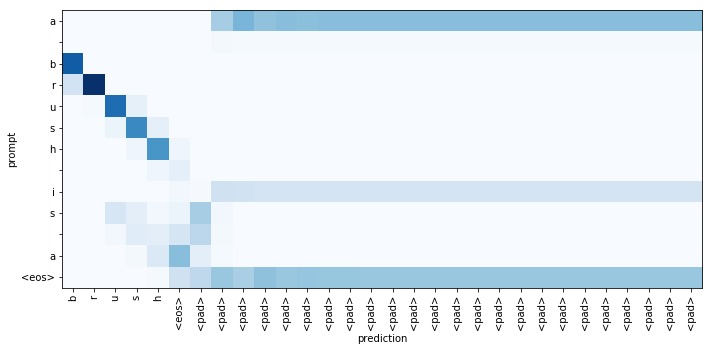

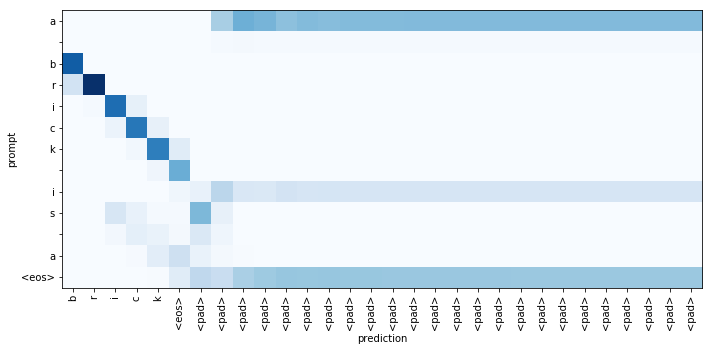

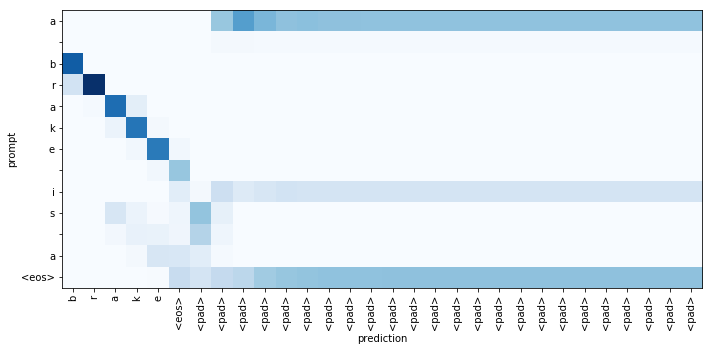

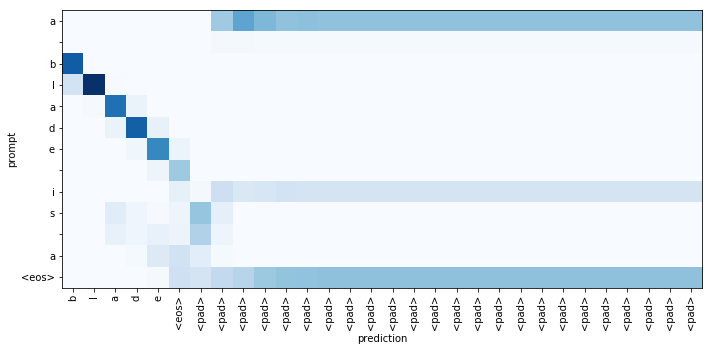

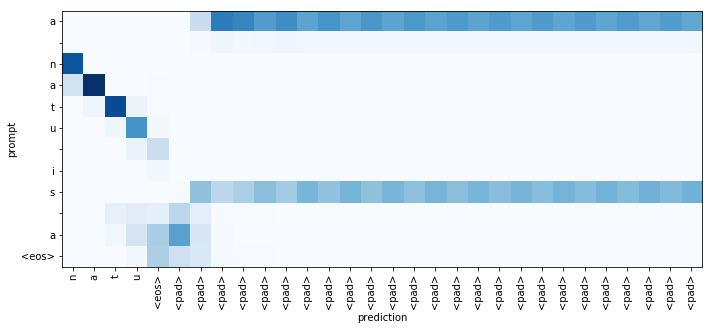

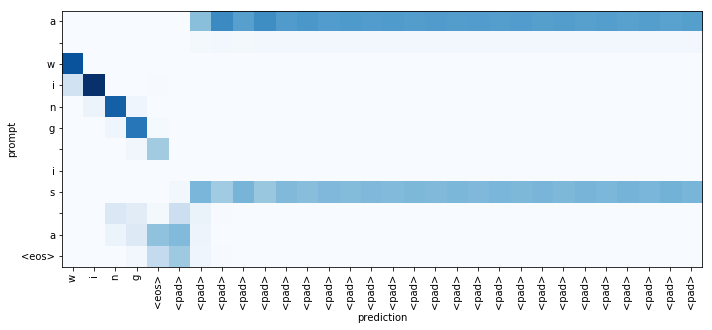

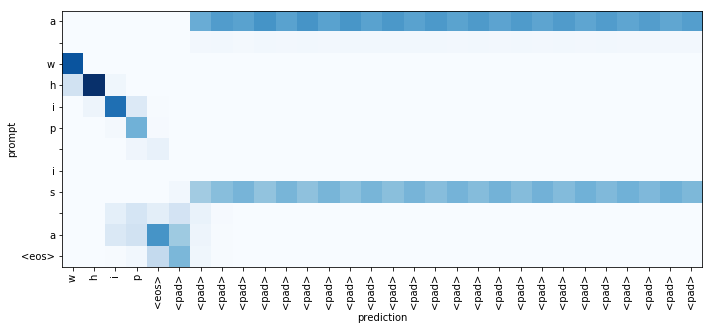

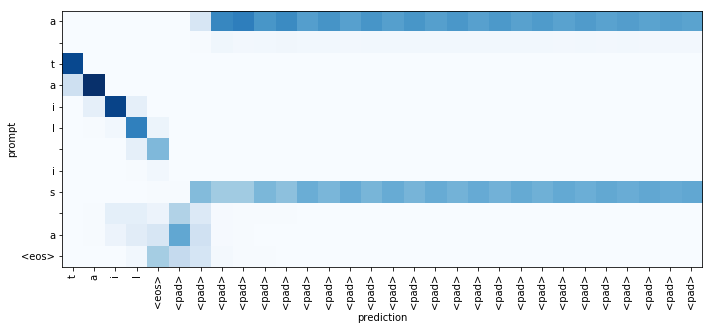

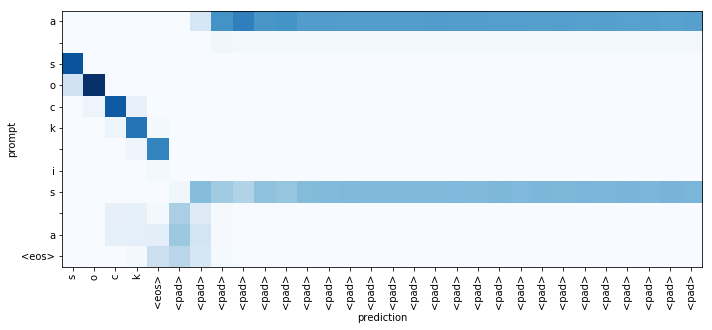

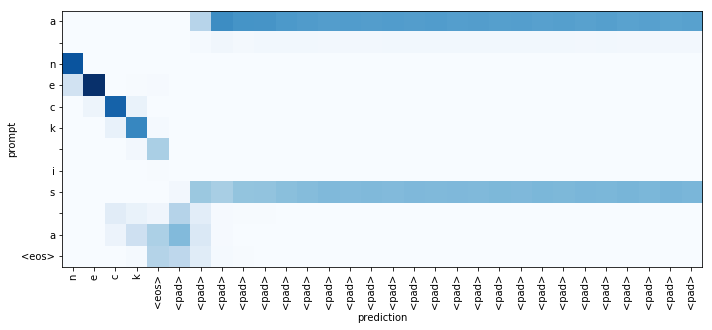

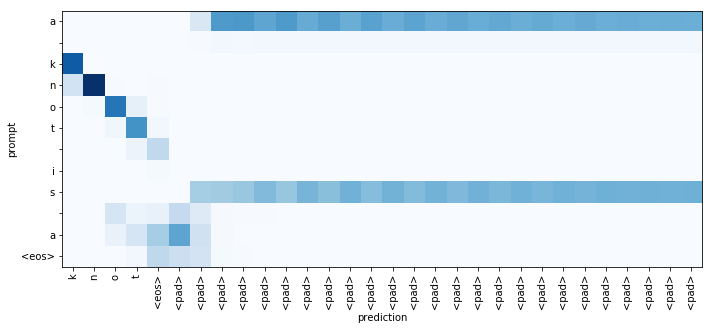

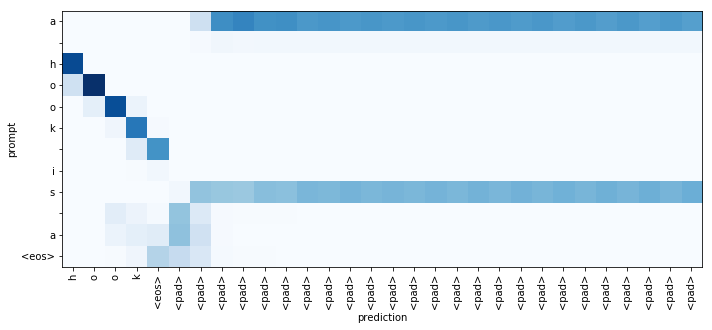

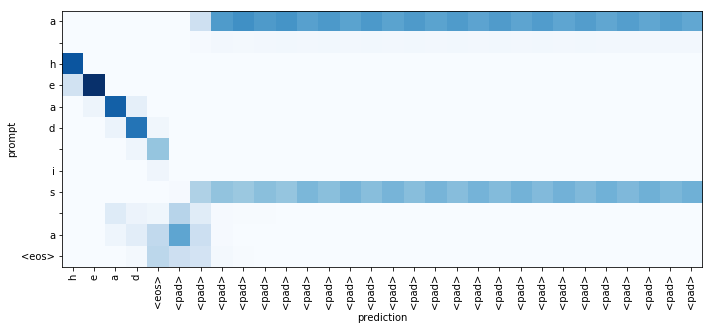

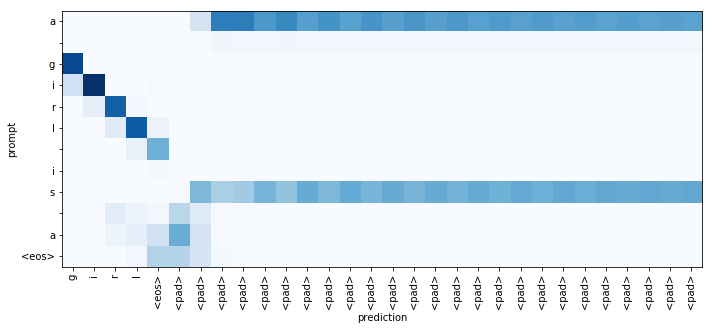

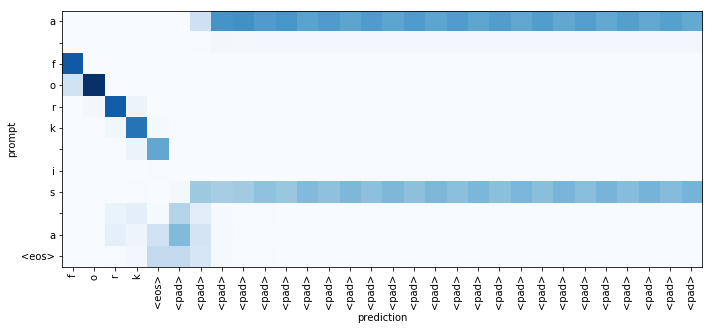

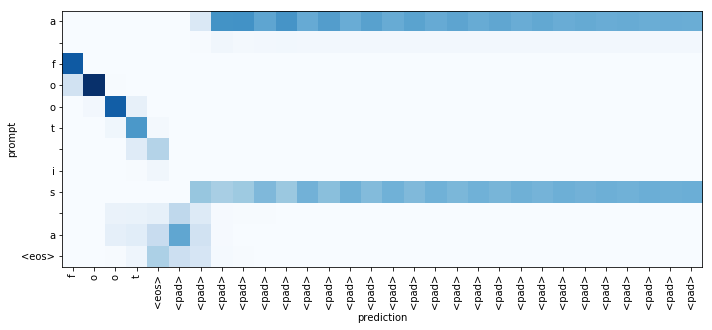

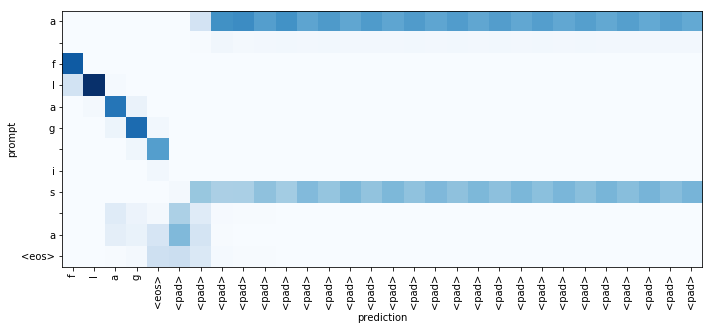

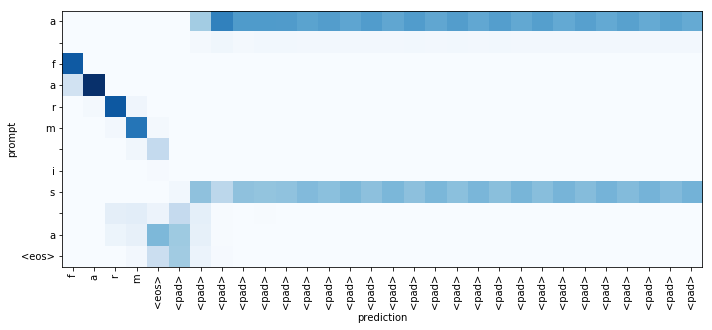

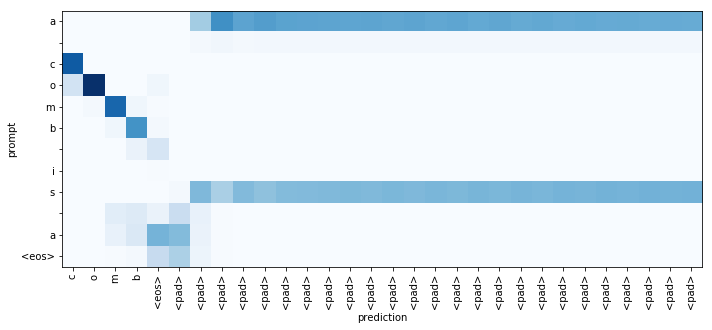

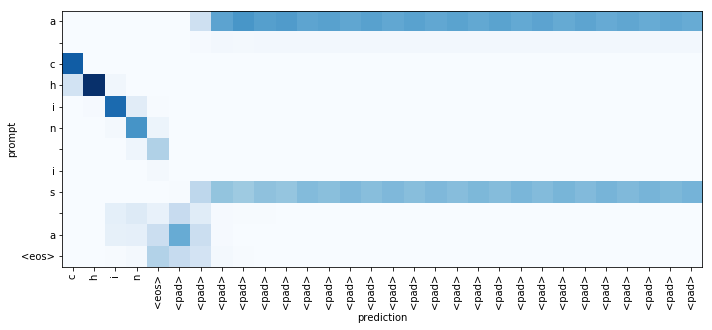

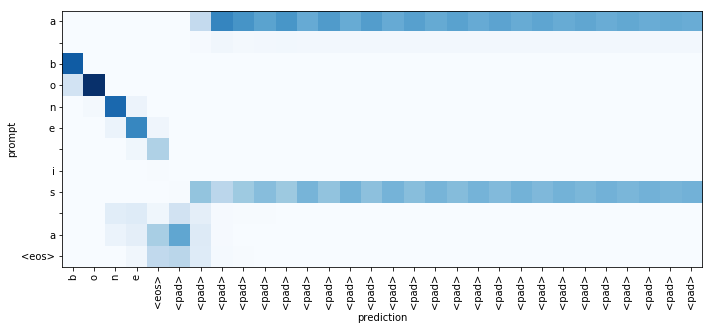

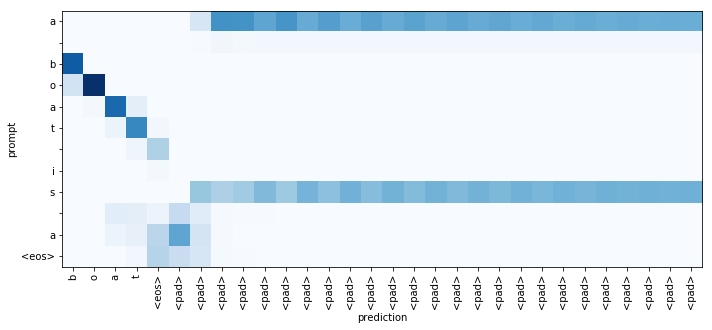

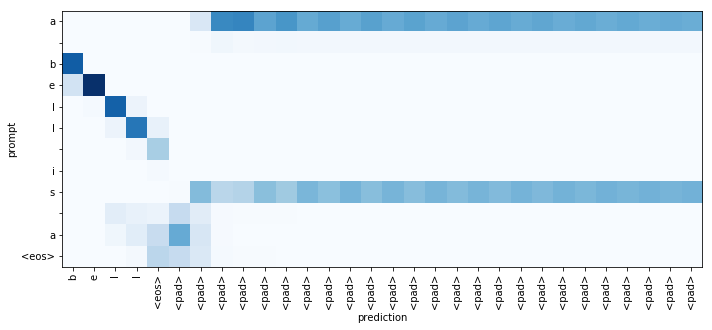

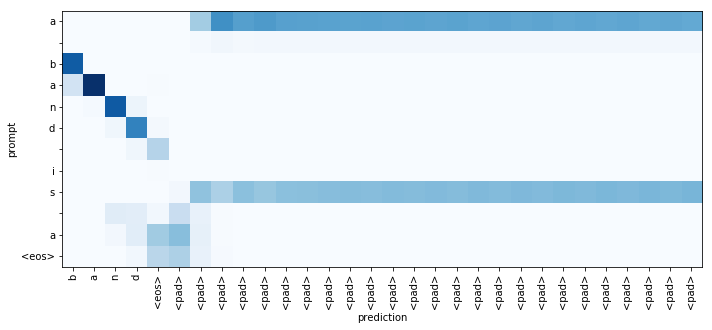

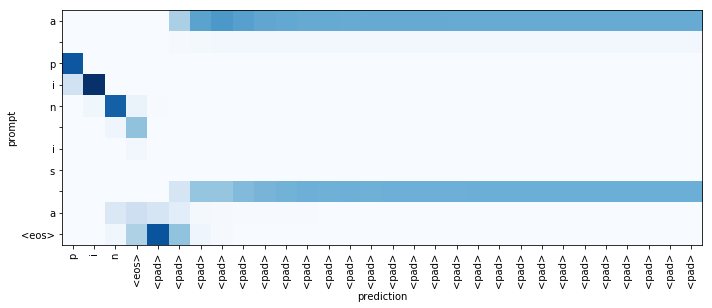

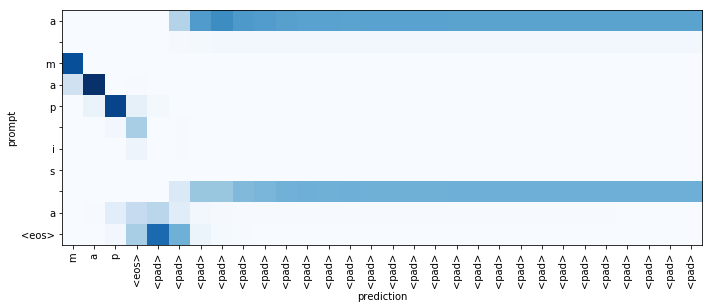

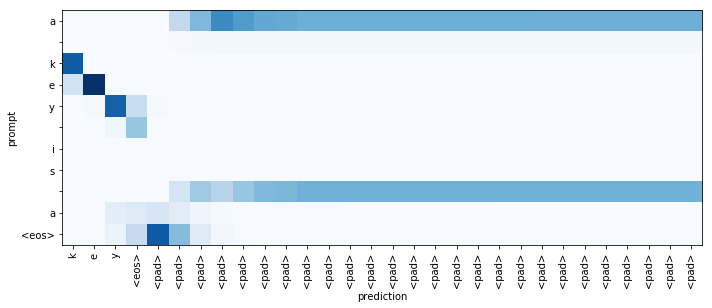

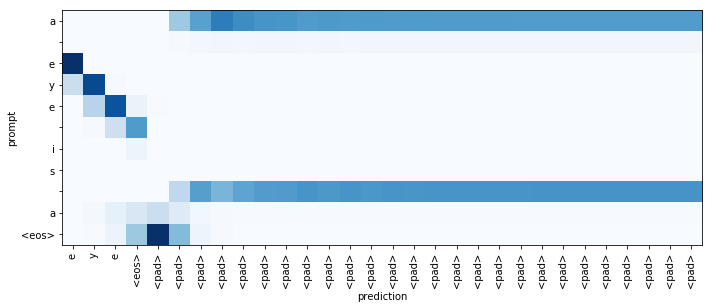

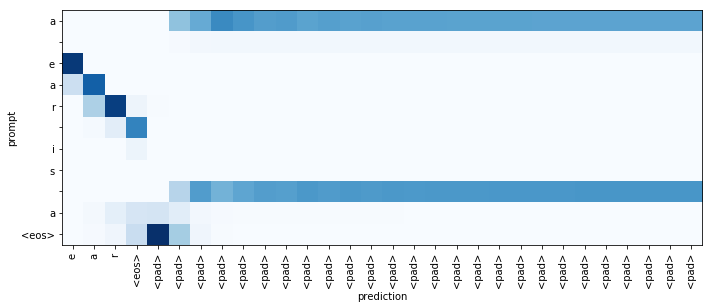

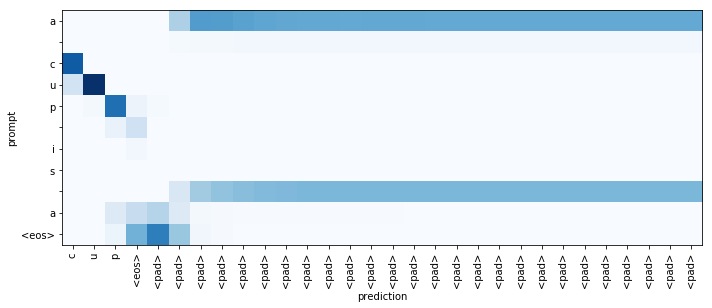

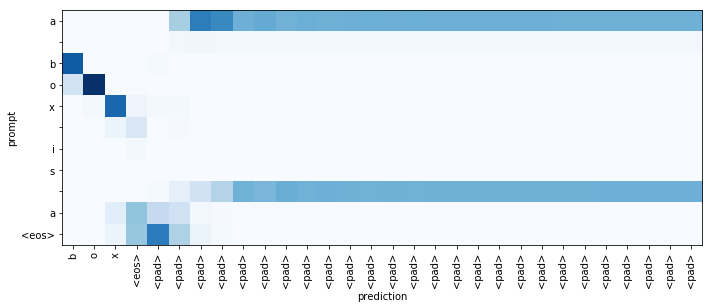

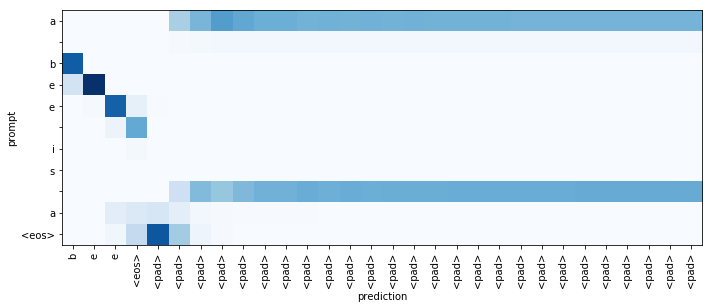

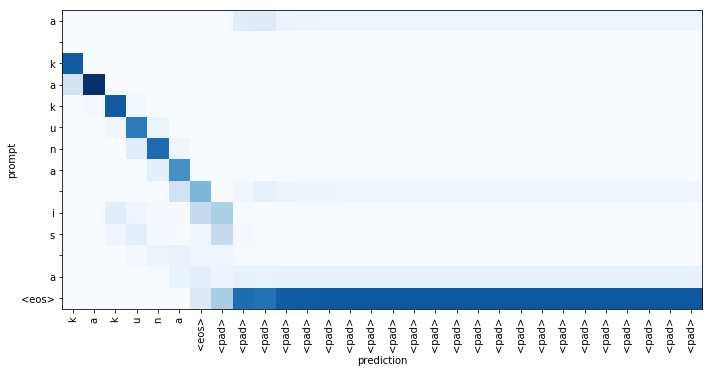

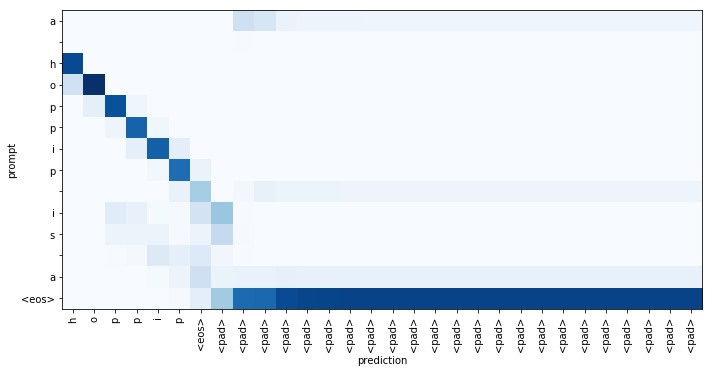

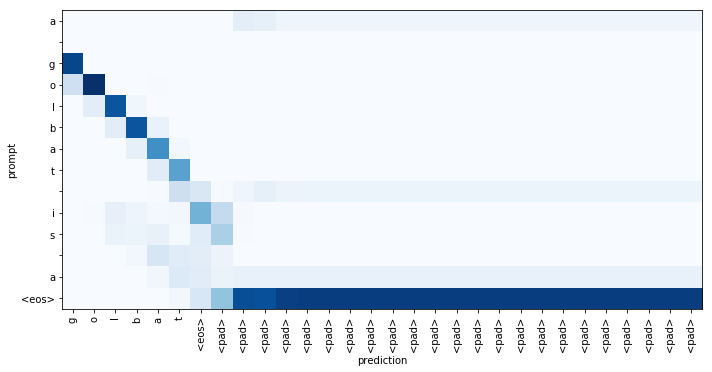

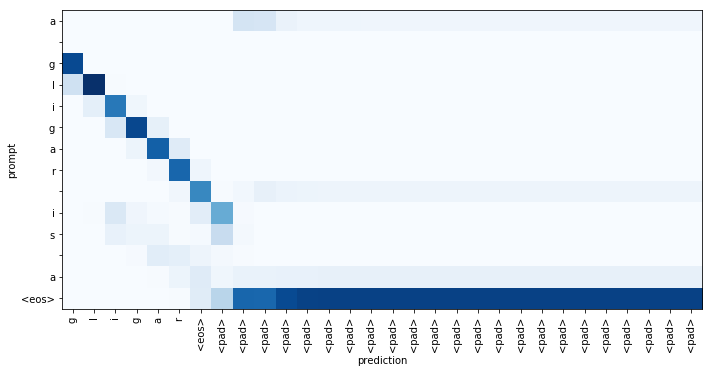

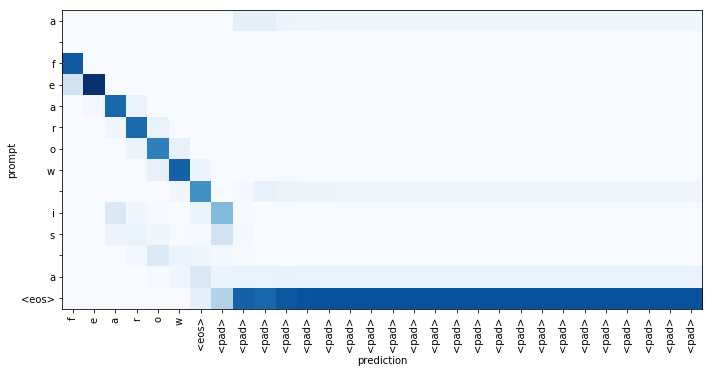

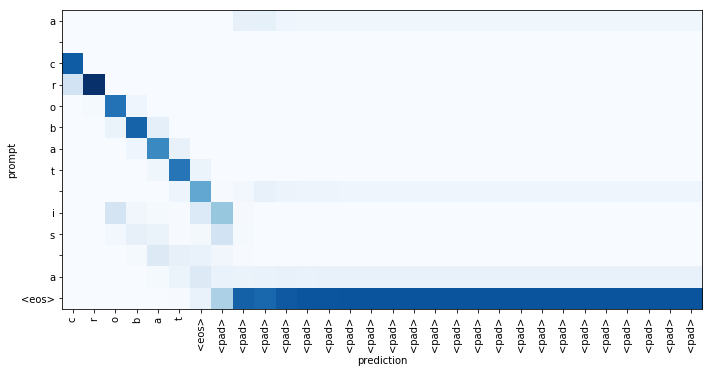

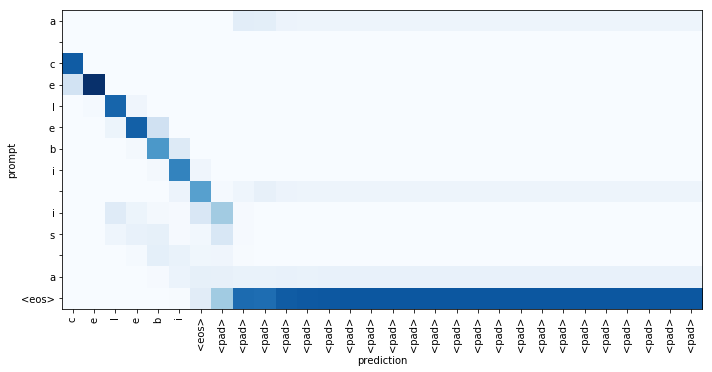

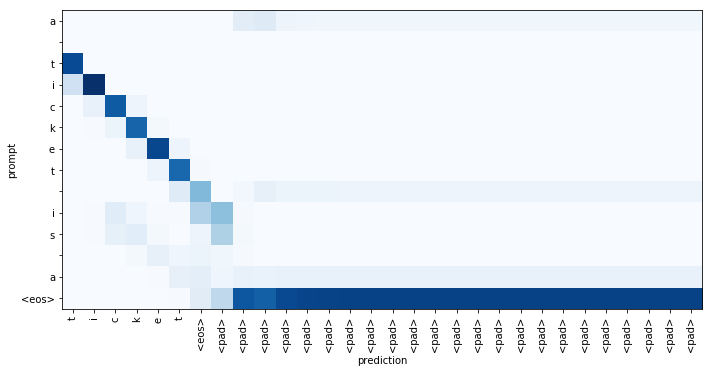

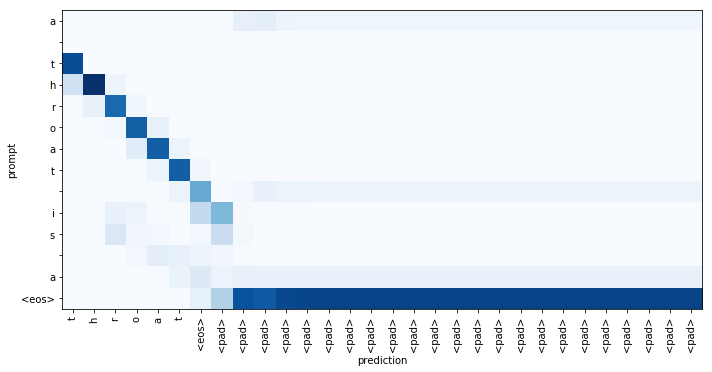

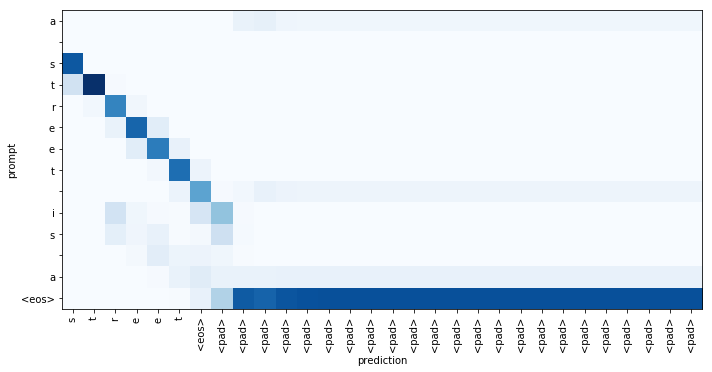

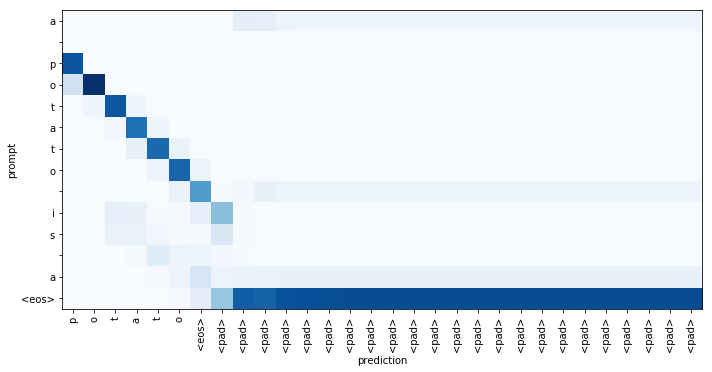

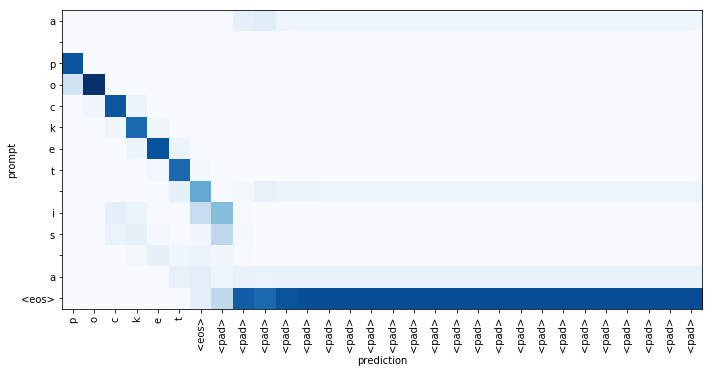

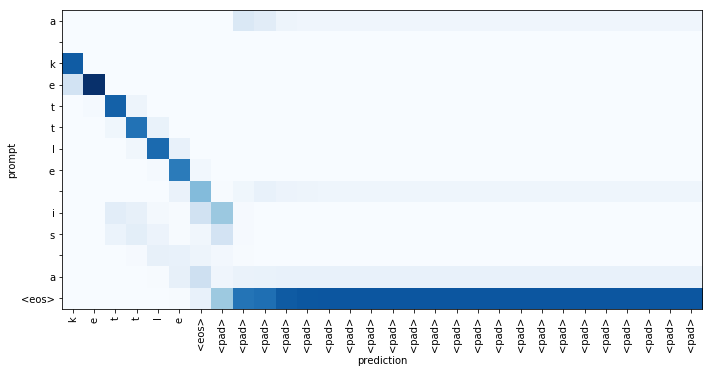

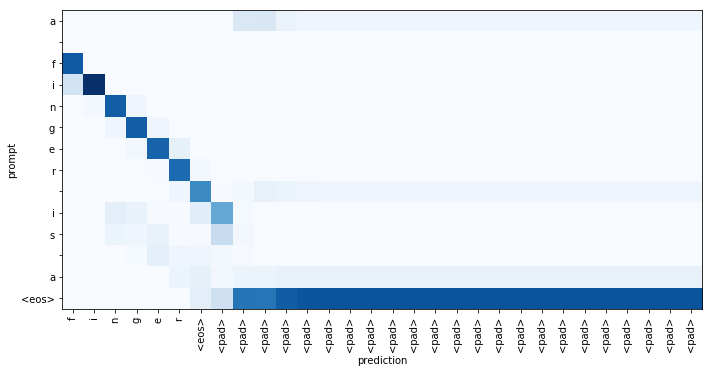

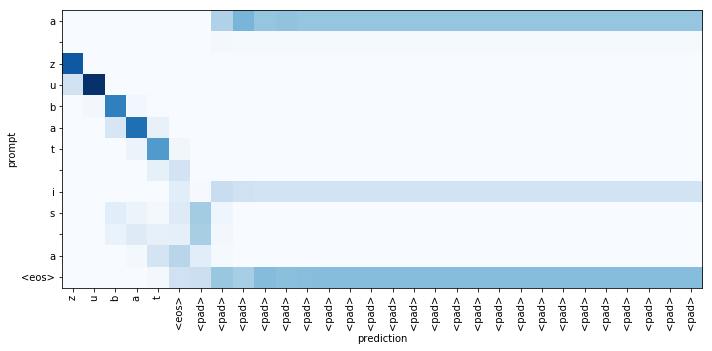

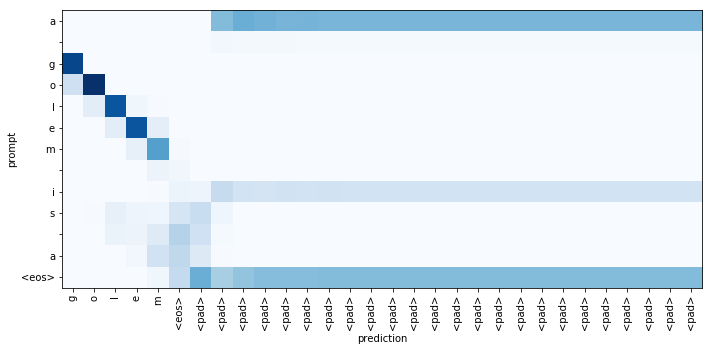

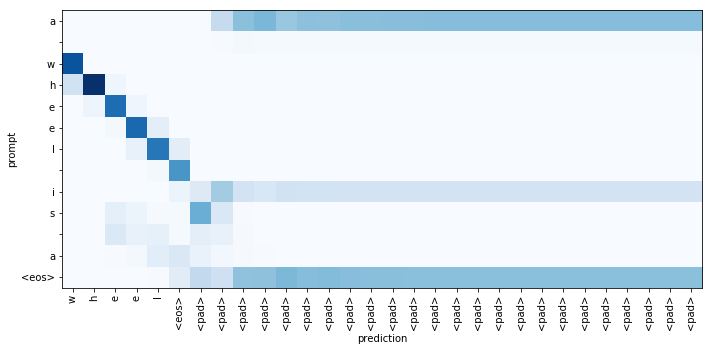

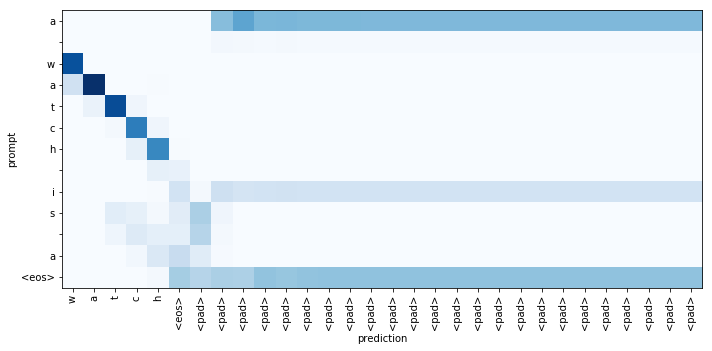

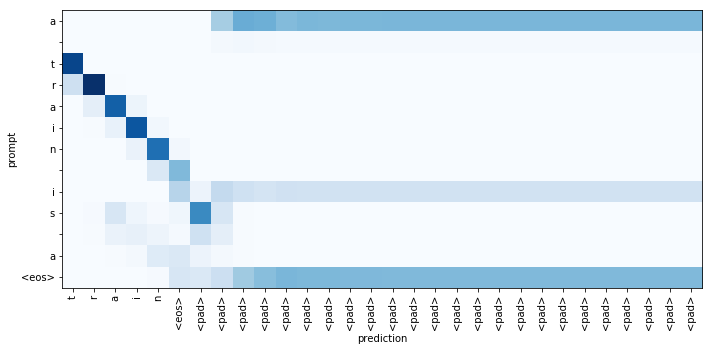

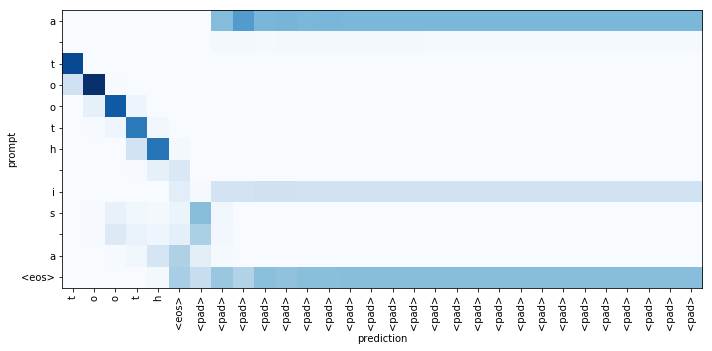

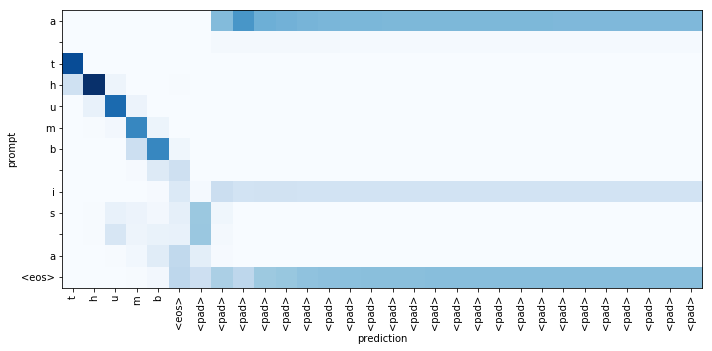

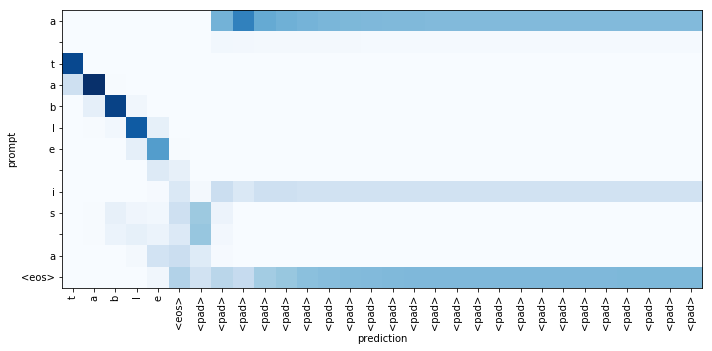

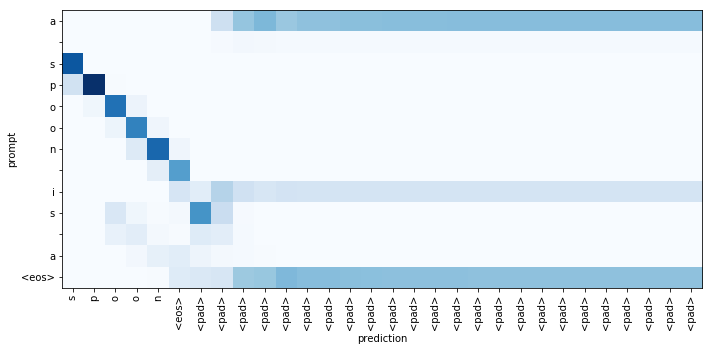

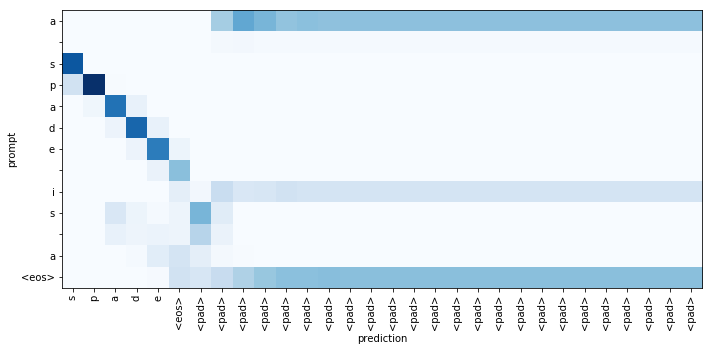

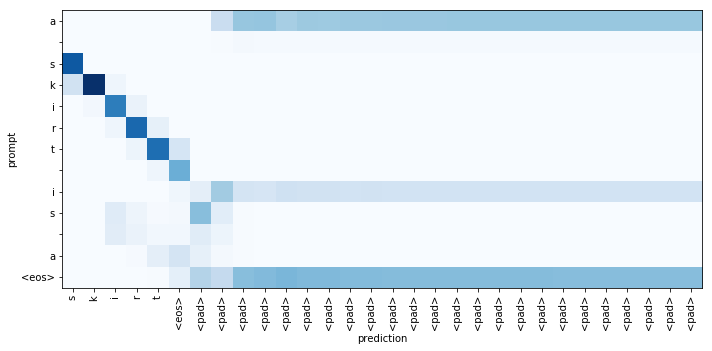

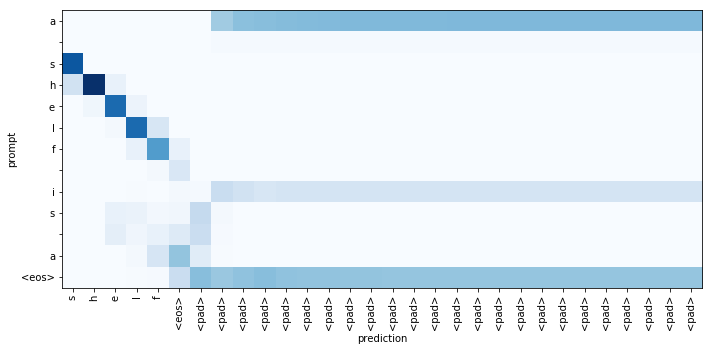

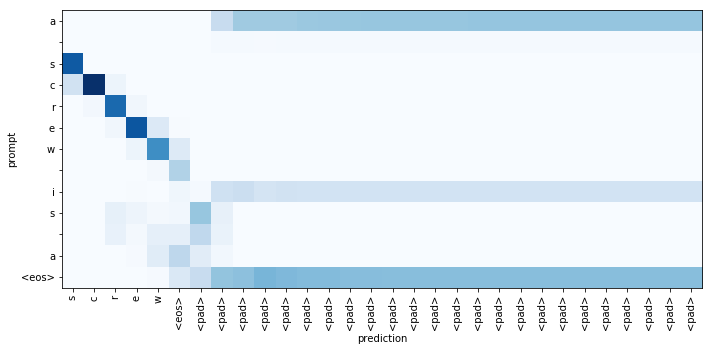

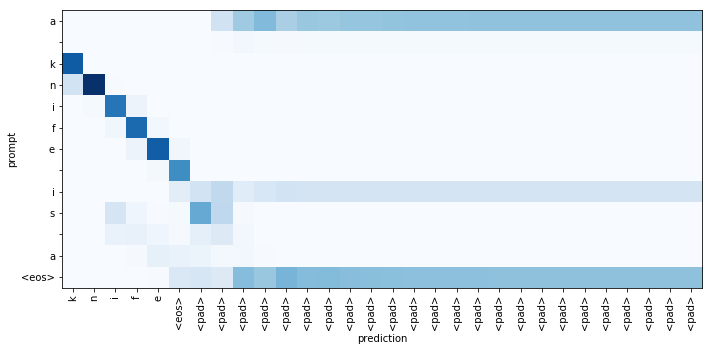

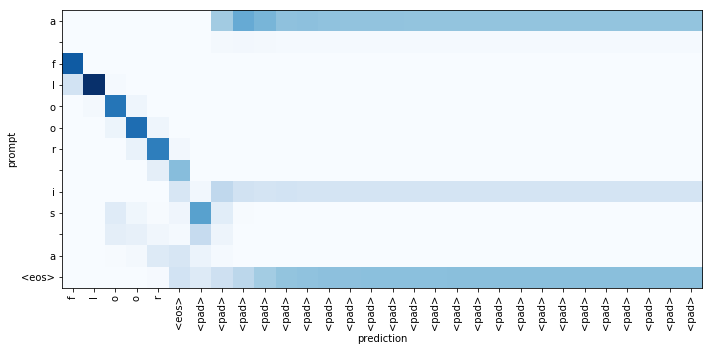

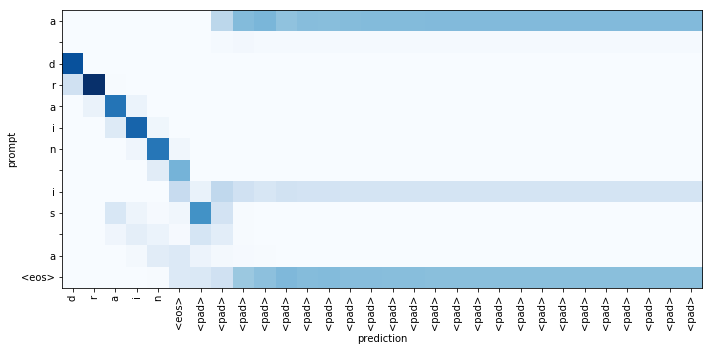

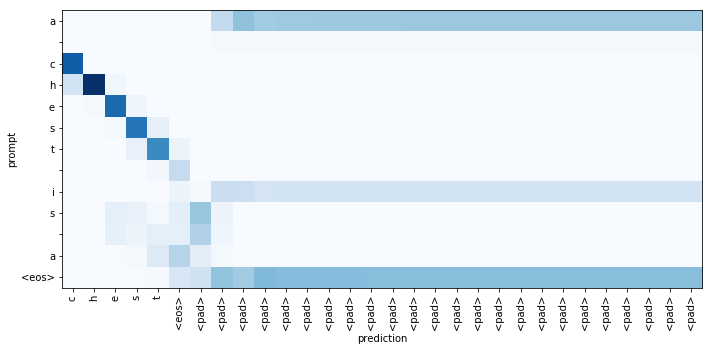

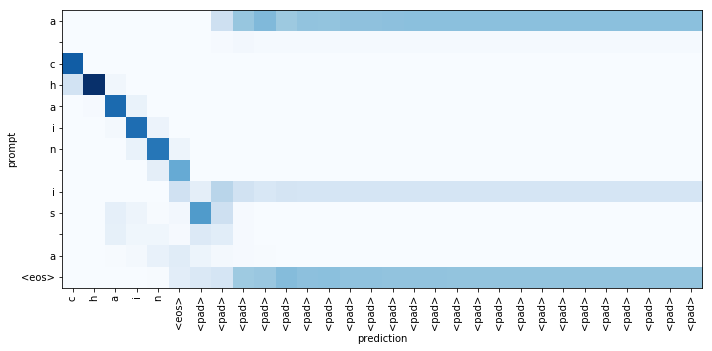

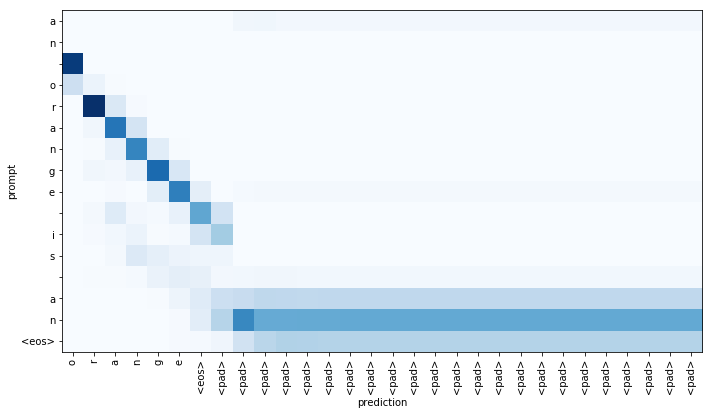

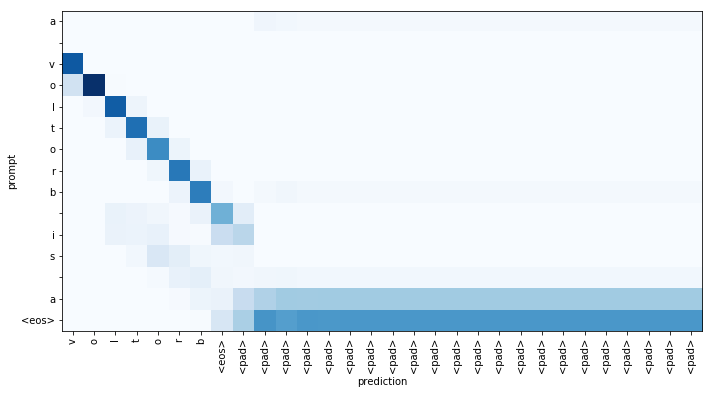

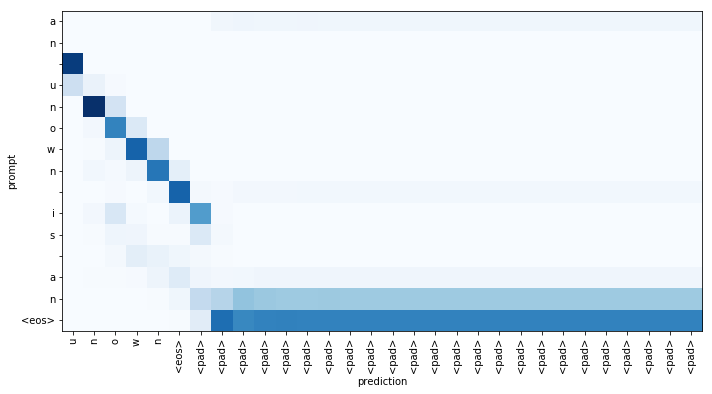

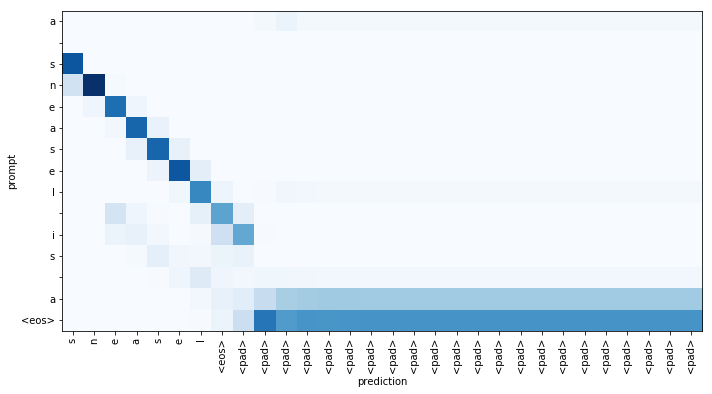

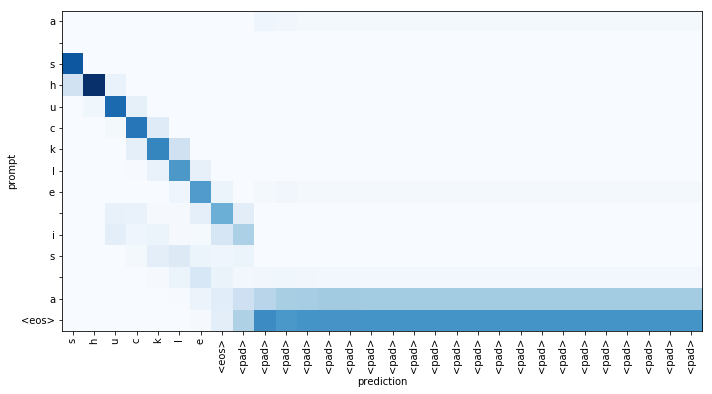

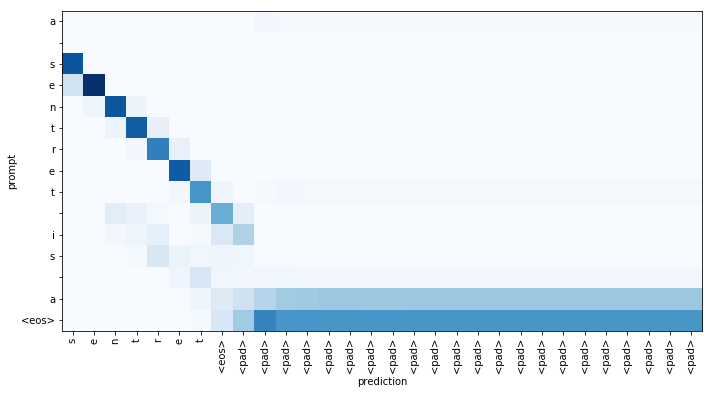

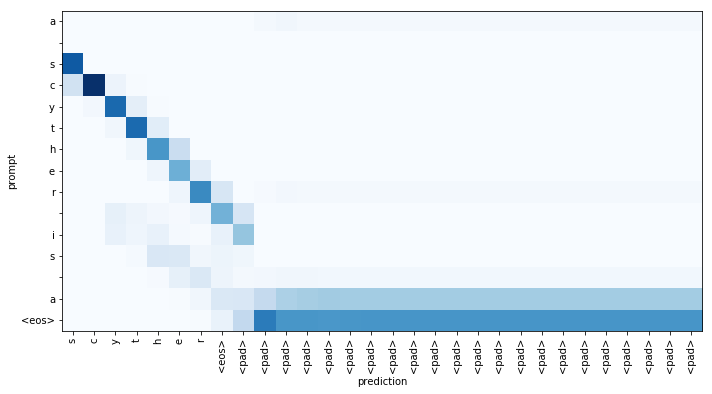

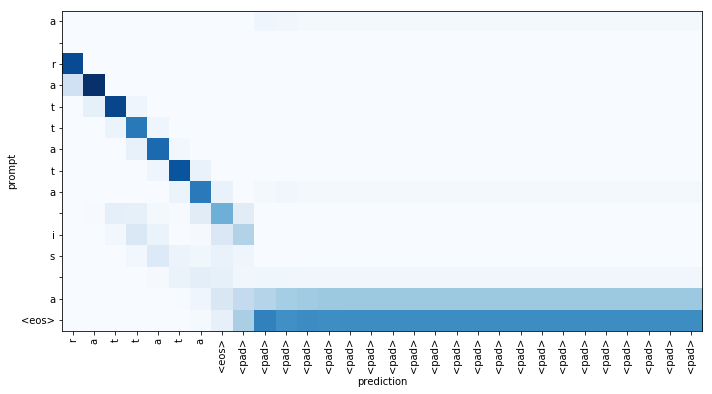

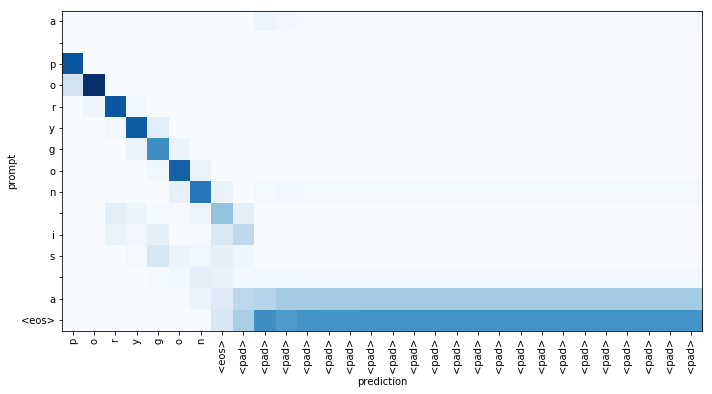

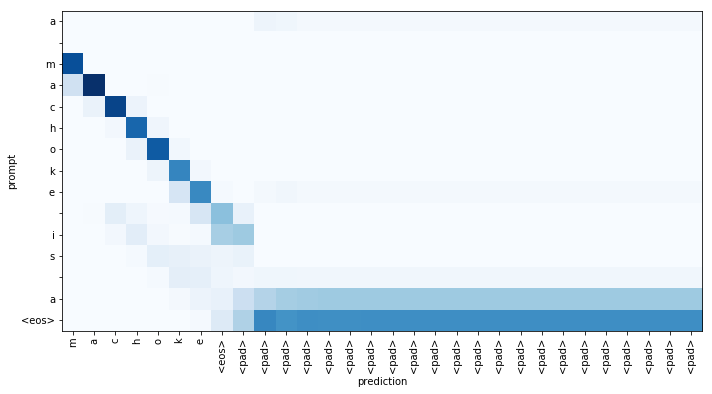

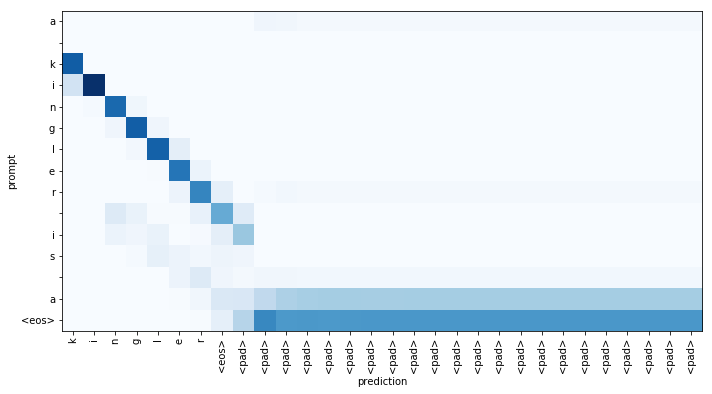

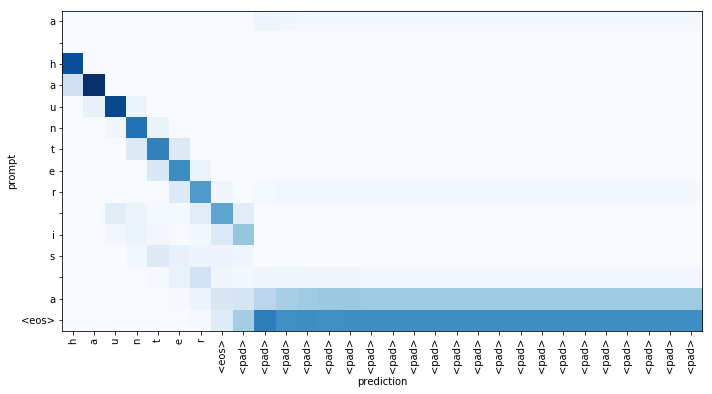

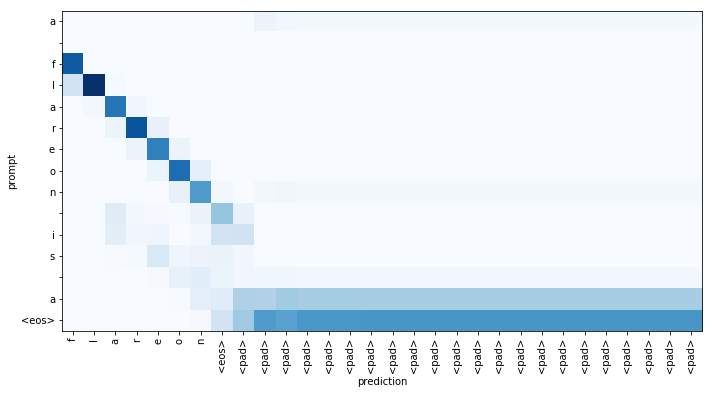

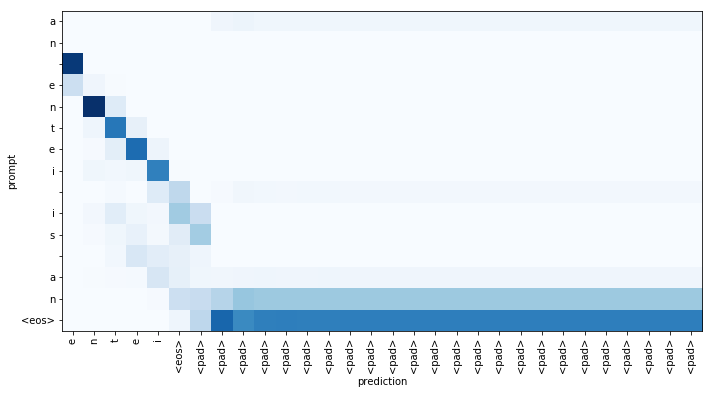

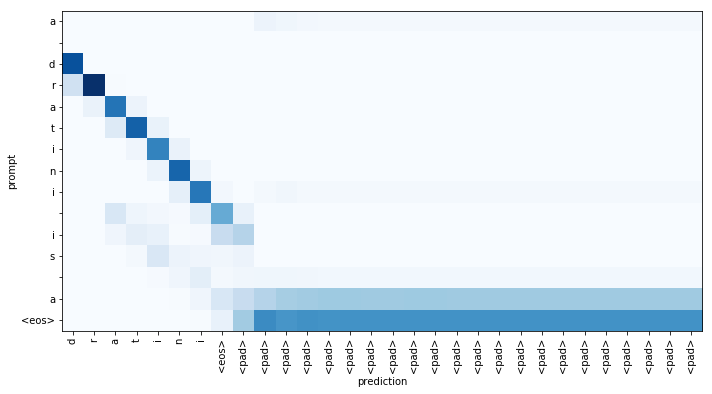

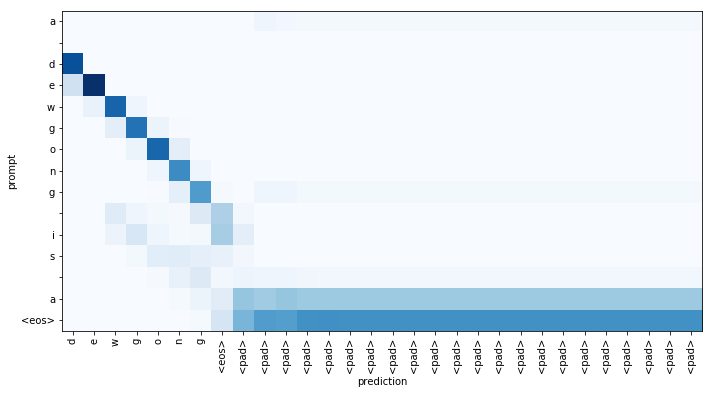

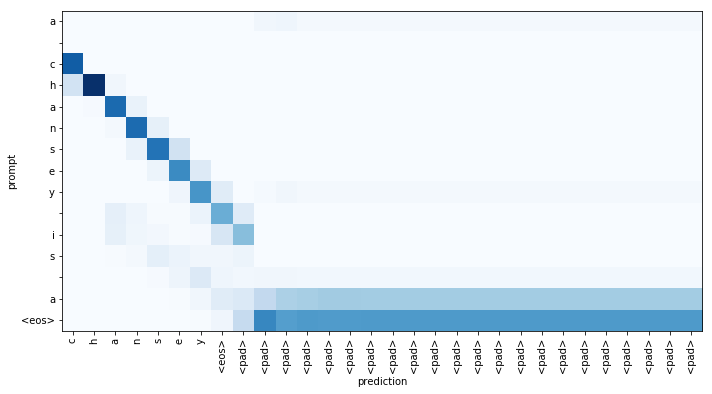

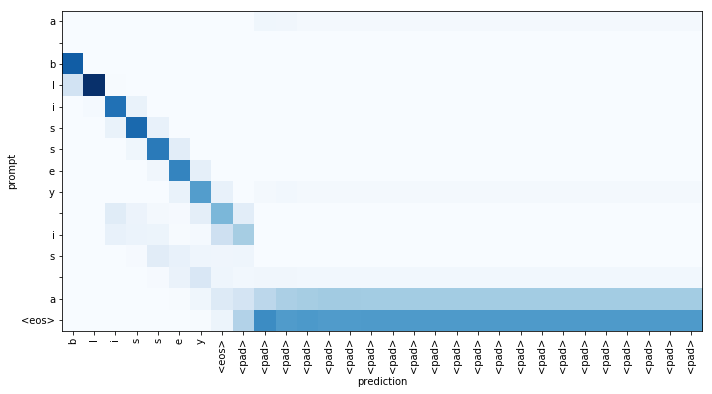

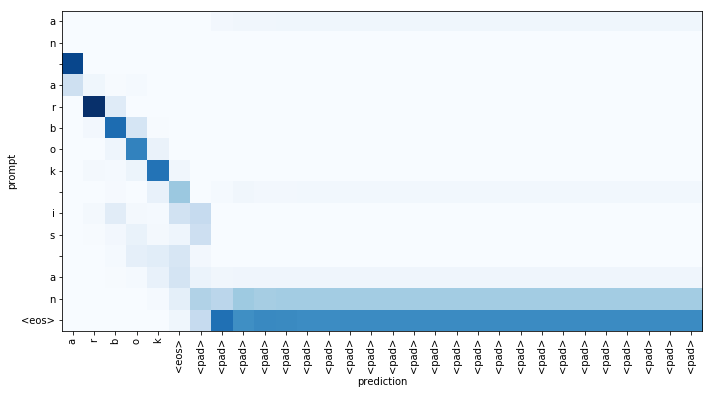

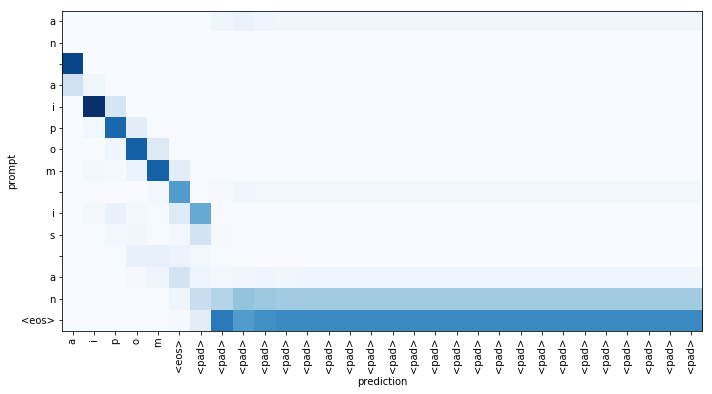

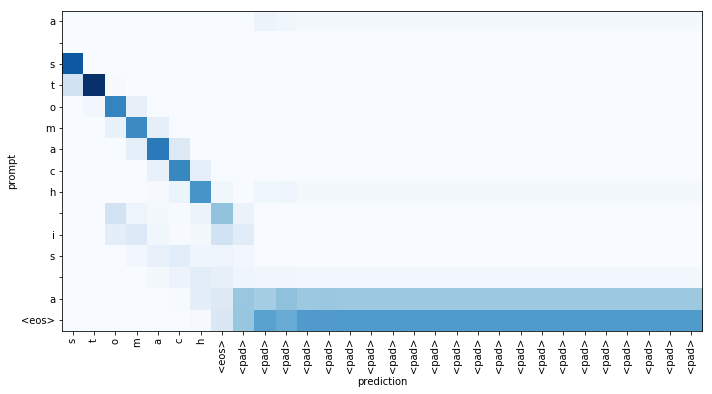

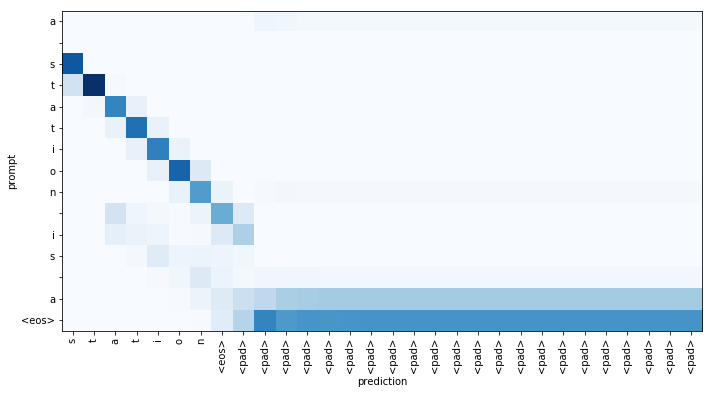

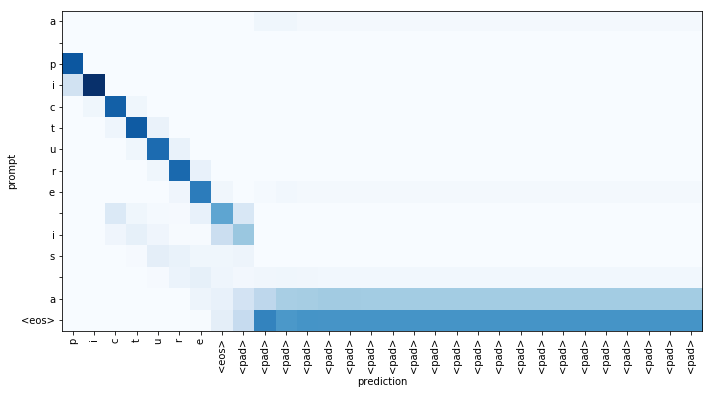

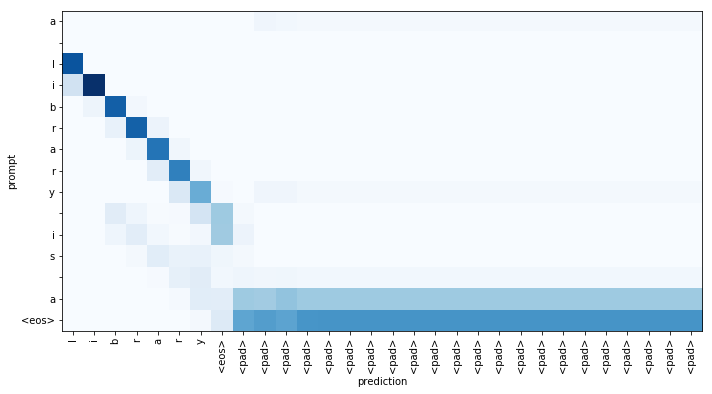

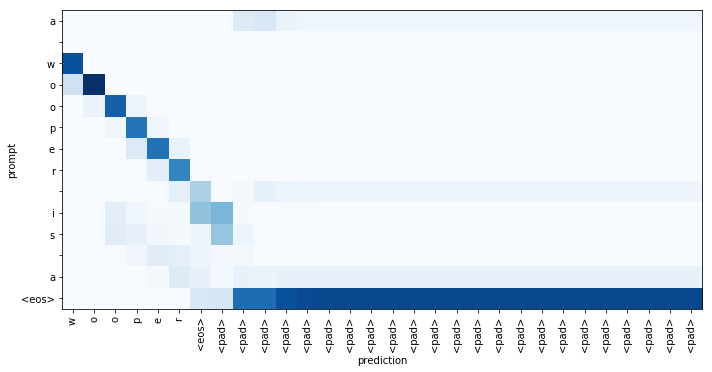

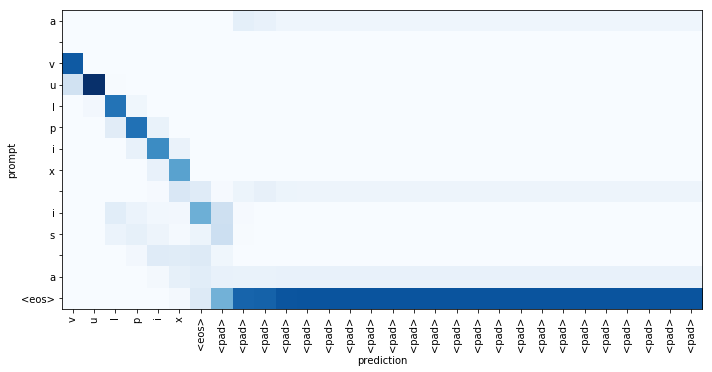

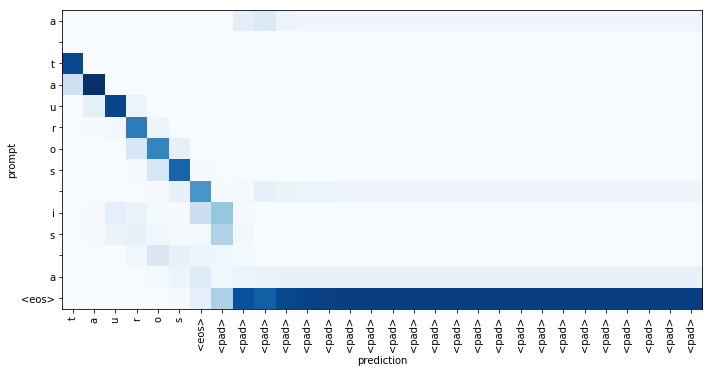

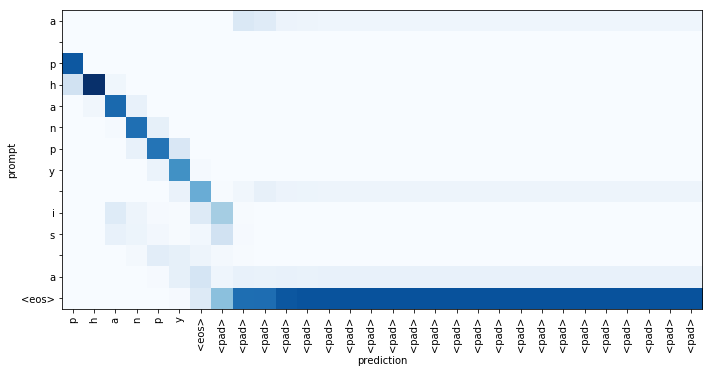

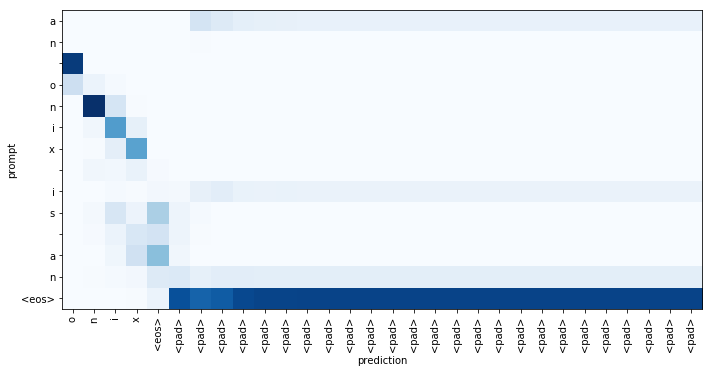

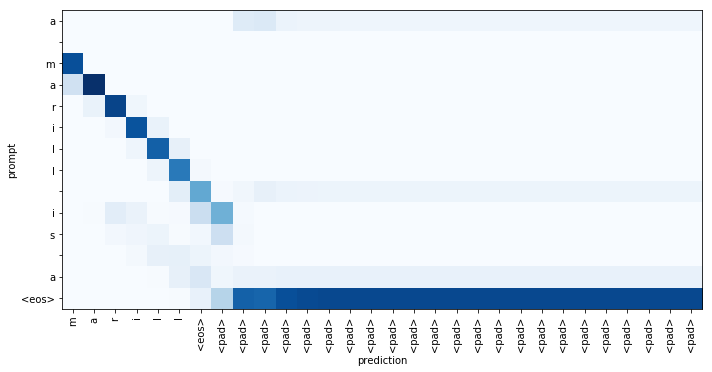

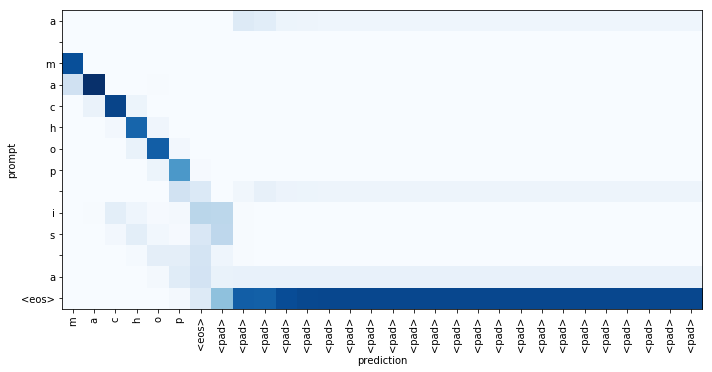

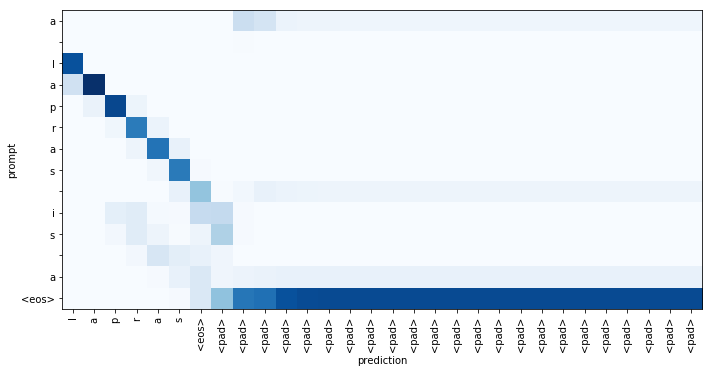

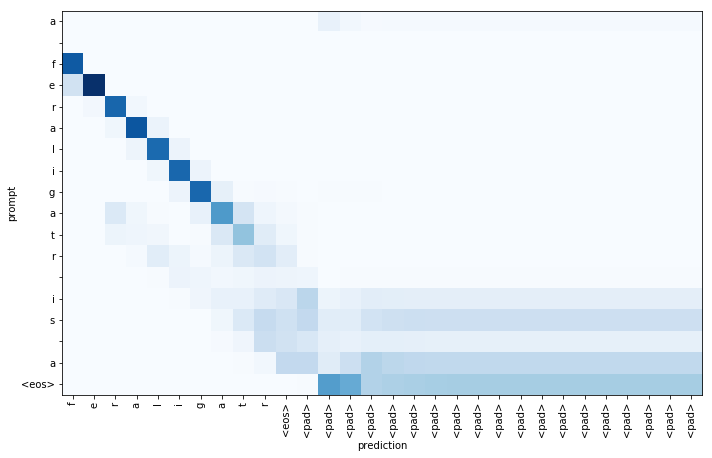

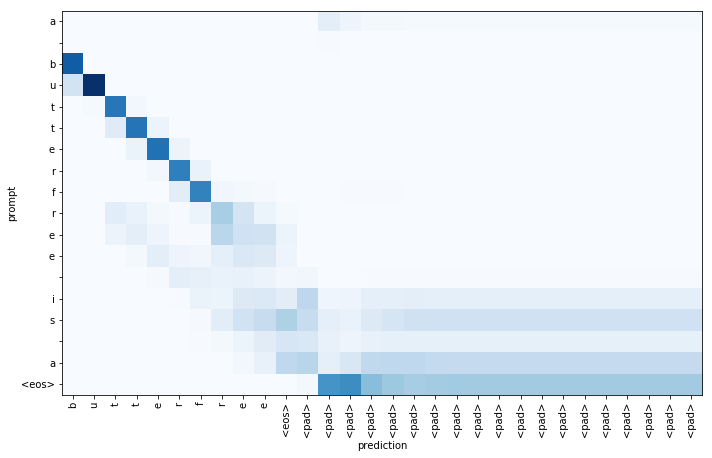

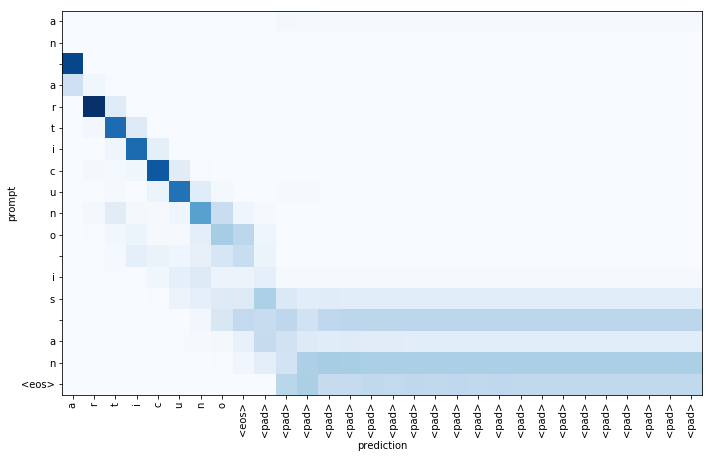

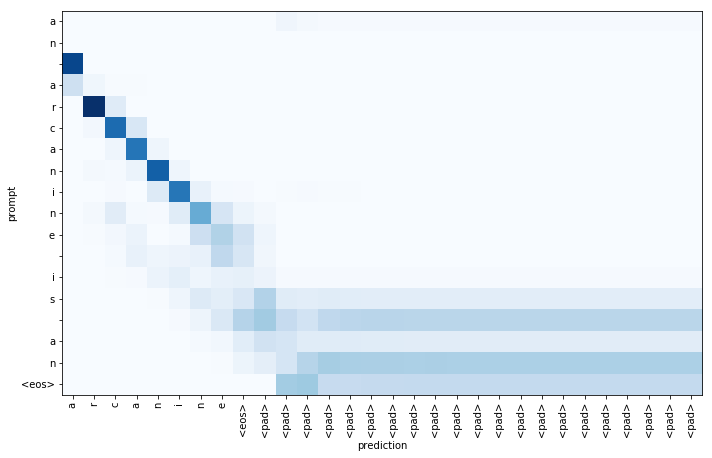

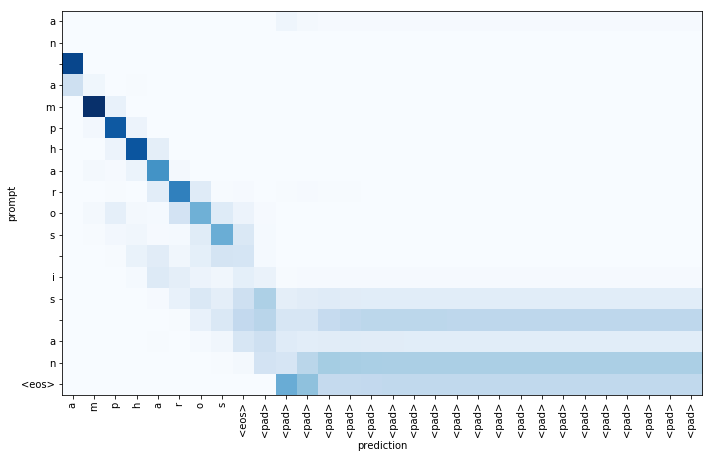

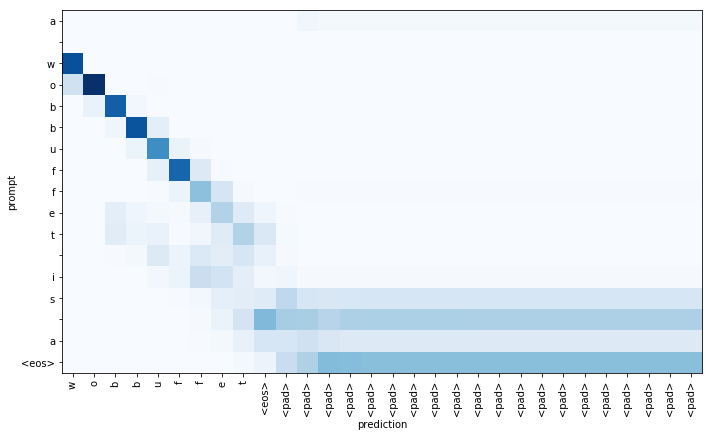

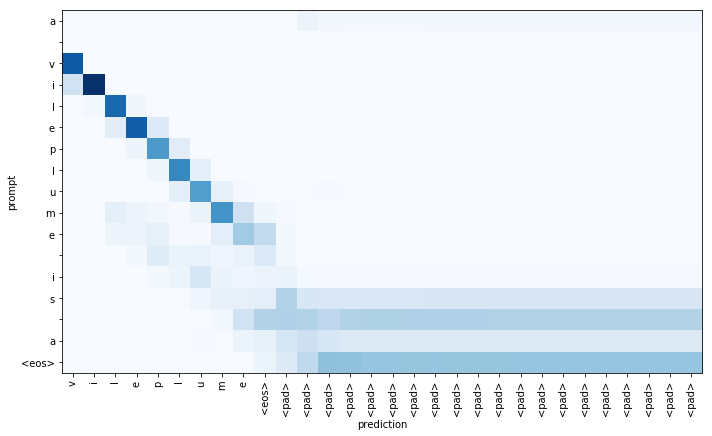

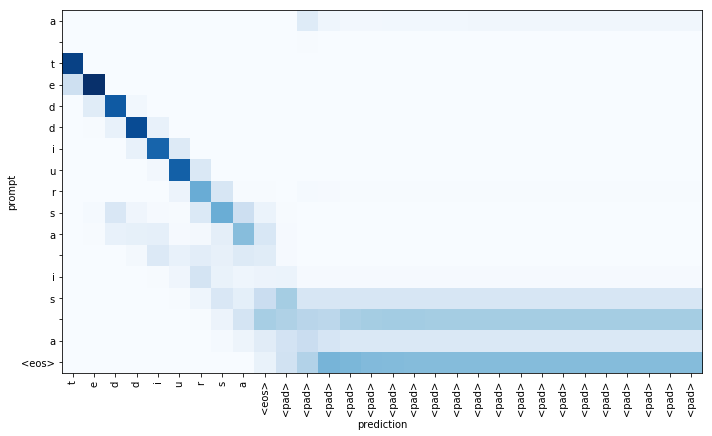

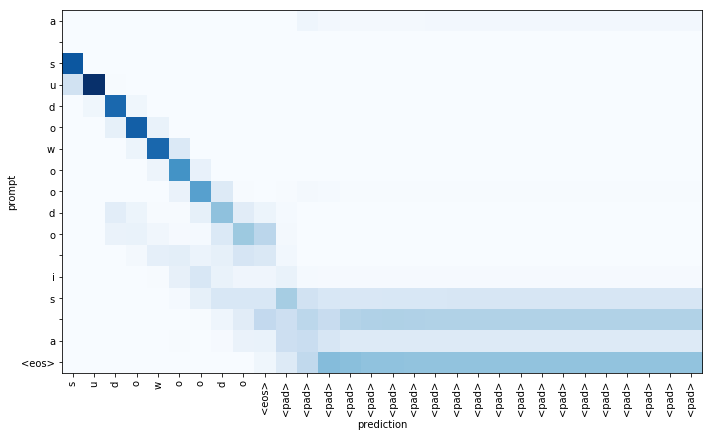

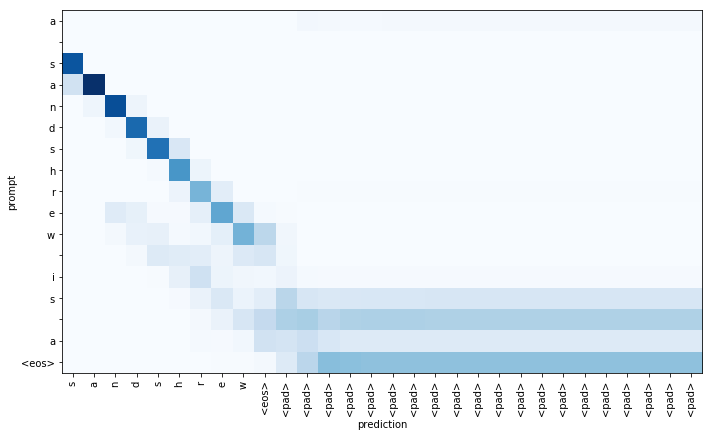

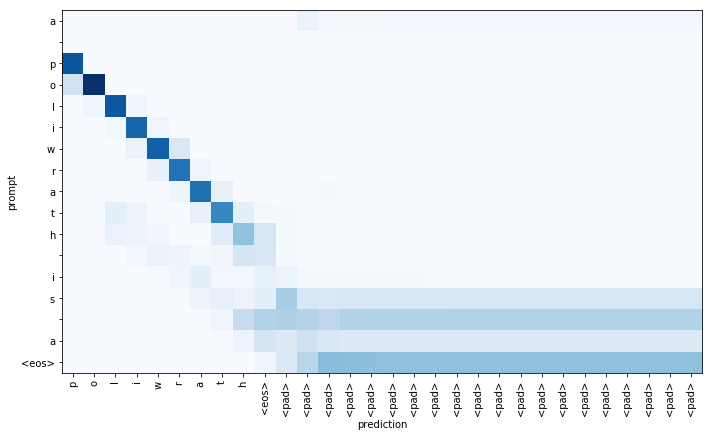

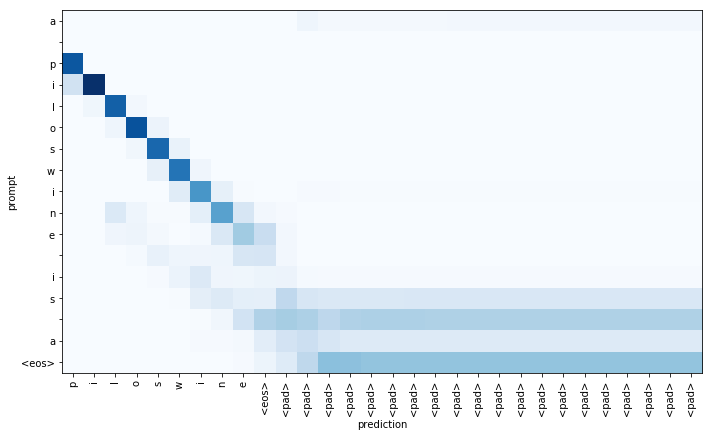

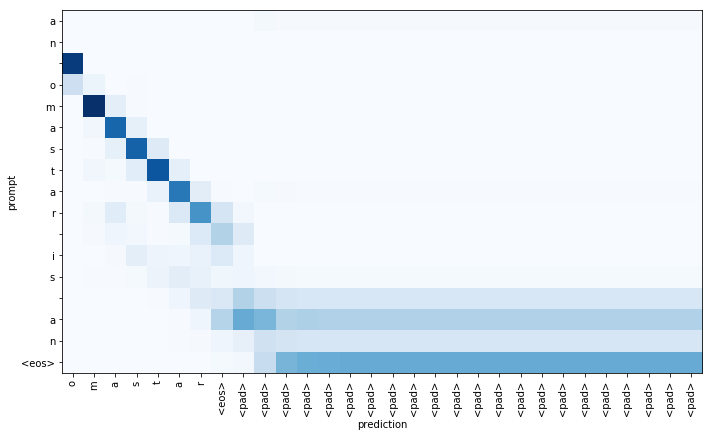

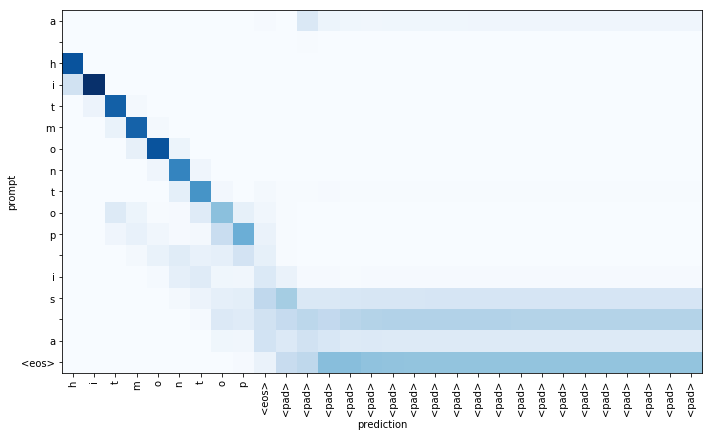

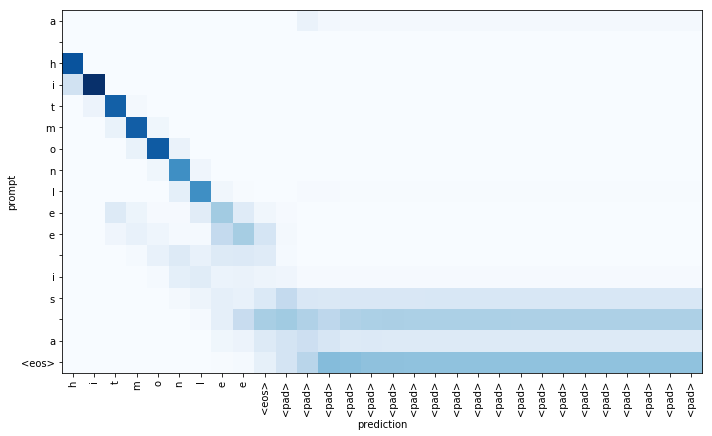

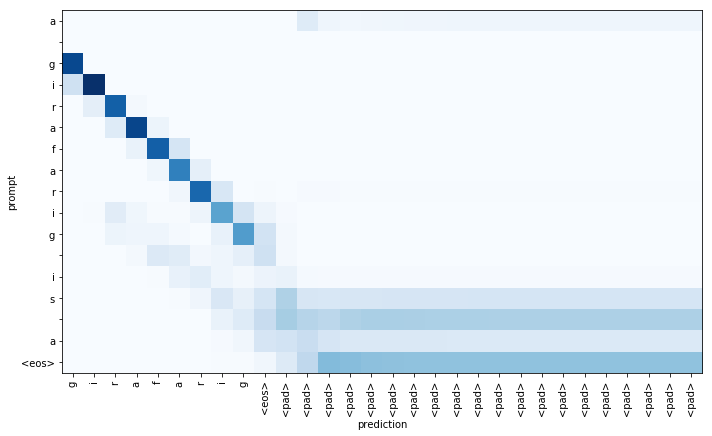

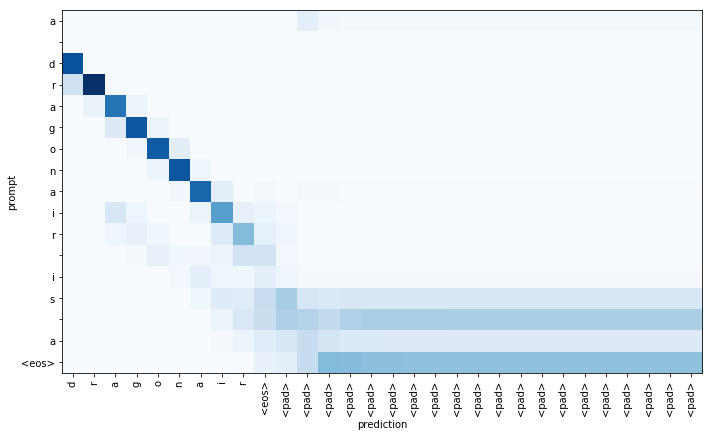

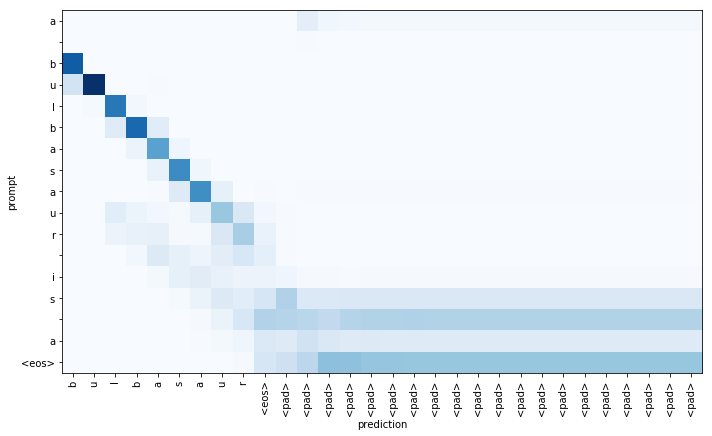

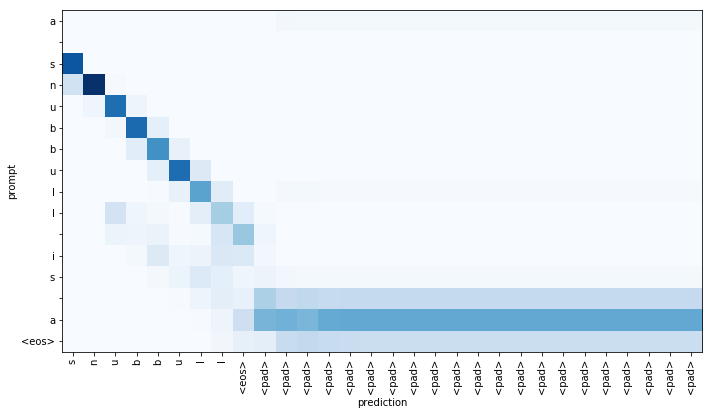

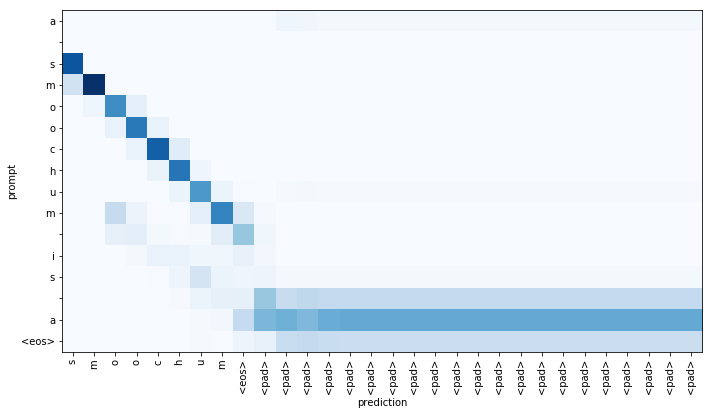

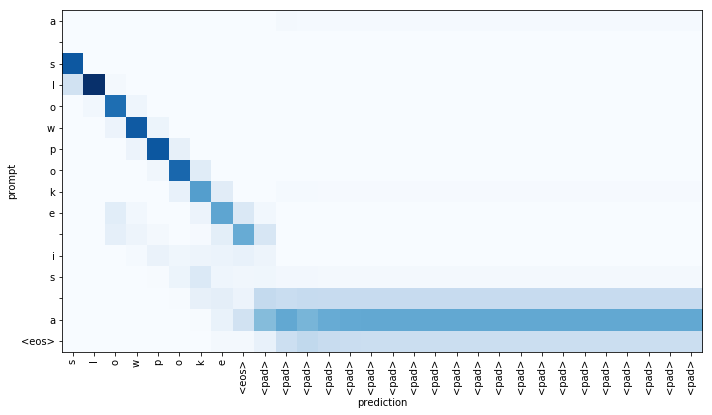

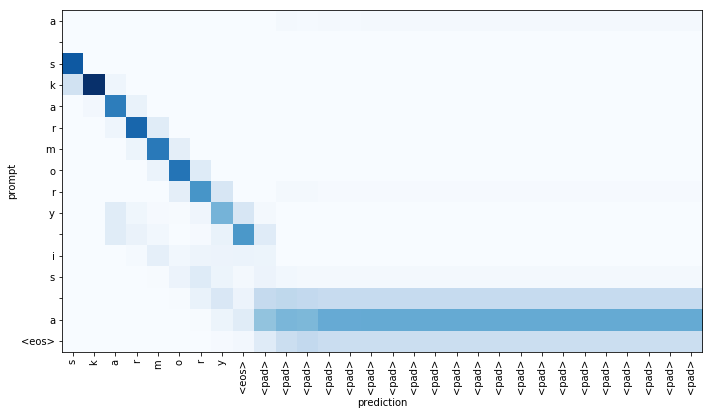

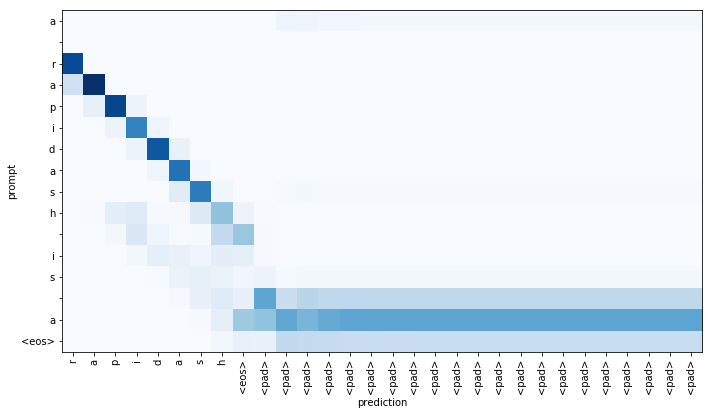

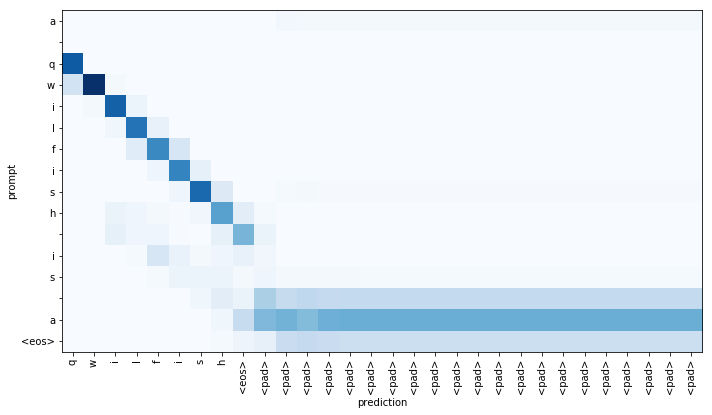

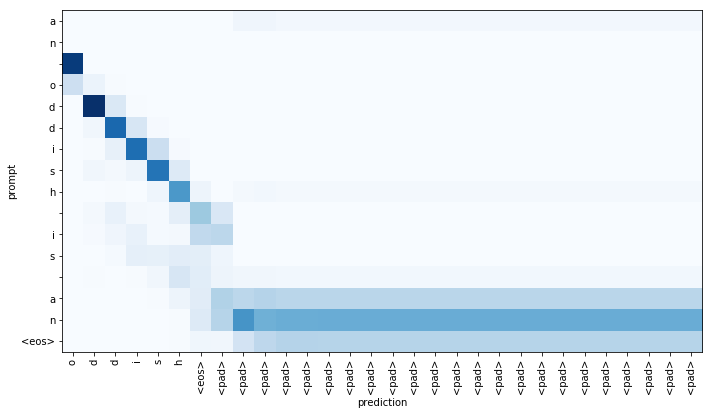

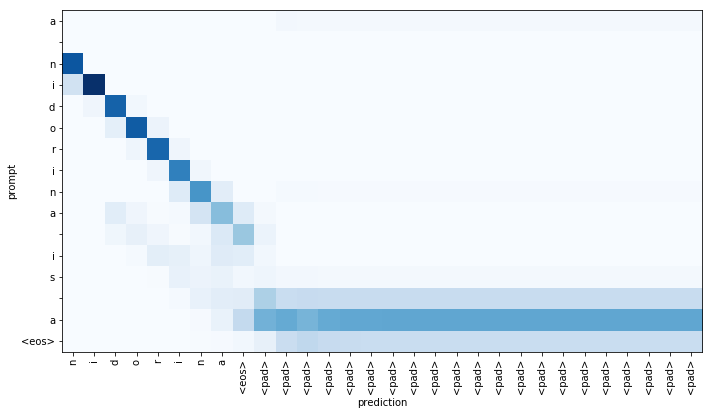

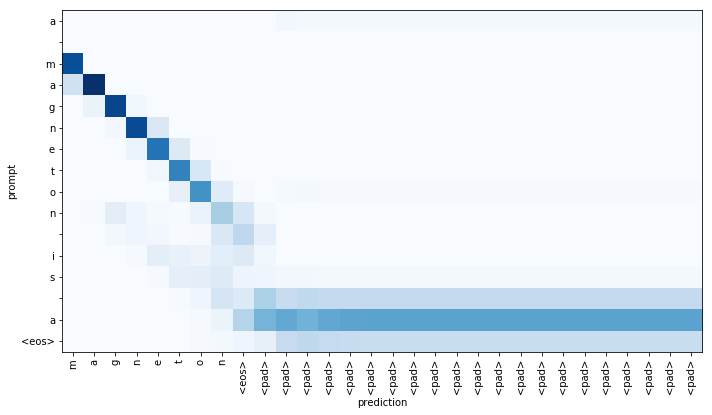

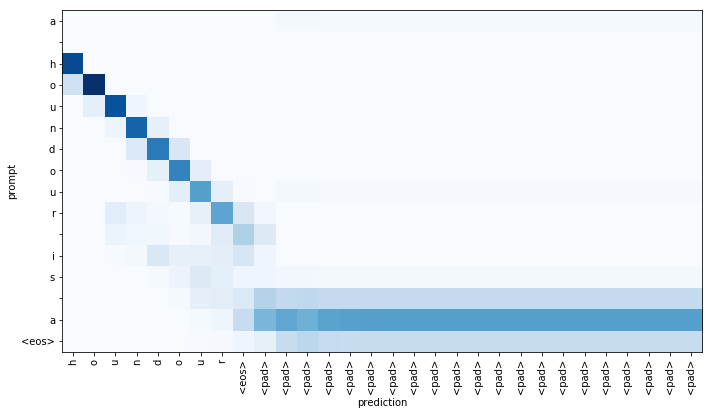

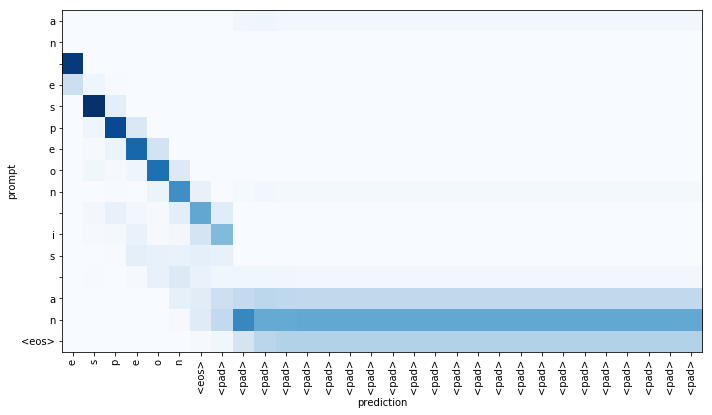

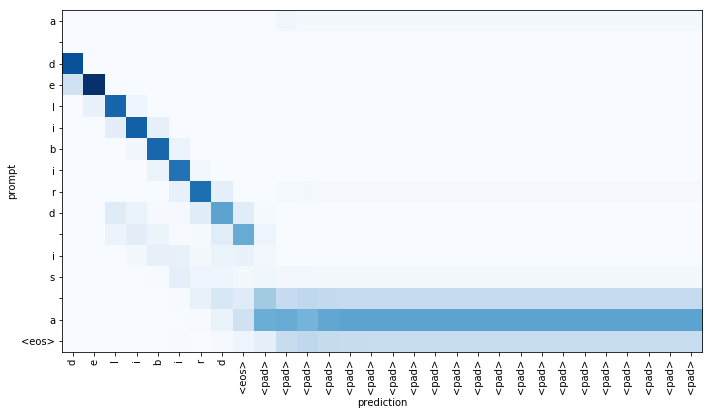

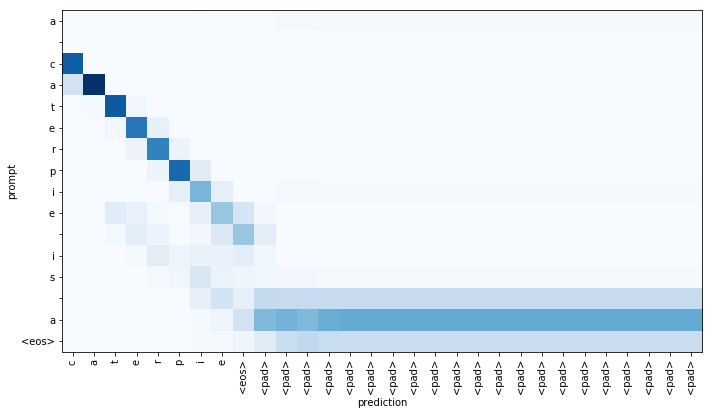

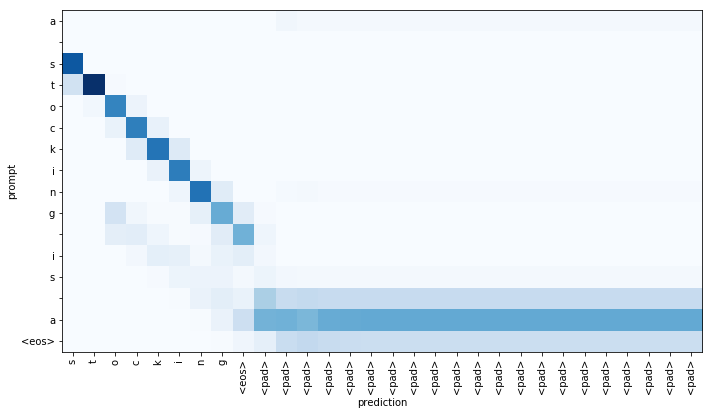

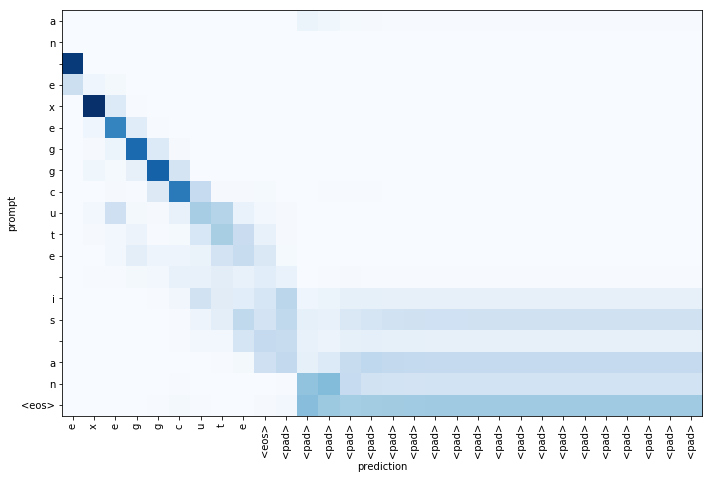

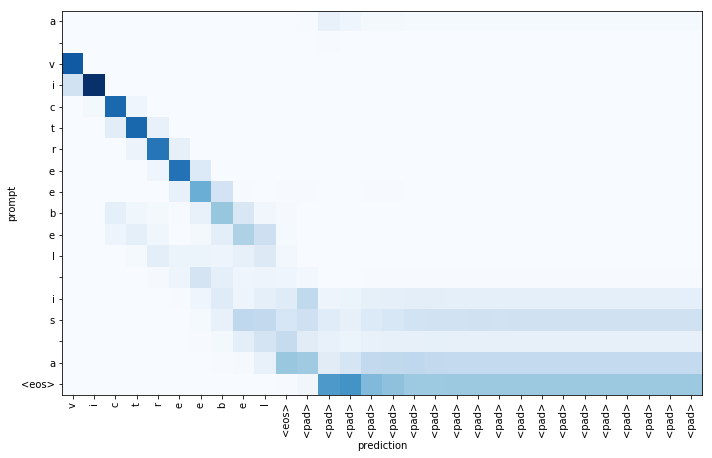

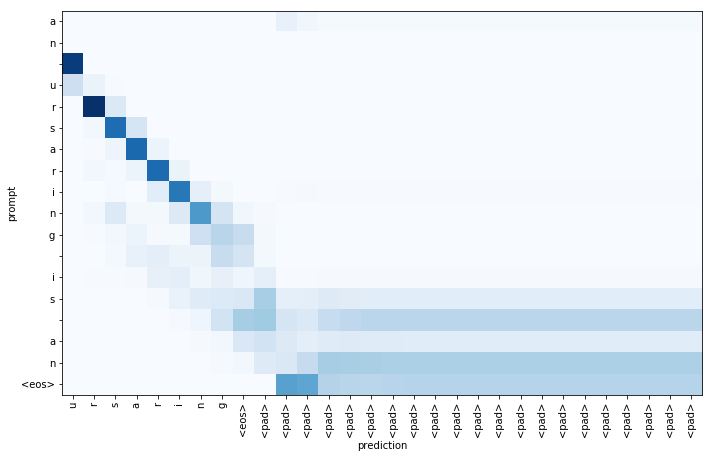

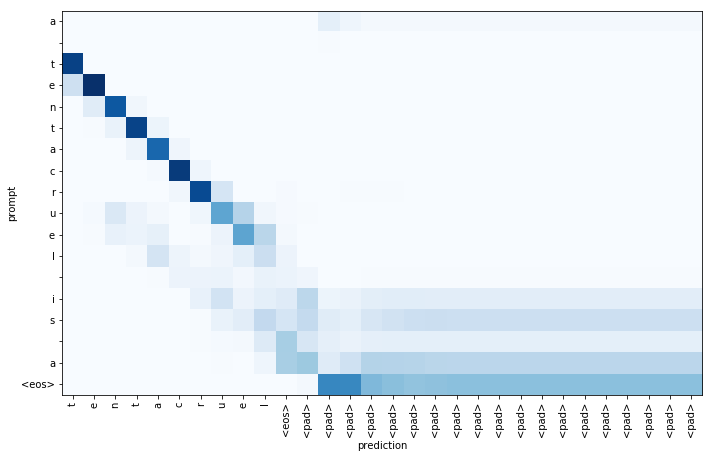

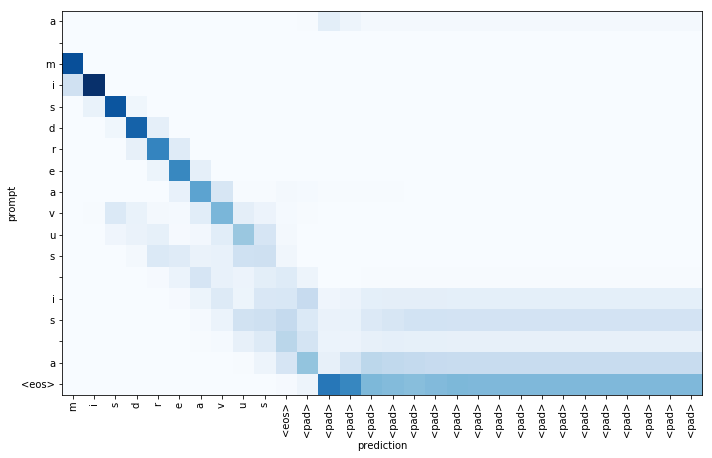

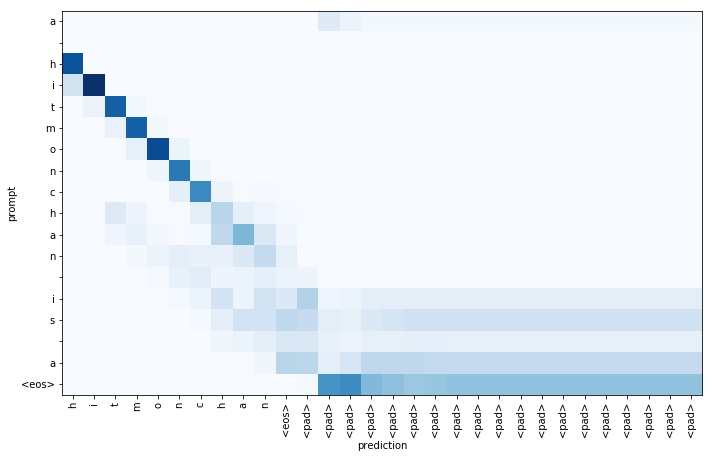

In [55]:
for batch in val_iter:
    out, attns = model(batch)
    
    predictions = []

    for i in range(batch.prompt.size()[1]):
        prompt = [char_field.vocab.itos[x] for x in batch.prompt.transpose(0,1).data.numpy()[i]]
        predict = [char_field.vocab.itos[x] for x in torch.max(out,1)[1].data.numpy()[i]]
        predictions.append(predict)

    for dim in range(len(attns)):
        make_plot(attns[dim].data.numpy(),
                  batch.prompt[:,dim].data.numpy(),
                  predictions[dim])

In [59]:
word = 'pikachu'
tsv = open("special_test.tsv","w")
tsv.write(f"an {word} is an\t{word}")
tsv.close()


In [60]:
special_char = data.TabularDataset(path="special_test.tsv",
                                  format='tsv',
                                  fields=[('prompt', char_field),
                                          ('answer', char_field)])
special_iter = data.Iterator(special_char, batch_size=batch_size, sort_key=sort_key, device=-1)
special_iter.repeat = False

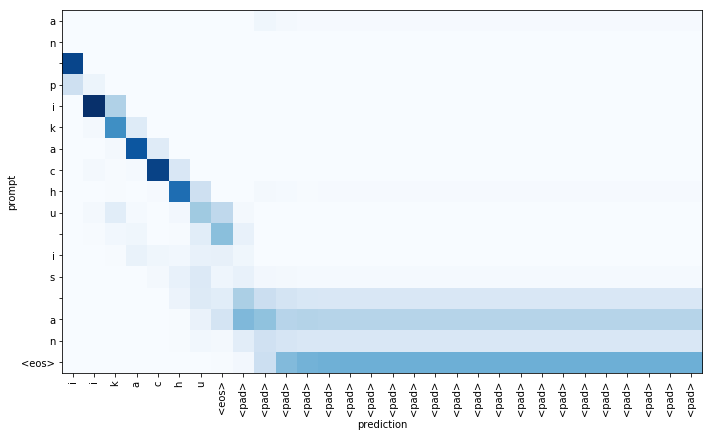

In [61]:
for batch in special_iter:
    out, attns = model(batch)
    
    predictions = []

    for i in range(batch.prompt.size()[1]):
        prompt = [char_field.vocab.itos[x] for x in batch.prompt.transpose(0,1).data.numpy()[i]]
        predict = [char_field.vocab.itos[x] for x in torch.max(out,1)[1].data.numpy()[i]]
        predictions.append(predict)

    for dim in range(batch.batch_size):
        make_plot(attns[dim].data.numpy(),
              batch.prompt[:,dim].data.numpy(),
              predictions[dim])